In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import data
from IPython.display import HTML, Markdown
# import myWidgets
import logisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import Model
import Trackers.ModelTracker as ModelTracker
import plot_tools
import writing_tools
import FeatureTools
import Trackers.FeatureTracker as FeatureTracker
import Trackers.DataTracker as DataTracker


In [3]:
df = data.get_data()
model_tracker = ModelTracker.ModelTracker()
feature_tracker = FeatureTracker.FeatureTracker(df.copy())
data_tracker = DataTracker.X_tracker()
cols_to_scale = []

Le but de ce projet est de construire un modèle de prédiction simple afin de me familiariser avec les concepts de base d'intelligence artificielle. 

Le projet va devoir prédire quels clients sont plus susceptibles d'acheter une assurance caravane en fonction des données provenant du CoIL 2000 Challenge. 

Les variables qui commence par M sont des variables qui donne de l'information sur la distribution de la variable dans le zipcode area du client. (0 = aucun, 9 = beaucoup). Ce n'est pas une zone! 

Sa décrit le contexte de vie, pas quelqu'un directement.

Sa ne veut pas dire que la personne soit x, mais qu'elle vit dans une zone où x est fréquent.

Reminder : n'oublie pas de scale les valeurs.

ok lol. Plus en plus que j'avance dans le projet, plus en plus je réalise que skip des étapes me ralenti et rend le projet beaucoup plus difficile à suivre. Je me suis créer une liste que je vais suivre à la lettre.

#### 1. **Obtenir et préparer le dataset**
Déja fais

#### 2. **Feature engineering** 
1. **Feature Creation** \
Consiste à créer des nouvelles variables à partir des connaissances métier ou en observant des patterns dans les données.
    - Ex : Créer une nouvelle variable qui nous indique que c'est un high income area
    - Interactions terms
2. **Feature Transformation** \
On ajuste les variables pour améliorer le training du modèle. 
    - One-hot encoding
    - Standardiser
    - transformation mathématique 
3. **Feature Extraction** \
Créer des variables plus synthétiques à partir des existantes pour réduire la dimensionnalité ou capturer l’information essentielle. Ou résumer l'information existante.
    - Réduction de dimension
    - Agrégation et combinaison
4. **Feature Selection** \
Consiste a choisir parmis toutes les variables dispo celles qui sont réellement utiles.
    - Filtrage : supprimer les variables inutiles (très faible corrélation)
    - wrapper ?
5. **Feature Scaling** \
Consiste à garantire que toutes les variables contribuent de manière équilibrée au modèle. 

#### Base Model

In [4]:
X = df.copy()
y = X.pop('CARAVAN')

X_train_base, X_val_base, y_train_base, y_val_base = data.get_split_train_eval_data(df)

X_train_base_np = X_train_base.to_numpy()
y_train_base_np = y_train_base.to_numpy()
X_val_base_np = X_val_base.to_numpy()
y_val_base_np = y_val_base.to_numpy()

In [5]:
w,b = logisticRegression.logistic_regression(X_train_base_np, y_train_base_np)
model = Model.Model(w, b, improvement="Base Model")
BASE_MODEL = "baseModel"
model_tracker.add(model, name=BASE_MODEL)
model.print_stats(X_val_base_np, y_val_base_np, threshold=0.1)

Iteration 0: Train cost = 0.6931
Iteration 100: Train cost = 0.2160
Iteration 200: Train cost = 0.2110
Iteration 300: Train cost = 0.2085
Iteration 400: Train cost = 0.2071
Iteration 500: Train cost = 0.2061
Iteration 600: Train cost = 0.2054
Iteration 700: Train cost = 0.2049
Iteration 800: Train cost = 0.2044
Iteration 900: Train cost = 0.2041
Model baseModel saved

Base Model
AUC         : 0.7934
Precision   : 0.1713
Recall      : 0.5286
F1          : 0.2587
Threshold   : 0.1000
[[916 179]
 [ 33  37]]


In [5]:
import re

mostype = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
mostype_val = np.array([48, 66, 59, 0, 15, 4 ,20, 89, 42, 5])

def read_dictionnary():
    with open("insurance_data/dictionary.txt", "r") as f:
        text = f.read()

    var_categorical = {}
    col_descriptions = {}
    lines = text.splitlines()[149:159]
    entries = [] 
    total = 0
    totalp = 0

    i = 0
    for line in lines:
        words = line.split()
        var_name = words[0]

        if int(var_name) in mostype:
            val = mostype_val[i]
            if val < 10 :
                total += val
                p = mostype_val[i] / 348
                totalp += p
                entries.append( (p, line) )
            i += 1

    entries.sort(reverse=True, key=lambda x: x[0])

    for p, line in entries:
        print(line, f"$\\approx {p:.3f}$ \\")
    print(f'**Total = {total} $\\approx {totalp:.3f}$**')

read_dictionnary()


10 Farmers $\approx 0.014$ \
6 Cruising Seniors $\approx 0.011$ \
4 Career Loners $\approx 0.000$ \
**Total = 9 $\approx 0.026$**


| MOSHOOFD (Customer main type)                |      1 |       2 |       3 |   4 |       5 |      6 |       7 |      8 |      9 |     10 |
|:-------------------------|-------:|--------:|--------:|----:|--------:|-------:|--------:|-------:|-------:|-------:|
| CARAVAN = 1              | 48     | 66      | 59      |   0 | 15      | 4      | 20      | 89     | 42     | 5      |
| P(CARAVAN = 1\|MOSHOOFD) |  0.087 |  0.1315 |  0.0666 |   0 |  0.0264 | 0.0195 |  0.0364 |  0.057 |  0.063 | 0.0181 | 

P(CARAVAN = 1\|MOSHOOFD = 2) $\approx 0.1315$

\

|   MOSHOOFD |   CARAVAN = 1 |   P(MOSHOOFD) |   cumul P(MOSHOOFD) |
|-----------:|--------------:|--------------:|--------------------:|
|          8 |            89 |     0.255747  |            0.255747 |
|          2 |            66 |     0.189655  |            0.445402 |
|          3 |            59 |     0.16954   |            0.614943 |
|          1 |            48 |     0.137931  |            0.752874 |
|          9 |            42 |     0.12069   |            0.873563 |
|          7 |            20 |     0.0574713 |            0.931034 |
|          5 |            15 |     0.0431034 |            0.974138 |
|         10 |             5 |     0.0143678 |            0.988506 |
|          6 |             4 |     0.0114943 |            1        |
|          4 |             0 |     0         |            1        |

La majorité des acheteurs d'assurance caravan sont 

CARAVAN = 1 > 40 \
8 Family with grown ups $\approx 0.256$ \
2 Driven Growers $\approx 0.190$ \
3 Average Family $\approx 0.170$ \
1 Successful hedonists $\approx 0.138$ \
9 Conservative families $\approx 0.121$ \
**Total = 304 $\approx 0.8736$**

CARAVAN = 1 >= 10 \
7 Retired and Religeous $\approx 0.057$ \
5 Living well $\approx 0.043$ \
**Total = 35 $\approx 0.101$**

CARAVAN = 1 < 10 \
10 Farmers $\approx 0.014$ \
6 Cruising Seniors $\approx 0.011$ \
4 Career Loners $\approx 0.000$ \
**Total = 9 $\approx 0.026$**


MOSTYPE = customer sub-type

CARAVAN $ = 1 \geq 10$ 
-   | MOSTYPE   | 1  | 3  | 6  | 8  | 9  | 12 | 13 | 33 | 36 | 37 | 38 | 39 |
    | --------- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
    | CARAVAN  | 13 | 25 | 12 | 51 | 12 | 16 | 13 | 46 | 16 | 10 | 23 | 19 | 

    1 High Income, expensive child $\approx 0.037 $ \
    3 High status seniors $\approx 0.072 $ \
    6 Career and childcare $\approx 0.034 $ \
    8 Middle class families $\approx 0.147 $ \
    9 Modern, complete families $\approx 0.034 $ \
    12 Affluent young families $\approx 0.046 $ \
    13 Young all american family $\approx 0.037 $ \
    33 Lower class large families $\approx 0.132 $ \
    36 Couples with teens 'Married with children' $\approx 0.046 $ \
    37 Mixed small town dwellers $\approx 0.029 $ \
    38 Traditional families $\approx 0.066 $ \
    39 Large religous families $\approx 0.055 $ \
    **Total** = $256 / 348$ \
    **Total** $\approx 0.7356 $

    Familles $\approx 63.56 \% $ (Total) \
    Familles $\approx 86.40 \% $ si CARAVAN $ = 1 \geq 10$ 

$5 \leq$ CARAVAN $ = 1 \lt 10$ 

-   | MOSTYPE     | 2 | 10 | 11 | 24 | 31 | 32 | 34 | 35 | 41 |
    | ----------- | - | -- | -- | -- | -- | -- | -- | -- | -- |
    | CARAVAN = 1 | 6 | 9  | 9  | 5  | 6  | 6  | 9  | 8  | 5  |

    2 Very Important Provincials $\approx 0.017 $ \
    10 Stable family $\approx 0.026 $ \
    11 Family starters $\approx 0.026 $ \
    24 Young, low educated  $\approx 0.014 $ \
    31 Low income catholics $\approx 0.017 $ \
    32 Mixed seniors $\approx 0.023 $ \
    34 Large family, employed child $\approx 0.026 $ \
    35 Village families $\approx 0.023 $ \
    41 Mixed rurals $\approx 0.014 $ \
    **Total** = $65 / 348$ \
    **Total** $\approx 0.1868 $


CARAVAN $ = 1 \lt 5$ 
-   | MOSTYPE     | 4 | 5 | 7 | 20 | 22 | 23 | 25 | 26 | 27 | 29 | 30 |
    | ----------- | - | - | - | -- | -- | -- | -- | -- | -- | -- | -- |
    | CARAVAN = 1 | 2 | 2 | 3 | 2  | 4  | 4  | 2  | 1  | 1  | 2  | 4  |

    4 Affluent senior apartments $\approx 0.006 $ \
    5 Mixed seniors $\approx 0.006 $ \
    7 Dinki's (double income no kids) $\approx 0.009 $ \
    20 Etnically diverse $\approx 0.006 $ \
    22 Mixed apartment dwellers $\approx 0.011 $ \
    23 Young and rising $\approx 0.011 $ \
    25 Young seniors in the city $\approx 0.006 $ \
    26 Own home elderly $\approx 0.003 $ \
    27 Seniors in apartments $\approx 0.003 $ \
    29 Porchless seniors: no front yard $\approx 0.006 $ \
    30 Religious elderly singles $\approx 0.011 $ \
    **Total** = $27 / 348$ \
    **Total** $\approx 0.0776 $



In [6]:
corr_discrete = df.corr(method='spearman').loc[['CARAVAN']].sort_values(by='CARAVAN', axis=1, ascending=False).drop(columns=['CARAVAN'])
corr_top = corr_discrete.unstack().sort_values(ascending=False) #2d a 1d (A,B)
corr_combined = corr_discrete.style.background_gradient(cmap='coolwarm', axis=None).format(precision=4)

display(HTML(corr_combined.to_html()))

top_n = 10
print(f"Les {top_n} variables les plus correlated avec la cible sont :")
data.top_index_and_values(top_n ,corr_top)

# display(myWidgets.AllVarComparator(df.columns, df).get_widget())
# display(myWidgets.TripleAllVarComparator(df.columns, df).get_widget())


,PPERSAUT,APERSAUT,APLEZIER,PPLEZIER,PBRAND,MINKGEM,PWAPART,MKOOPKLA,AWAPART,MHKOOP,MOPLHOOG,MAUT1,MINK4575,ABRAND,ABYSTAND,MRELGE,PBYSTAND,MINK7512,MSKA,MBERHOOG,MZPART,MBERMIDD,MOPLMIDD,MGEMOMV,MGODPR,PGEZONG,AGEZONG,MSKB1,PWAOREG,AWAOREG,AFIETS,MFWEKIND,PFIETS,MBERZELF,AZEILPL,PZEILPL,MGODRK,ALEVEN,AINBOED,PINBOED,PLEVEN,PAANHANG,AAANHANG,AMOTSCO,PMOTSCO,MAUT2,MFGEKIND,MSKB2,MINK123M,MGODOV,MGEMLEEF,AWABEDR,PWABEDR,MAANTHUI,MINK3045,PBESAUT,ABESAUT,APERSONG,PPERSONG,AVRAAUT,PVRAAUT,PWERKT,AWERKT,PTRACTOR,ATRACTOR,AWALAND,PWALAND,MRELSA,MGODGE,ABROM,PBROM,MSKC,MBERARBG,MFALLEEN,MZFONDS,MBERBOER,MBERARBO,MOSTYPE,MRELOV,MSKD,MOSHOOFD,MAUT0,MHHUUR,MINKM30,MOPLLAAG
CARAVAN,0.1637,0.1495,0.1064,0.1064,0.1006,0.1002,0.0953,0.0947,0.0900,0.0799,0.0782,0.0734,0.0699,0.0695,0.0682,0.0682,0.0681,0.0632,0.0600,0.0572,0.0554,0.0410,0.0399,0.0355,0.0348,0.0337,0.0335,0.0309,0.0303,0.0303,0.0289,0.0287,0.0287,0.0266,0.0262,0.0262,0.0196,0.0193,0.0191,0.0190,0.0186,0.0146,0.0145,0.0103,0.0099,0.0084,0.0075,0.0073,0.0072,0.0041,0.0039,0.0006,0.0006,-0.0011,-0.0063,-0.0069,-0.0070,-0.0085,-0.0085,-0.0099,-0.0099,-0.0152,-0.0152,-0.0165,-0.0167,-0.0213,-0.0213,-0.0274,-0.0414,-0.0452,-0.0452,-0.0485,-0.0508,-0.0517,-0.0562,-0.0565,-0.0572,-0.0580,-0.0581,-0.0611,-0.0615,-0.0775,-0.0806,-0.0815,-0.0907


Les 10 variables les plus correlated avec la cible sont :
Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799


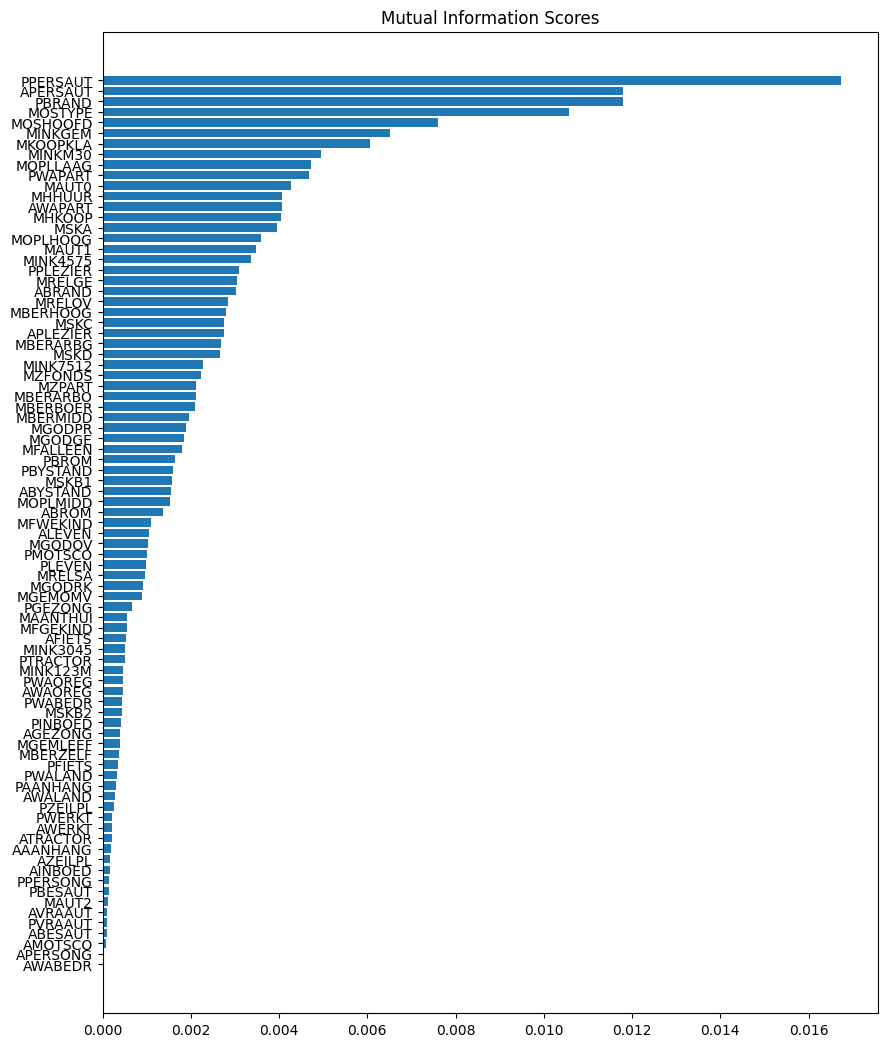

In [ ]:
discrete_features = df.dtypes == int
mi = FeatureTools.make_mi_scores(X, y, discrete_features)
mi = mi[mi > 0]
FeatureTools.plot_mi_scores(mi)

2.2 Feature Transformation

## 2.1 **Feature Creation**
Cette étape est baser sur l'intuition. Le but est de donner des patterns additionnels que le modèle peut ne pas voir.

**L’effet de X sur la probabilité Y change selon la valeur de Z** 

$P(Y | X, Z) = \dfrac{X \cap Z \cap Y}{X \cap Z}$ 

En général, une variation de $p \geq 0.05$ est bonne.

**MHKOOP** x **MAUT1** \
Home owner x 1 car. \
Pour pouvoir utiliser une caravan, il faut au minimum une voiture pour pouvoir la remorquer. De plus, il est plus probable que des home owners ai de la place pour garder une caravan sur leur terrain et aussi les moyens de se payer une caravan. Donc, un endroit avec une plus haute concentration de maison et voiture pourrait peut-être indiquer qu'un client y habitant est plus probable de posseder une assurance caravan.

| MHKOOP      |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|:------------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
| CARAVAN = 1 |  31 |  16 |  19 |  23 |  25 |  26 |  39 |  38 |  37 |  94 |


On peut voir la majorité des acheteurs d'assurance caravan habite dans des environnements à fortes concentration de 'Home owner' (6 à 9). Plus on s'éloigne de 'Forte concentration de Home owner', plus le niveau d'acheteur de Caravan baisse, mais lorsqu'on atteint la concentration '0', on peut observer une remontée.
- $\star$ La remontée est peut-être du aux personnes qui vivent dans des endroits plus pauvres ou peut-être aime le camping ou quelque chose comme ca et donc la quantité de home-owner doit être négligeable.

| MHKOOP                 |       0 |       1 |       2 |       3 |       4 |     5 |       6 |       7 |       8 |       9 |
|:-----------------------|--------:|--------:|--------:|--------:|--------:|------:|--------:|--------:|--------:|--------:|
| CARAVAN = 1            | 31      | 16      | 19      | 23      | 25      | 26    | 39      | 38      | 37      | 94      |
| P(CARAVAN = 1\|MHKOOP) |  0.0408 |  0.0302 |  0.0446 |  0.0602 |  0.0501 |  0.05 |  0.0646 |  0.0525 |  0.0867 |  0.0991 |

Si on observe l'effet de 'Home Owner' sur 'CARAVAN' si on change la valeur de 'MAUT1', on voit que l'intéraction augmente les chances d'avoir une assurance Caravan si la personne habite dans une zone à forte concentration de 'Home owner' et de '1 car' aussi, ce qui confirme mon hypothèse plus haut. 

De plus, on voit que pour un environnement a taux négligeable de 'Home owner', si la personne est aussi dans une zone a très forte concentration de '1 car', alors l'intéraction ajoute $\approx 8 \%$. Donc, ceci est peut-être une indication que ces personnes habites en nature/camping puisque si cet endroit ne possède presque pas de 'Home owner', mais que les personnes possède quand même une caravan, cela indique qu'il est fort probable qu'il possède une voiture puisque sinon comment ils ont ramener leur caravan içi?

(Tableau filtré selon l'espérence de chaque ligne pour ne pas avoir des extravagents et avec une augmentation de chance minimale de 0.05)

|   MHKOOP/MAUT1 |      5 |      7 |      9 |
|---------------:|-------:|-------:|-------:|
|              5 | 0      | 0.0509 | 0      |
|              6 | 0      | 0.0662 | 0      |
|              7 | 0      | 0      | 0.1031 |
|              8 | 0.0525 | 0      | 0      |
|              9 | 0.1198 | 0      | 0.0504 |

Donc, les termes suivants seront ajouté au modèles, car il apporte un gain de précision $\geq 0.05$ : \
(MAUT1 x MHKOOP) 5x8, 5x9, 7x5, 7x6, 9x7, 9x9


**MGEMOMV** x **MRELGE** \
Avg size household 1 to 6 x Married \
La majorité des personnes qui possèdes une assurance caravan sont situés entre un avg size household de 2-3 et un peu dans 4. \
$P($ avg size $= 3$ | Caravan $ = 1) \approx$ 0.49 \
$P($ avg size $= 2$ | Caravan $ = 1) \approx$ 0.33 \
$P($ avg size $= 4$ | caravan $ = 1) \approx$ 0.14. \
De plus, on peut voir que la concentration des personnes marriés et Avg size household 1 to 6 ($A \cap B$) se situe où il y a un avg size household de 2-3-4. 

|   MGEMOMV/MRELGE |   0 |   1 |   2 |   3 |   4 |   5 |   6 |    7 |   8 |   9 |
|-----------------:|----:|----:|----:|----:|----:|----:|----:|-----:|----:|----:|
|                1 |  35 |  53 |  71 |  23 |  39 |  30 |  10 |   23 |   0 |   0 |
|                2 |  29 |  22 |  85 | 195 | 244 | 580 | 399 |  373 |  27 | 177 |
|                3 |   0 |   0 |   1 |  27 |  28 | 311 | 640 | 1024 | 207 | 407 |
|                4 |   0 |   0 |   0 |   1 |  11 |  18 | 115 |  249 | 126 | 173 |
|                5 |   0 |   0 |   0 |   0 |   2 |   7 |   8 |   13 |   1 |  37 |

Donc des personnes mariés augmente les chances d'avoir une taille de ménage > 1 et donc augmente les chances d'avoir une assurance caravan. En plus, on sait que la majorité des acheteurs sont des familles ($\approx 63.56 \% $) \

| MGEMOMV                   |           3 |           2 |          4 |        1 |         5 |
|:--------------------------|------------:|------------:|-----------:|---------:|----------:|
| CARAVAN = 1               | 171         | 115         | 50         | 8        | 4         |
| P(CARAVAN = 1 \| MGEMOMV) |   0.0646503 |   0.0539653 |  0.0721501 | 0.028169 | 0.0588235 |



Gain d'espérence des intéractions : 
|   MGEMOMV/MRELGE |      9 |
|-----------------:|-------:|
|                4 | 0.0666 |

Finalement, une seule intéractions donne une augmentation qui vaut la peine, mais elle est pour une donnée asser rare \
$P($ caravan $= 1$ | avg size $ = 4) \approx$ 0.0722 \
Je crois que sa vaut la peine de l'ajouter puisque ajouter l'intéraction avec 'Married' augmente la probabilité de $\approx$ +0.0666, ce qui pourrait aider le modèle a prédire cette donnée rare. 
| MGEMOMV/MRELGE | 9   |
|----------------|-----|
| 4 (CARAVAN = 1 $\cup$ CARAVAN = 0)             | 173 |
| 4 (CARAVAN = 1)              | 24 |
P(CARAVAN=1 \\| MGEMOMV=4, MRELGE=9) | 0.139 |


**MFWEKIND x MHKOOP** \
Household with children x Home owners


**Tableau de fréquence de Household with children si caravan = 1**
|   MFWEKIND |   CARAVAN = 1 |   P(MFWEKIND) |   cumul P(MFWEKIND) |   P(CARAVAN = 1 \| MFWEKIND) |
|-----------:|--------------:|--------------:|--------------------:|-----------------------------:|
|          4 |            66 |     0.189655  |            0.189655 |                    0.0580475 |
|          3 |            59 |     0.16954   |            0.359195 |                    0.0606372 |
|          5 |            58 |     0.166667  |            0.525862 |                    0.0524412 |
|          6 |            56 |     0.16092   |            0.686782 |                    0.0716113 |
|          2 |            39 |     0.112069  |            0.798851 |                    0.0614173 |
|          7 |            23 |     0.066092  |            0.864943 |                    0.0655271 |
|          8 |            18 |     0.0517241 |            0.916667 |                    0.0873786 |
|          9 |            14 |     0.0402299 |            0.956897 |                    0.0752688 |
|          1 |            10 |     0.0287356 |            0.985632 |                    0.0342466 |
|          0 |             5 |     0.0143678 |            1        |                    0.0326797 |


La majorité des acheteurs d'assurance caravan se situe dans des endroits avec une concentration modérée de household with children (2 à 6).

On sait que la majorité des personnes qui ont une assurance caravan, habite dans un endroit avec majoritairement un sous-type famille (MOSTYPE (customer sub-type) famille $\approx 63.56 \% $). Donc, un endroit avec des "household with children" (donc probablement des familles) devrait avoir plus de chance d'avoir des acheteurs d'assurance Caravan. On sait aussi que la majorité des acheteurs d'assurance caravan habite dans un endroit avec un niveau de concentration de home owner de 6 à 9 (le plus haut). Donc, les endroits avec des "household with children" + "home owner" devrait augmenter les chances d'avoir un acheteur d'assurance Caravan.

|   MFWEKIND/MHKOOP |      2 |      4 |      8 |      9 |
|------------------:|-------:|-------:|-------:|-------:|
|                 2 | 0      | 0.2356 | 0      | 0.0697 |
|                 4 | 0      | 0      | 0.0559 | 0      |
|                 5 | 0      | 0      | 0      | 0.0593 |
|                 6 | 0.0641 | 0      | 0      | 0      |

Les gains additionnels sont situé dans les endroits avec un household with children de concentration 2-4-5-6 ce qui peut être pas mal utile pour le modèle puisque la grande majorité des acheteurs sont situé dans des endroits avec ce taux de concentration de household with children. Sa va permettre d'augmenter la précision globale. 

**Tableau de frequence de MHKOOP si CARAVAN=1**
|   MHKOOP |   CARAVAN = 1 |   P(MHKOOP) |   cumul P(MHKOOP) |
|---------:|--------------:|------------:|------------------:|
|        9 |            94 |   0.270115  |          0.270115 |
|        6 |            39 |   0.112069  |          0.382184 |
|        7 |            38 |   0.109195  |          0.491379 |
|        8 |            37 |   0.106322  |          0.597701 |
|        0 |            31 |   0.0890805 |          0.686782 |
|        5 |            26 |   0.0747126 |          0.761494 |
|        4 |            25 |   0.0718391 |          0.833333 |
|        3 |            23 |   0.066092  |          0.899425 |
|        2 |            19 |   0.0545977 |          0.954023 |
|        1 |            16 |   0.045977  |          1        |

De plus, deux des termes sont situé dans des endroits a bas niveau (2 et 4) de MHKOOP (home owners) ce qui va etre très utile pour le modèle, car la majorité des acheteurs ne sont pas situé dans des endroits avec bas taux de concentration de MHKOOP, donc c'est des informations additionnelles qui vont aider le modèle à prédire des cas rare. Il y a un énorme gain de précision avec le terme de 2x4 (MFWEKIND x MHKOOP) $\approx$ +0.2356!

Les termes qui seront ajoutés sont (MFWEKIND x MHKOOP) : \
2x4, 2x9, 4x8, 5x9, 6x2



**MOSTYPE x MBER\*** \
customer sub-type x statut professionel

Relier le type de client à la concentration d'un certain statut professionnel dans l'endroit où il habite peut nous donner des informations additionnels puisqu'on sait que le type de client influence les chances d'êtres un acheteur d'assurance caravan (la majorité sont des familles). Par exemple si quelqu'un qui est une famille + habite dans un endroit avec une bonne concentration de bon statut professionel, alors il a probablement plus de chance d'avoir les moyens d'avoir une caravan + l'envie de prendre des vacances en caravan avec sa famille, etc

MBERHOOG = High Status
| MOSTYPE/MBERHOOG          |      0 |      1 |      2 |      3 |      4 |      6 |
|:--------------------------|-------:|-------:|-------:|-------:|-------:|-------:|
| High status seniors       | 0      | 0      | 0      | 0      | 0      | 0.0558 |
| Middle class families     | 0.1912 | 0      | 0.0619 | 0.0883 | 0.0947 | 0      |
| Affluent young families   | 0.2462 | 0      | 0.1428 | 0      | 0      | 0      |
| Mixed small town dwellers | 0      | 0.0729 | 0      | 0      | 0      | 0      |

(MOSTYPExMBERHOOG) 3x6, 8x0, 8x2, 8x3, 8x4, 12x0, 12x2, 37x1

**MBERZELF = Entrepreneur**
| MOSTYPE/MBERZELF        |      0 |      1 |
|:------------------------|-------:|-------:|
| High status seniors     | 0      | 0.053  |
| Middle class families   | 0.1141 | 0.0685 |
| Affluent young families | 0.1162 | 0      |

significant interactions: (MOSTYPExMBERZELF) 3x1, 8x0, 8x1, 12x0

**MBERBOER = Farmer**
| MOSTYPE/MBERBOER        |      0 |     1 |
|:------------------------|-------:|------:|
| High status seniors     | 0      | 0.062 |
| Middle class families   | 0.0976 | 0     |
| Affluent young families | 0.0762 | 0     |

significant interactions: (MOSTYPExMBERBOER) 3x1, 8x0, 12x0

**MBERMIDD = Middle management**
| MOSTYPE/MBERMIDD                           |      2 |      3 |      4 |      5 |      7 |      9 |
|:-------------------------------------------|-------:|-------:|-------:|-------:|-------:|-------:|
| High Income, expensive child               | 0.1224 | 0      | 0      | 0      | 0      | 0      |
| High status seniors                        | 0      | 0.1091 | 0      | 0      | 0      | 0      |
| Career and childcare                       | 0.1652 | 0      | 0      | 0      | 0      | 0      |
| Middle class families                      | 0      | 0      | 0.1295 | 0.1009 | 0.1705 | 0.1857 |
| Affluent young families                    | 0      | 0      | 0      | 0      | 0.2764 | 0      |
| Couples with teens 'Married with children' | 0.0781 | 0      | 0      | 0      | 0      | 0      |

significant interactions: (MOSTYPExMBERMIDD) 1x2, 3x3, 6x2, 8x4, 8x5, 8x7, 8x9, 12x7, 36x2

**MBERARBG = Skilled workers**
| MOSTYPE/MBERARBG                           |      0 |      1 |      2 |      3 |
|:-------------------------------------------|-------:|-------:|-------:|-------:|
| High Income, expensive child               | 0      | 0.0678 | 0      | 0      |
| High status seniors                        | 0      | 0      | 0.0578 | 0      |
| Career and childcare                       | 0.0769 | 0      | 0      | 0      |
| Middle class families                      | 0.1196 | 0.0906 | 0      | 0.2189 |
| Modern, complete families                  | 0      | 0.0506 | 0      | 0      |
| Affluent young families                    | 0.134  | 0.0599 | 0      | 0      |
| Couples with teens 'Married with children' | 0      | 0.0851 | 0      | 0      |
| Large religous families                    | 0      | 0      | 0.0691 | 0      |

significant interactions: (MOSTYPExMBERARBG) 1x1, 3x2, 6x0, 8x0, 8x1, 8x3, 9x1, 12x0, 12x1, 36x1, 39x2

**MBERARBO = Unskilled workers**
| MOSTYPE/MBERARBO                           |      0 |      1 |      2 |      3 |      4 |
|:-------------------------------------------|-------:|-------:|-------:|-------:|-------:|
| High Income, expensive child               | 0      | 0.0891 | 0      | 0      | 0      |
| High status seniors                        | 0      | 0      | 0.0562 | 0      | 0      |
| Career and childcare                       | 0.0944 | 0      | 0      | 0      | 0      |
| Middle class families                      | 0.1057 | 0.0709 | 0      | 0      | 0      |
| Affluent young families                    | 0.098  | 0      | 0.103  | 0      | 0      |
| Couples with teens 'Married with children' | 0      | 0      | 0      | 0      | 0.0684 |
| Traditional families                       | 0.1086 | 0      | 0      | 0.0584 | 0      |

significant interactions: (MOSTYPExMBERARBO) 1x1, 3x2, 6x0, 8x0, 8x1, 12x0, 12x2, 36x4, 38x0, 38x3


(MAUT1 x MHKOOP) 5x8, 5x9, 7x5, 7x6, 9x7, 9x9

(MGEMOMV x MRELGE) 4x9

(MFWEKIND x MHKOOP) 2x4, 2x9, 4x8, 5x9, 6x2

(MOSTYPExMBERHOOG) 3x6, 8x0, 8x2, 8x3, 8x4, 12x0, 12x2, 37x1

(MOSTYPExMBERZELF) 3x1, 8x0, 8x1, 12x0

(MOSTYPExMBERBOER) 3x1, 8x0, 12x0

(MOSTYPExMBERMIDD) 1x2, 3x3, 6x2, 8x4, 8x5, 8x7, 8x9, 12x7, 36x2

(MOSTYPExMBERARBG) 1x1, 3x2, 6x0, 8x0, 8x1, 8x3, 9x1, 12x0, 12x1, 36x1, 39x2

(MOSTYPExMBERARBO) 1x1, 3x2, 6x0, 8x0, 8x1, 12x0, 12x2, 36x4, 38x0, 38x3


## 2.2 Feature Transformation
On ajuste les variables pour améliorer le training modèle.

Je vais commencer par one-hot encoding les variables catégoriques non-ordinales, donc 
- MOSTYPE Customer Subtype
- MOSHOOFD Customer main type 

In [7]:
categorical_non_ordinales = ['MOSTYPE', 'MOSHOOFD']
df_encoded = pd.get_dummies(df, columns=categorical_non_ordinales, prefix=categorical_non_ordinales, dtype=int)

## 2.3 Feature Extraction 

Maintenant je vais créer des nouvelles variables. 

Tout les variables qui commence par la lettre A, sont des quantité de police détenues par un client.
- total_policies = nombre total de polices
- total_motor_vehicle_policies = nombre total de polices pour vehicules motorisés


In [8]:
X = df_encoded.copy()
DATA_V0 = "DATA_V0"
data_tracker.add(DATA_V0, X)
feature_tracker = FeatureTracker.FeatureTracker(X)
FEATURE1_TAG = "FEAT1"

Dataset DATA_V0 saved.



In [9]:
X.columns

Index(['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR', 'MGODOV',
       'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV',
       ...
       'MOSHOOFD_1', 'MOSHOOFD_2', 'MOSHOOFD_3', 'MOSHOOFD_4', 'MOSHOOFD_5',
       'MOSHOOFD_6', 'MOSHOOFD_7', 'MOSHOOFD_8', 'MOSHOOFD_9', 'MOSHOOFD_10'],
      dtype='object', length=134)

In [10]:
all_policy_columns = [
    'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT',
    'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG',
    'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND'
]

motorized_columns = ['APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM']

recreational_vehicules = ['APLEZIER', 'AFIETS',  'AZEILPL']

feature_tracker.add('total_policies', X[all_policy_columns].sum(axis=1), toScale=True)
feature_tracker.add('total_motorized_policies', X[motorized_columns].sum(axis=1), toScale=True)
feature_tracker.add('total_recreational_policies', X[recreational_vehicules].sum(axis=1), toScale=True)

Dans la variable total_recreational_policies, 0 domine. Les cas 1-2-3 sont très rares. 

In [11]:
X = feature_tracker.flush_to_df()
print(X[X['CARAVAN'] == 1]['total_recreational_policies'].value_counts())


total_recreational_policies
0    320
1     21
2      6
3      1
Name: count, dtype: int64


Alors, je crois que c'est mieux de les réunir en une variable binaire "has_recreational_policies" pour éviter d'ajouter du bruit. De plus, je vais retirer 'APLEZIER', 'AFIETS',  'AZEILPL' pour enlever du bruit, car peu de variables possède ces attributs avec au minimum > 0.

In [12]:
feature_tracker.add('has_recreational_vehicule_policie', X[recreational_vehicules].gt(0).any(axis=1).astype(int))
feature_tracker.remove('total_recreational_policies')
for c in recreational_vehicules: feature_tracker.remove(c)

Toute les variables qui commence par la lettre P sont des classes discrète de contribution, donc pas les montants exacts. Mais je peux quand même créer : 
- total_contribution
- total_motor_vehicule_contribution

In [13]:
all_contribution_columns = ['PWAPART','PWABEDR','PWALAND','PPERSAUT','PBESAUT','PMOTSCO', 'PVRAAUT','PAANHANG','PTRACTOR','PWERKT','PBROM','PLEVEN',
                            'PPERSONG','PGEZONG','PWAOREG','PBRAND','PZEILPL','PPLEZIER','PFIETS','PINBOED','PBYSTAND']

motorized_contrib_col = ['PPERSAUT','PBESAUT','PMOTSCO','PVRAAUT','PAANHANG','PTRACTOR','PWERKT','PBROM']

recreational_contrib_col = ['PPLEZIER', 'PFIETS',  'PZEILPL']

feature_tracker.add('total_contribution', X[all_contribution_columns].sum(axis=1), toScale=True)
feature_tracker.add('total_motorized_contribution', X[motorized_contrib_col].sum(axis=1), toScale=True)
feature_tracker.add('total_recreational_contribution',X[recreational_contrib_col].sum(axis=1), toScale=True)


Pareil pour total_recreational_contribution, le 0 domine et cette variable risque d'introduire du bruit. Donc, il est mieux de retirer la colonne. Aussi, c'est inutile d'ajouter has_recreational_contribution puisque has_recreational_vehicule_policie capture déja la même information.

In [14]:
X = feature_tracker.flush_to_df()

In [15]:
feature_tracker.remove('total_recreational_contribution')
for c in recreational_contrib_col: feature_tracker.remove(c)

Je peux aussi créer des ratios à l'aide de ces nouvelles variables
- ratio_motorized_policies
- ratio_motorized_contribution

In [16]:
feature_tracker.add('ratio_motorized_policies',  X['total_motorized_policies'] / X['total_policies'], toScale=True)
feature_tracker.add('ratio_motorized_contribution',  X['total_motorized_contribution'] / X['total_contribution'], toScale=True)

X = feature_tracker.flush_to_df()

X['ratio_motorized_policies'] = X['ratio_motorized_policies'].replace(np.inf, 0)
X['ratio_motorized_policies'] = X['ratio_motorized_policies'].replace(np.nan, 0)
X['ratio_motorized_contribution'] = X['ratio_motorized_contribution'].replace(np.inf, 0)
X['ratio_motorized_contribution'] = X['ratio_motorized_contribution'].replace(np.nan, 0)

feature_tracker.set_df(X)


37 MINKM30 Income < 30.000 \
38 MINK3045 Income 30-45.000 \
39 MINK4575 Income 45-75.000 \
40 MINK7512 Income 75-122.000 \
41 MINK123M Income >123.000 \
42 MINKGEM Average income

MINKGEM ne donne pas tellement d'informations, c'est seulement un range de 0 à 9. On sais pas c'est quoi le average income, juste un "scaled" average income. Donc, je vais drop tout les MINK* pour une nouvelle variable qui donne le average income de l'endroit où se situe le client. 


In [14]:
X_temp = X.copy()

In [540]:
feature_tracker.set_df(X_temp)

In [17]:
X = feature_tracker.getDf()
print(X.isna().sum().value_counts())

0    135
Name: count, dtype: int64


In [18]:
income_brackets_midpoints = {
    'MINKM30': 15000,    
    'MINK3045': 37500,   
    'MINK4575': 60000,   
    'MINK7512': 98500,   
    'MINK123M': 150000 #On va dire que c'est sa
}

income_cols = list(income_brackets_midpoints.keys())
weighted_somme = 0
for col in income_cols:
    weighted_somme += X[col] * income_brackets_midpoints[col]
total = X[income_cols].sum(axis=1)

for c in income_cols:
    feature_tracker.remove(c)
feature_tracker.remove('MINKGEM')

feature_tracker.add('avg_area_income',  weighted_somme / total, toScale=True)

X = feature_tracker.flush_to_df()

In [19]:
X.columns

Index(['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR', 'MGODOV',
       'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV',
       ...
       'MOSHOOFD_9', 'MOSHOOFD_10', 'total_motorized_policies',
       'total_policies', 'has_recreational_vehicule_policie',
       'total_contribution', 'total_motorized_contribution',
       'ratio_motorized_contribution', 'ratio_motorized_policies',
       'avg_area_income'],
      dtype='object', length=130)

## 2.4 Feature Selection
Consister à choisir parmis toutes les variables dispo celles qui sont réellement utiles.

Avant de débuter, je vais ajouter tout les variables manquantes au dataset (les interactions terms)

In [20]:
interaction_terms = {
    "MAUT1_MHKOOP": {
        "var1": "MAUT1",
        "var2": "MHKOOP",
        "pairs": "5x8,5x9,7x5,7x6,9x7,9x9",
        "isVar1OneHot": False
    },
    "MGEMOMV_MRELGE": {
        "var1": "MGEMOMV",
        "var2": "MRELGE",
        "pairs": "4x9",
        "isVar1OneHot": False
    },
    "MFWEKIND_MHKOOP": {
        "var1": "MFWEKIND",
        "var2": "MHKOOP",
        "pairs": "2x4,2x9,4x8,5x9,6x2",
        "isVar1OneHot": False
    },
    "MOSTYPE_MBERHOOG": {
        "var1": "MOSTYPE",
        "var2": "MBERHOOG",
        "pairs": "3x6,8x0,8x2,8x3,8x4,12x0,12x2,37x1",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERZELF": {
        "var1": "MOSTYPE",
        "var2": "MBERZELF",
        "pairs": "3x1,8x0,8x1,12x0",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERBOER": {
        "var1": "MOSTYPE",
        "var2": "MBERBOER",
        "pairs": "3x1,8x0,12x0",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERMIDD": {
        "var1": "MOSTYPE",
        "var2": "MBERMIDD",
        "pairs": "1x2,3x3,6x2,8x4,8x5,8x7,8x9,12x7,36x2",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERARBG": {
        "var1": "MOSTYPE",
        "var2": "MBERARBG",
        "pairs": "1x1,3x2,6x0,8x0,8x1,8x3,9x1,12x0,12x1,36x1,39x2",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERARBO": {
        "var1": "MOSTYPE",
        "var2": "MBERARBO",
        "pairs": "1x1,3x2,6x0,8x0,8x1,12x0,12x2,36x4,38x0,38x3",
        "isVar1OneHot": True
    }
}

for key, spec in interaction_terms.items():
    feature_tracker.create_interaction_terms(
                                  spec['var1'],
                                  spec['var2'],
                                  spec['pairs'],
                                  isVar1OneHot=spec['isVar1OneHot'])

X = feature_tracker.flush_to_df()


In [21]:
print(X.isna().sum().value_counts())

0    187
Name: count, dtype: int64


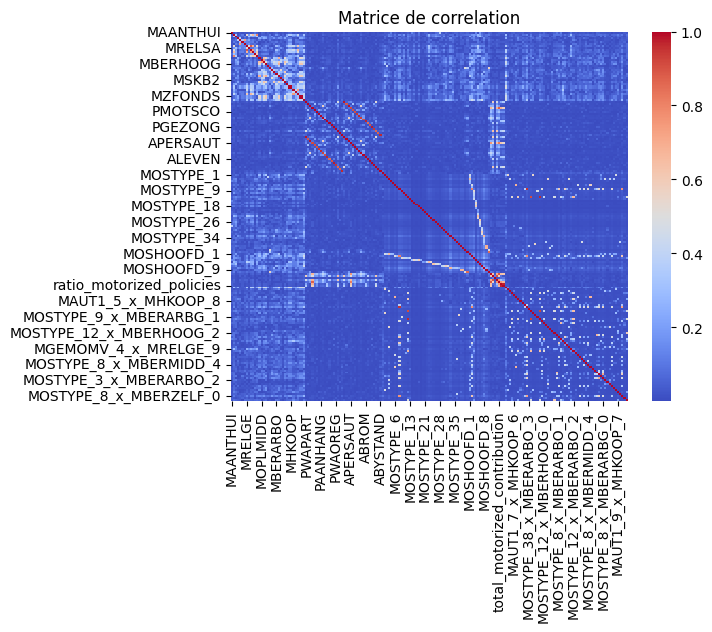

In [23]:
cols_to_drop_too_correlated_1 = FeatureTools.find_correlated_cols(X, threshold=0.95)

Les colonnes redondantes sont ceux qui sont presque indentiques (à $\geq$ 0.95). Ils amène pratiquement la meme informations au modèle, donc une des deux paires sera retirés. Je garder celle qui 
1. À des interactions terms
2. Le plus haut niveau de variance

In [24]:
for col1, col2 in cols_to_drop_too_correlated_1:
    print(col1, " variance : ", X[col1].var())
    print(col2, " variance : ", X[col2].var())
    print()

MHHUUR  variance :  9.543623838560585
MHKOOP  variance :  9.546942076649835

MZFONDS  variance :  3.915317038498481
MZPART  variance :  3.928059738675763

PWAPART  variance :  0.9190138088718947
AWAPART  variance :  0.24269876044254982

PWALAND  variance :  0.250021872459651
AWALAND  variance :  0.020193504853560793

PAANHANG  variance :  0.04526512904160845
AAANHANG  variance :  0.015822082742245606

PBROM  variance :  0.6612913547405973
ABROM  variance :  0.07029584198933711

PGEZONG  variance :  0.03705141533409961
AGEZONG  variance :  0.006486586367288483

PBYSTAND  variance :  0.16732278142121987
ABYSTAND  variance :  0.01440146501203428

ratio_motorized_contribution  variance :  0.16985783907969593
ratio_motorized_policies  variance :  0.16569453277980348

MOSTYPE_8  variance :  0.05485524328019597
MOSTYPE_8_x_MBERBOER_0  variance :  0.050120815084145495

MOSTYPE_12  variance :  0.01870847996146197
MOSTYPE_12_x_MBERBOER_0  variance :  0.017550154642127



In [25]:
cols_to_remove = [
    'MHHUUR', 'MZFONDS', 'AWAPART', 'AWALAND', 'AAANHANG', 
    'ABROM', 'AGEZONG', 'ABYSTAND', 'ratio_motorized_policies', 
    'MOSTYPE_8_x_MBERBOER_0', 'MOSTYPE_12_x_MBERBOER_0'
]

for c in cols_to_remove: feature_tracker.remove(c)

In [26]:
print(len(X.columns))
X = feature_tracker.flush_to_df()
print(len(X.columns))

187
176


In [25]:
X_without_caravan = X.drop(columns=['CARAVAN'])
discrete_features = X_without_caravan.dtypes == int

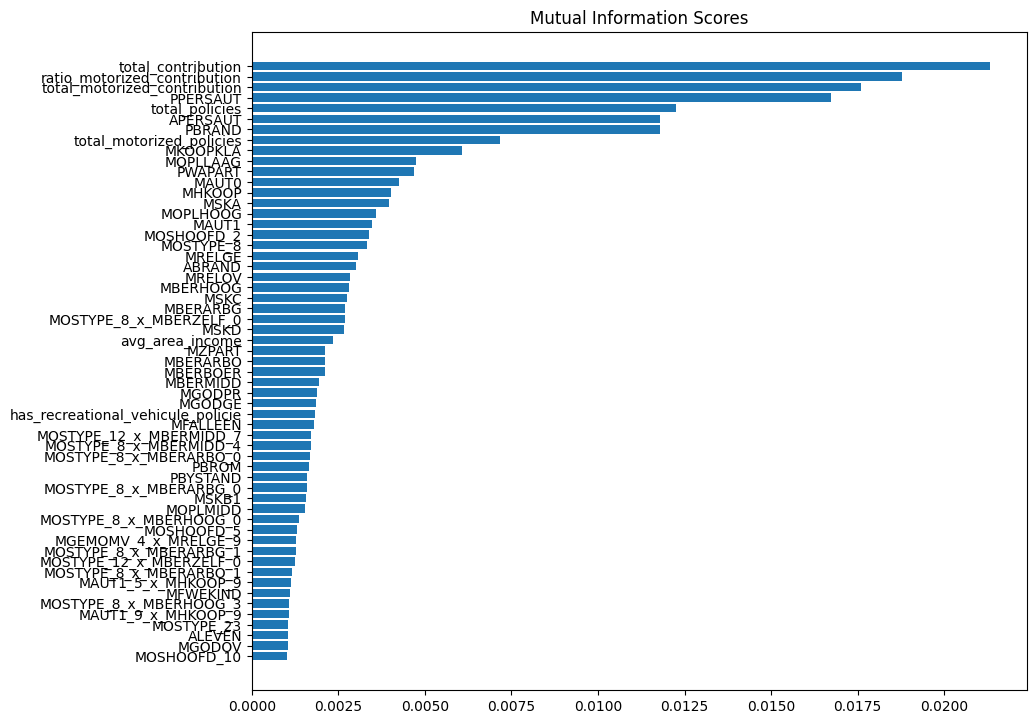

In [ ]:
mi = FeatureTools.make_mi_scores(X_without_caravan, X['CARAVAN'], discrete_features)
mi = mi[mi > 0.001]
FeatureTools.plot_mi_scores(mi)

## 2.5 Feature Scaling

Les variables à standardisés sont les variables continues.

In [22]:
X_temp = feature_tracker.getDf()

In [27]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

DATA_V1 = "Feature_Engineering_v1"
data_tracker.add(DATA_V1, feature_tracker.getDf())

Dataset Feature_Engineering_v1 saved.



In [28]:
# float_cols = X.columns[X.dtypes == 'float64']
# cols_to_scale = list(set(cols_to_scale))

# scaler = StandardScaler()

# scaler.fit(X_train[cols_to_scale])
# X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

# scaler.fit(X_val[cols_to_scale])
# X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])


X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()


## Clustering with K-Means
"birds of a feather flock together"

In [204]:
float_cols = X.columns[X.dtypes == 'float64']
X_cluster = X[float_cols].copy()
kmeans = KMeans(n_clusters=6)
X_cluster['Cluster'] = kmeans.fit_predict(X_cluster)
X_cluster['Cluster'] = X_cluster['Cluster'].astype('category')

X_cluster.head()

,ratio_motorized_contribution,avg_area_income,Cluster
0,0.00,58555.555556,5
1,0.60,27500.000000,1
2,0.75,42500.000000,3
3,0.00,60000.000000,5
4,1.00,33000.000000,1


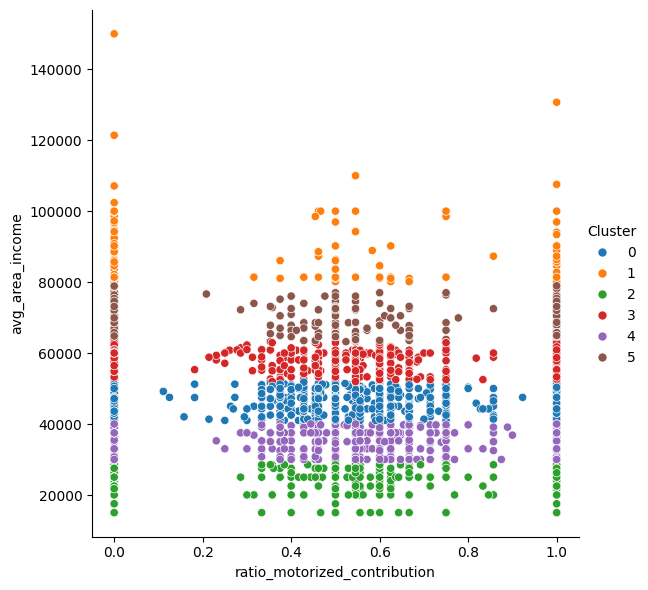

In [183]:
sns.relplot( x="ratio_motorized_contribution", y="avg_area_income", hue="Cluster", data=X_cluster, height=6);

# 3. **Model Optimization & Evaluation**

Maintenant on passe à l'optimization et l'évaluation du modèle. Je vais commencer par préparer le training / validation set. 

La première amélioration que je remarque et que le modèle est BEAUCOUP plus rapide à entrainer.

In [29]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np)
model = Model.Model(w, b, improvement="Added multiple features")
MODEL_WITH_FEATURES_1 = "MF1"
model_tracker.add(model, name=MODEL_WITH_FEATURES_1)
model.print_stats(X_val_np, y_val_np, threshold=0.1)

Iteration 0: Train cost = 0.6931
Iteration 100: Train cost = 0.2161
Iteration 200: Train cost = 0.2108
Iteration 300: Train cost = 0.2085
Iteration 400: Train cost = 0.2072
Iteration 500: Train cost = 0.2063
Iteration 600: Train cost = 0.2056
Iteration 700: Train cost = 0.2050
Iteration 800: Train cost = 0.2046
Iteration 900: Train cost = 0.2042
Model MF1 saved

Added multiple features
AUC         : 0.7973
Precision   : 0.1727
Recall      : 0.5429
F1          : 0.2621
Threshold   : 0.1000
[[913 182]
 [ 32  38]]


Si on compare maintenant, il y a presque aucune différence entre le modèle de base avec le training/validation set de base vs le modèle avec le nouveau set de training/validation.

In [30]:
baseModel = model_tracker.get_by_name(BASE_MODEL)

In [31]:
t = 0.1
baseModel.print_stats(X_val_base_np, y_val_base_np, threshold=t)
print()
model.print_stats(X_val_np, y_val_np, threshold=t)

Base Model
AUC         : 0.7934
Precision   : 0.1713
Recall      : 0.5286
F1          : 0.2587
Threshold   : 0.1000
[[916 179]
 [ 33  37]]

Added multiple features
AUC         : 0.7973
Precision   : 0.1727
Recall      : 0.5429
F1          : 0.2621
Threshold   : 0.1000
[[913 182]
 [ 32  38]]


## **3.1 Handle Class Imbalance**

Maintenant, puisque le data set est imbalanced, je vais ajuster les poids pour que le modèle paye plus attention à la classe positive. La classe positive (CARAVAN = 1) va valoir 1 fois le ratio négative pour positive. La classe négative restera avec un poids de 1.

In [32]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=ratio)
MODEL_WITH_FEAT1_WEIGHT = "MF1_WithClassWeights"
model = Model.Model(w,b,improvement="Added class weight")
model_tracker.add(model, name=MODEL_WITH_FEAT1_WEIGHT)

w_base, b_base = logisticRegression.logistic_regression(X_train_base_np, y_train_base_np, extra_weight=ratio, to_print=False)
MODEL_BASE_DATASET_WEIGHT = "baseDataSetlWithWeight"
baseModel = Model.Model(w_base, b_base, improvement="Base dataset with weights")

Iteration 0: Train cost = 1.3035
Iteration 100: Train cost = 1.1420
Iteration 200: Train cost = 1.1229
Iteration 300: Train cost = 1.1114
Iteration 400: Train cost = 1.1031
Iteration 500: Train cost = 1.0964
Iteration 600: Train cost = 1.0908
Iteration 700: Train cost = 1.0858
Iteration 800: Train cost = 1.0814
Iteration 900: Train cost = 1.0773
Model MF1_WithClassWeights saved



On peut voir un énorme gain de précision et F1 score avec le training/validation set optimiser. Par contre, le modèle trouve moins d'acheteurs d'assurance Caravan.

In [33]:
baseModel.print_stats(X_val_base_np, y_val_base_np)
print()
model.print_stats(X_val_np, y_val_np)

Base dataset with weights
AUC         : 0.7519
Precision   : 0.0854
Recall      : 0.9143
F1          : 0.1563
Threshold   : 0.5000
[[410 685]
 [  6  64]]

Added class weight
AUC         : 0.7956
Precision   : 0.1299
Recall      : 0.7571
F1          : 0.2218
Threshold   : 0.5000
[[740 355]
 [ 17  53]]


# **3.2 Hyperparameter tuning**

Ce sont les paramètres du modèle qui sont configurés avant de training le modèle. 

Je vais commencer par les poids puisqu'ils influencent la taille du gradient quand le modèle fais une erreurs par rapport à la classe CARAVAN = 1. Si je l'optimise plus tard, les résultats des gradients peuvent changer puisque les valeurs du gradient descent seront complètement différentes. Par exemple, pour le learning rate on veut les "steps" optimales pour mettre à jour les paramètres du modèle et on peut la trouvé en analysant la courbe du "loss function". Cette courbe est le résultat du gradient descent, donc si on modifie les poids plus tard, son comportement (l'apprentissage) change et les hyperparamètres optimisés avant ne seront plus valides. 

## **3.2.1 Le poids**

Si on regarde l'effet du poids sur le F1 score et le score de précision, on peut voir que autour du ratio par défaut ($\approx 15.7$). La quantité de recall reste inchangé, mais le score de précision et F1 change un peu. Je vais chercher autour d'un poids de 12 à 16, c'est autour de cette valeur que le nombre de recall reste inchangé, mais que le score F1 et précision change légèrement. 

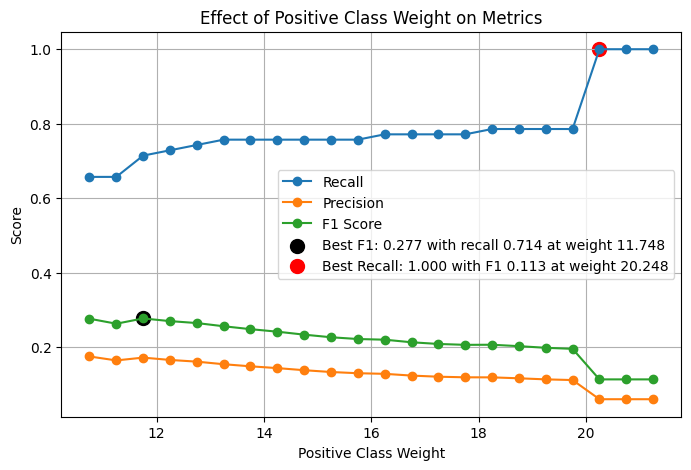

In [34]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

Je vais regarder autour du poids 13, puisque le recall semble ne pas augmenter après cette valeur et il offre une bonne balance avec le score précision et F1.

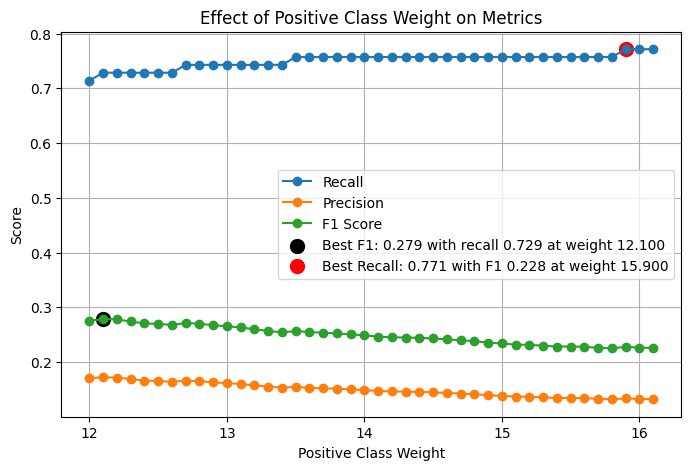

In [117]:
weights_to_test = np.arange(12, 16+0.1, 0.1)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

Je choisis le poids 13.5, il offre une bonne balance entre recal et F1 score

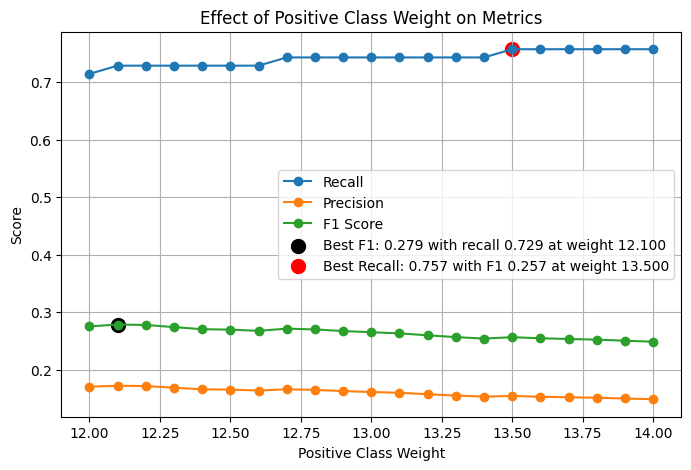

In [118]:
weights_to_test = np.arange(12, 14 + 0.1, 0.1)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

In [34]:
optimized_ratio = 13.5
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=optimized_ratio)
model = Model.Model(w, b, improvement="weight class optimization")
MODEL_FEAT1_WEIGHT_OPTI = "ModelFeat1WeightOptimization"
model_tracker.add(model, name=MODEL_FEAT1_WEIGHT_OPTI)

prevModel = model_tracker.get_by_name(MODEL_WITH_FEAT1_WEIGHT)
prevModel.print_stats(X_val_np, y_val_np)
print()
model.print_stats(X_val_np, y_val_np)


Iteration 0: Train cost = 1.2105
Iteration 100: Train cost = 1.0569
Iteration 200: Train cost = 1.0394
Iteration 300: Train cost = 1.0291
Iteration 400: Train cost = 1.0215
Iteration 500: Train cost = 1.0155
Iteration 600: Train cost = 1.0104
Iteration 700: Train cost = 1.0060
Iteration 800: Train cost = 1.0019
Iteration 900: Train cost = 0.9983
Model ModelFeat1WeightOptimization saved

Added class weight
AUC         : 0.7956
Precision   : 0.1299
Recall      : 0.7571
F1          : 0.2218
Threshold   : 0.5000
[[740 355]
 [ 17  53]]

weight class optimization
AUC         : 0.7955
Precision   : 0.1514
Recall      : 0.7571
F1          : 0.2524
Threshold   : 0.5000
[[798 297]
 [ 17  53]]


## 3.2.2 Learning rate

Le learning rate est les "steps" que le modèle prend pour atteindre le minimum du cost function. Un bon learning rate est celui qui converge rapidement et de manière stable (sans osciller) vers le minimum du cost function.

On peut voir que à partir d'un learning rate d'environ 0.015, la loss function commence a être instable.

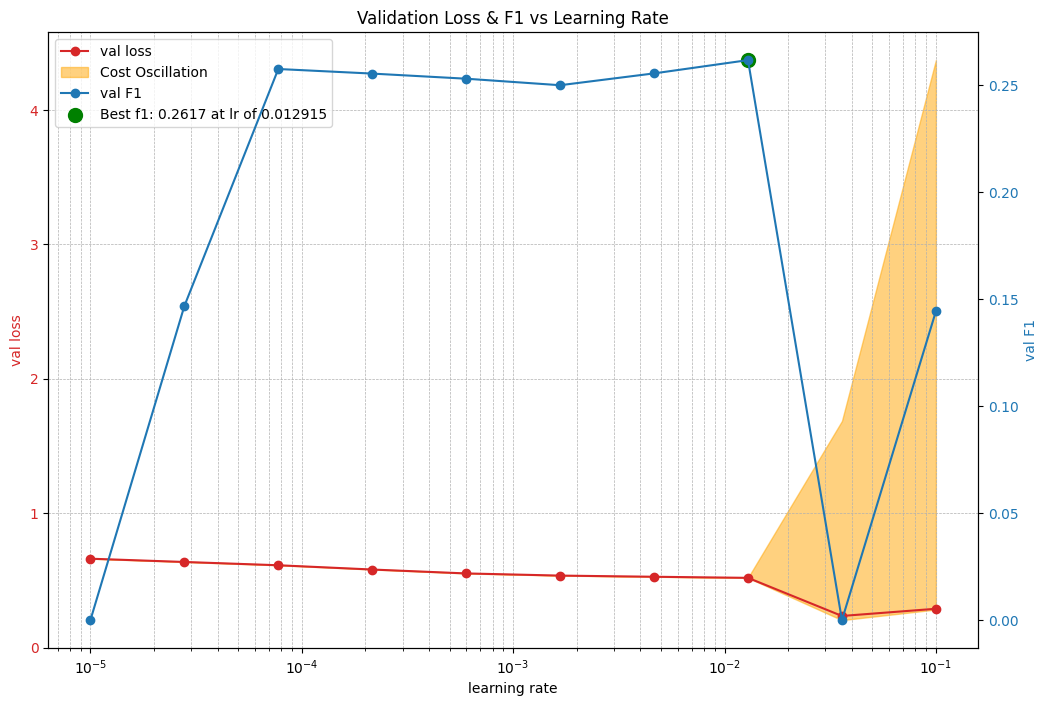

In [199]:
lrs = np.logspace(start=-5, stop=-1, num=10)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, plotF1=True, iterations=1000)

Si on cherche avant un learning rate de 0.015, la loss function devient plus stable. On peut voir aussi que celui qui offre le meilleur F1 est situé a un learning rate d'environ 0.000045.

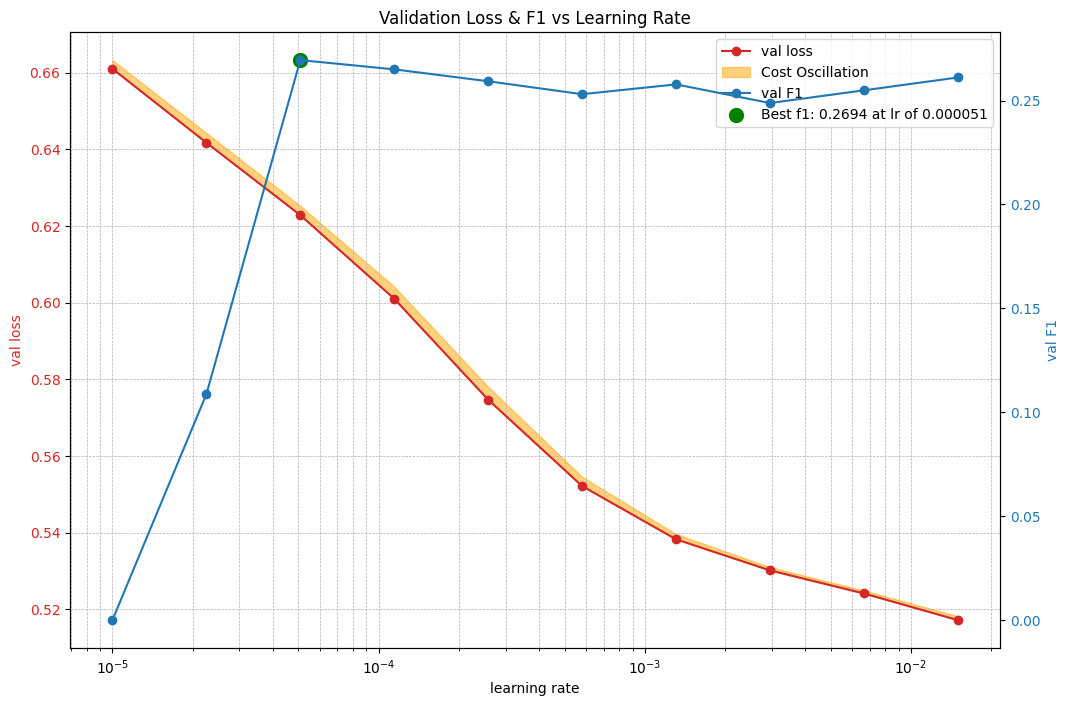

In [201]:
stop_value = np.log10(0.015)
lrs = np.logspace(start=-5, stop=stop_value, num=10)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, plotF1=True, iterations=1000)

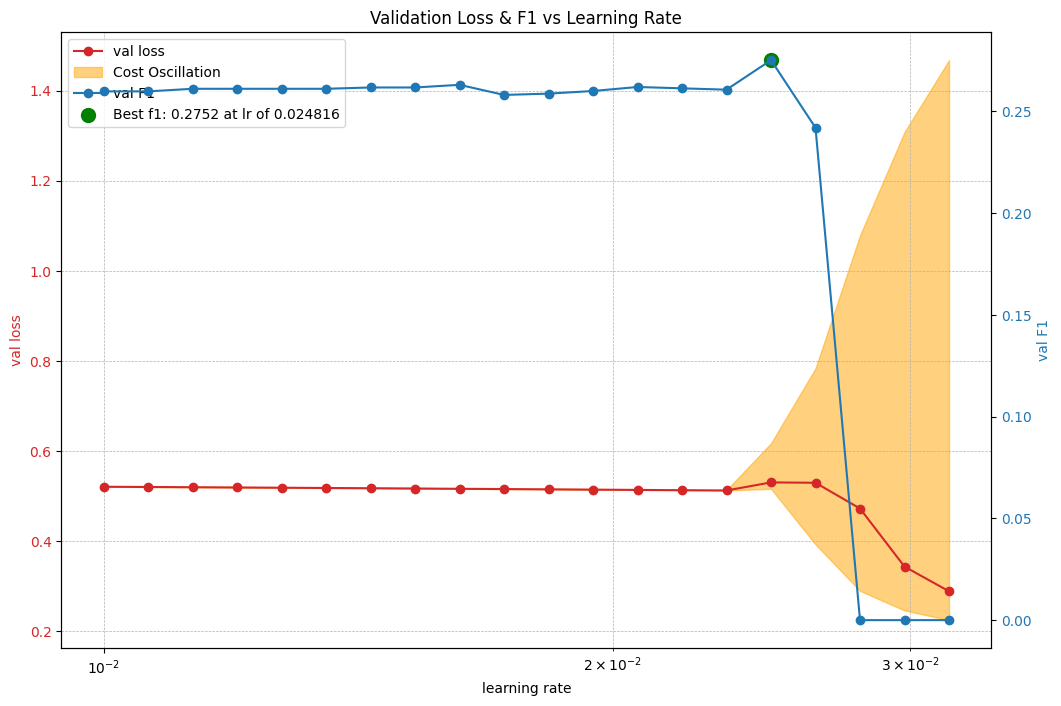

In [200]:
lrs = np.logspace(start=-2, stop=-1.5, num=20)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, plotF1=True, iterations=1000)

Un learning rate de 0.01 semble optimal, la loss function est basse et stable et le score F1 est proche du meilleure atteignable. 

In [35]:
learning_rate_optimized = 0.01

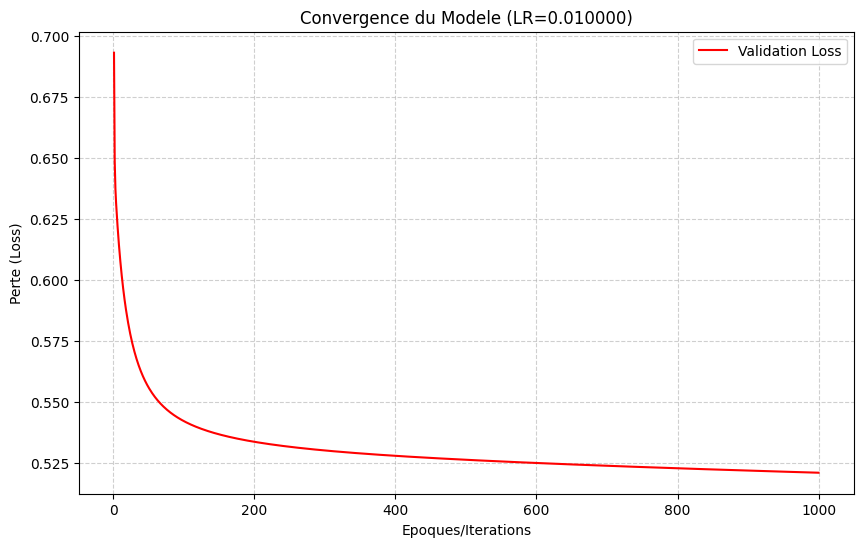

In [205]:
plot_tools.plot_convergence(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=learning_rate_optimized, epochs_max=1000, extra_weight=optimized_ratio, patience=100)

In [36]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, X_val_np, y_val_np, extra_weight=optimized_ratio, learning_rate=learning_rate_optimized, iterations=1000, to_print=False)
logisticRegression.print_model_stats(X_val_np, y_val_np, w, b)
print()
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w, b )
logisticRegression.print_model_stats(X_val_np, y_val_np, w, b, f1_threshold)

model = Model.Model(w,b,f1_threshold,improvement="Model V1") 
MODEL_V1 = "modelV1"
model_tracker.add(model, name=MODEL_V1)

AUC         : 0.7955
Precision   : 0.1514
Recall      : 0.7571
F1          : 0.2524
Threshold   : 0.5000
[[798 297]
 [ 17  53]]

AUC         : 0.7955
Precision   : 0.2373
Recall      : 0.4000
F1          : 0.2979
Threshold   : 0.6700
[[1005   90]
 [  42   28]]
Model modelV1 saved



In [40]:
X.columns

Index(['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR', 'MGODOV',
       'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV',
       ...
       'MAUT1_7_x_MHKOOP_6', 'MOSTYPE_1_x_MBERMIDD_2',
       'MOSTYPE_3_x_MBERARBO_2', 'MOSTYPE_12_x_MBERARBO_0',
       'MOSTYPE_12_x_MBERARBG_1', 'MOSTYPE_36_x_MBERMIDD_2',
       'MOSTYPE_1_x_MBERARBG_1', 'MOSTYPE_9_x_MBERARBG_1',
       'MOSTYPE_8_x_MBERZELF_1', 'MFWEKIND_5_x_MHKOOP_9'],
      dtype='object', length=176)

Je crois que le modèle a atteind sa limite, peu importe ce que j'optimise. Le score F1 tourne autour de 0.28-0.3.

In [37]:
y_pred= logisticRegression.predict(X_val_np, w, b, f1_threshold)

tp_indices = np.where((y_val_np == 1) & (y_pred == 1))[0]
fp_indices = np.where((y_val_np == 0) & (y_pred == 1))[0]
tn_indices = np.where((y_val_np == 0) & (y_pred == 0))[0]
fn_indices = np.where((y_val_np == 1) & (y_pred == 0))[0]
X_tp = X_val_np[tp_indices]
X_fp = X_val_np[fp_indices]
X_tn = X_val_np[tn_indices]
X_fn = X_val_np[fn_indices]
X_tp_df = pd.DataFrame(data=X_tp, columns=X_val.columns)
X_fp_df = pd.DataFrame(data=X_fp, columns=X_val.columns)
X_tn_df = pd.DataFrame(data=X_tn, columns=X_val.columns)
X_fn_df = pd.DataFrame(data=X_fn, columns=X_val.columns)

Si on observe les résultats obtenu on peut voir que le modèle priorise majoritairement l'économie du client pour le classer. En moyenne, tout ceux qui ont été classer en tant qu'acheteur d'assurance caravan sont ceux 
- Contribue le plus à leurs polices d'assurances (total_contribution) 
- Habite dans un endroit avec une plus grande concentration de home owner (MHKOOP) et de voiture (MAUT1)
- Ont complété un haut niveau d'étude (MOPLHOOG)
- Moins de bas niveau d'étude (MOPLLAAG) 
- Plus haut niveau de marriage (MRELGE)

Clairement, il classifie selon leur statut économique en premier

Si on observe seulement les TP, on peut voir un certain trait unique:
- Leur niveau d'éducation est majoritairement 'moyen' (MOPLMIDD) et peu de 'bas' (MOPLLAG)

Ensuite, si on regarde les FN et FP, on peut voir que les FP possède un haut niveau d'éducation "haut" (MOPLHOOG), mais les FN contient peu de MOPLHOOG. Si on regarde aussi MOPLLAAG et MOPLMIDD on peut voir qu'il y a une balance entre les deux pour les FN.


 
<style type="text/css">
#T_963df_row0_col1, #T_963df_row1_col2, #T_963df_row2_col1, #T_963df_row3_col2 {
  background-color: rgba(128, 0, 38, 1.0);
  color: black;
}
#T_963df_row0_col2 {
  background-color: rgba(220, 21, 29, 1.0);
  color: black;
}
#T_963df_row0_col3 {
  background-color: rgba(253, 157, 67, 1.0);
  color: black;
}
#T_963df_row0_col4 {
  background-color: rgba(228, 29, 28, 1.0);
  color: black;
}
#T_963df_row0_col5 {
  background-color: rgba(183, 0, 38, 1.0);
  color: black;
}
#T_963df_row0_col6, #T_963df_row1_col6, #T_963df_row2_col6, #T_963df_row3_col6 {
  background-color: rgba(255, 255, 204, 1.0);
  color: black;
}
#T_963df_row1_col1 {
  background-color: rgba(212, 16, 31, 1.0);
  color: black;
}
#T_963df_row1_col3 {
  background-color: rgba(246, 67, 39, 1.0);
  color: black;
}
#T_963df_row1_col4 {
  background-color: rgba(207, 12, 33, 1.0);
  color: black;
}
#T_963df_row1_col5 {
  background-color: rgba(177, 0, 38, 1.0);
  color: black;
}
#T_963df_row2_col2 {
  background-color: rgba(152, 0, 38, 1.0);
  color: black;
}
#T_963df_row2_col3 {
  background-color: rgba(252, 140, 59, 1.0);
  color: black;
}
#T_963df_row2_col4 {
  background-color: rgba(205, 11, 33, 1.0);
  color: black;
}
#T_963df_row2_col5 {
  background-color: rgba(139, 0, 38, 1.0);
  color: black;
}
#T_963df_row3_col1 {
  background-color: rgba(253, 175, 74, 1.0);
  color: black;
}
#T_963df_row3_col3 {
  background-color: rgba(254, 214, 115, 1.0);
  color: black;
}
#T_963df_row3_col4 {
  background-color: rgba(252, 116, 52, 1.0);
  color: black;
}
#T_963df_row3_col5 {
  background-color: rgba(238, 49, 34, 1.0);
  color: black;
}
</style>
<table id="T_963df" style="border-collapse:collapse; width:80%;">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_963df_level0_col0" class="col_heading level0 col0" >Category</th>
      <th id="T_963df_level0_col1" class="col_heading level0 col1" >MOPLLAAG</th>
      <th id="T_963df_level0_col2" class="col_heading level0 col2" >MOPLMIDD</th>
      <th id="T_963df_level0_col3" class="col_heading level0 col3" >MOPLHOOG</th>
      <th id="T_963df_level0_col4" class="col_heading level0 col4" >Moyenne</th>
      <th id="T_963df_level0_col5" class="col_heading level0 col5" >Moyenne_2</th>
      <th id="T_963df_level0_col6" class="col_heading level0 col6" >Diff_MID_LLAAG</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_963df_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_963df_row0_col0" class="data row0 col0" >TN</td>
      <td id="T_963df_row0_col1" class="data row0 col1" >4.723320</td>
      <td id="T_963df_row0_col2" class="data row0 col2" >3.329051</td>
      <td id="T_963df_row0_col3" class="data row0 col3" >1.328063</td>
      <td id="T_963df_row0_col4" class="data row0 col4" >3.126812</td>
      <td id="T_963df_row0_col5" class="data row0 col5" >4.026186</td>
      <td id="T_963df_row0_col6" class="data row0 col6" >-1.394269</td>
    </tr>
    <tr>
      <th id="T_963df_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_963df_row1_col0" class="data row1 col0" >FP</td>
      <td id="T_963df_row1_col1" class="data row1 col1" >3.096386</td>
      <td id="T_963df_row1_col2" class="data row1 col2" >3.734940</td>
      <td id="T_963df_row1_col3" class="data row1 col3" >2.650602</td>
      <td id="T_963df_row1_col4" class="data row1 col4" >3.160643</td>
      <td id="T_963df_row1_col5" class="data row1 col5" >3.415663</td>
      <td id="T_963df_row1_col6" class="data row1 col6" >0.638554</td>
    </tr>
    <tr>
      <th id="T_963df_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_963df_row2_col0" class="data row2 col0" >FN</td>
      <td id="T_963df_row2_col1" class="data row2 col1" >3.860465</td>
      <td id="T_963df_row2_col2" class="data row2 col2" >3.651163</td>
      <td id="T_963df_row2_col3" class="data row2 col3" >1.837209</td>
      <td id="T_963df_row2_col4" class="data row2 col4" >3.116279</td>
      <td id="T_963df_row2_col5" class="data row2 col5" >3.755814</td>
      <td id="T_963df_row2_col6" class="data row2 col6" >-0.209302</td>
    </tr>
    <tr>
      <th id="T_963df_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_963df_row3_col0" class="data row3 col0" >TP</td>
      <td id="T_963df_row3_col1" class="data row3 col1" >2.703704</td>
      <td id="T_963df_row3_col2" class="data row3 col2" >4.370370</td>
      <td id="T_963df_row3_col3" class="data row3 col3" >2.370370</td>
      <td id="T_963df_row3_col4" class="data row3 col4" >3.148148</td>
      <td id="T_963df_row3_col5" class="data row3 col5" >3.537037</td>
      <td id="T_963df_row3_col6" class="data row3 col6" >1.666667</td>
    </tr>
  </tbody>
</table>




Donc, les acheteurs d'assurance caravan ont un moyenne d'éducation "moyen"
- $\star$ Les FN ont aussi un niveau d'éducation moyen avec un mélange de bas. Créer une colonne "moyenne d'éducation moyen et bas" pourrait aider le modèle ou différence d'éducation.



<style type="text/css">
#T_8d02d_row0_col1 {
  background-color: rgba(254, 233, 151, 1.0);
  color: black;
}
#T_8d02d_row0_col2 {
  background-color: rgba(254, 232, 150, 1.0);
  color: black;
}
#T_8d02d_row0_col3 {
  background-color: rgba(253, 157, 67, 1.0);
  color: black;
}
#T_8d02d_row0_col4, #T_8d02d_row1_col4, #T_8d02d_row2_col4, #T_8d02d_row3_col4 {
  background-color: rgba(128, 0, 38, 1.0);
  color: black;
}
#T_8d02d_row0_col5, #T_8d02d_row1_col5, #T_8d02d_row2_col5, #T_8d02d_row3_col5 {
  background-color: rgba(255, 255, 204, 1.0);
  color: black;
}
#T_8d02d_row0_col6 {
  background-color: rgba(254, 186, 84, 1.0);
  color: black;
}
#T_8d02d_row0_col7 {
  background-color: rgba(252, 124, 55, 1.0);
  color: black;
}
#T_8d02d_row0_col8, #T_8d02d_row2_col2 {
  background-color: rgba(254, 202, 101, 1.0);
  color: black;
}
#T_8d02d_row1_col1 {
  background-color: rgba(249, 73, 40, 1.0);
  color: black;
}
#T_8d02d_row1_col2 {
  background-color: rgba(252, 134, 58, 1.0);
  color: black;
}
#T_8d02d_row1_col3 {
  background-color: rgba(252, 86, 44, 1.0);
  color: black;
}
#T_8d02d_row1_col6 {
  background-color: rgba(252, 114, 52, 1.0);
  color: black;
}
#T_8d02d_row1_col7 {
  background-color: rgba(235, 42, 32, 1.0);
  color: black;
}
#T_8d02d_row1_col8 {
  background-color: rgba(252, 110, 51, 1.0);
  color: black;
}
#T_8d02d_row2_col1 {
  background-color: rgba(252, 116, 52, 1.0);
  color: black;
}
#T_8d02d_row2_col3 {
  background-color: rgba(245, 63, 38, 1.0);
  color: black;
}
#T_8d02d_row2_col6 {
  background-color: rgba(252, 140, 59, 1.0);
  color: black;
}
#T_8d02d_row2_col7 {
  background-color: rgba(246, 67, 39, 1.0);
  color: black;
}
#T_8d02d_row2_col8 {
  background-color: rgba(253, 147, 62, 1.0);
  color: black;
}
#T_8d02d_row3_col1 {
  background-color: rgba(226, 25, 28, 1.0);
  color: black;
}
#T_8d02d_row3_col2 {
  background-color: rgba(222, 22, 29, 1.0);
  color: black;
}
#T_8d02d_row3_col3 {
  background-color: rgba(204, 10, 33, 1.0);
  color: black;
}
#T_8d02d_row3_col6 {
  background-color: rgba(243, 60, 37, 1.0);
  color: black;
}
#T_8d02d_row3_col7 {
  background-color: rgba(192, 2, 37, 1.0);
  color: black;
}
#T_8d02d_row3_col8 {
  background-color: rgba(212, 16, 31, 1.0);
  color: black;
}
</style>
<table id="T_8d02d" style="border-collapse:collapse; width:90%;">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_8d02d_level0_col0" class="col_heading level0 col0" >Category</th>
      <th id="T_8d02d_level0_col1" class="col_heading level0 col1" >MSKA</th>
      <th id="T_8d02d_level0_col2" class="col_heading level0 col2" >MSKB1</th>
      <th id="T_8d02d_level0_col3" class="col_heading level0 col3" >MSKB2</th>
      <th id="T_8d02d_level0_col4" class="col_heading level0 col4" >MSKC</th>
      <th id="T_8d02d_level0_col5" class="col_heading level0 col5" >MSKD</th>
      <th id="T_8d02d_level0_col6" class="col_heading level0 col6" >Moyenne</th>
      <th id="T_8d02d_level0_col7" class="col_heading level0 col7" >Moyenne_B1B2C</th>
      <th id="T_8d02d_level0_col8" class="col_heading level0 col8" >Moyenne_B1B2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_8d02d_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_8d02d_row0_col0" class="data row0 col0" >TN</td>
      <td id="T_8d02d_row0_col1" class="data row0 col1" >1.522727</td>
      <td id="T_8d02d_row0_col2" class="data row0 col2" >1.537549</td>
      <td id="T_8d02d_row0_col3" class="data row0 col3" >2.304348</td>
      <td id="T_8d02d_row0_col4" class="data row0 col4" >3.787549</td>
      <td id="T_8d02d_row0_col5" class="data row0 col5" >1.121542</td>
      <td id="T_8d02d_row0_col6" class="data row0 col6" >2.054743</td>
      <td id="T_8d02d_row0_col7" class="data row0 col7" >2.543149</td>
      <td id="T_8d02d_row0_col8" class="data row0 col8" >1.920949</td>
    </tr>
    <tr>
      <th id="T_8d02d_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_8d02d_row1_col0" class="data row1 col0" >FP</td>
      <td id="T_8d02d_row1_col1" class="data row1 col1" >2.240964</td>
      <td id="T_8d02d_row1_col2" class="data row1 col2" >1.915663</td>
      <td id="T_8d02d_row1_col3" class="data row1 col3" >2.168675</td>
      <td id="T_8d02d_row1_col4" class="data row1 col4" >3.216867</td>
      <td id="T_8d02d_row1_col5" class="data row1 col5" >0.542169</td>
      <td id="T_8d02d_row1_col6" class="data row1 col6" >2.016867</td>
      <td id="T_8d02d_row1_col7" class="data row1 col7" >2.433735</td>
      <td id="T_8d02d_row1_col8" class="data row1 col8" >2.042169</td>
    </tr>
    <tr>
      <th id="T_8d02d_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_8d02d_row2_col0" class="data row2 col0" >FN</td>
      <td id="T_8d02d_row2_col1" class="data row2 col1" >2.186047</td>
      <td id="T_8d02d_row2_col2" class="data row2 col2" >1.418605</td>
      <td id="T_8d02d_row2_col3" class="data row2 col3" >2.511628</td>
      <td id="T_8d02d_row2_col4" class="data row2 col4" >3.558140</td>
      <td id="T_8d02d_row2_col5" class="data row2 col5" >0.511628</td>
      <td id="T_8d02d_row2_col6" class="data row2 col6" >2.037209</td>
      <td id="T_8d02d_row2_col7" class="data row2 col7" >2.496124</td>
      <td id="T_8d02d_row2_col8" class="data row2 col8" >1.965116</td>
    </tr>
    <tr>
      <th id="T_8d02d_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_8d02d_row3_col0" class="data row3 col0" >TP</td>
      <td id="T_8d02d_row3_col1" class="data row3 col1" >2.222222</td>
      <td id="T_8d02d_row3_col2" class="data row3 col2" >2.259259</td>
      <td id="T_8d02d_row3_col3" class="data row3 col3" >2.407407</td>
      <td id="T_8d02d_row3_col4" class="data row3 col4" >2.851852</td>
      <td id="T_8d02d_row3_col5" class="data row3 col5" >0.333333</td>
      <td id="T_8d02d_row3_col6" class="data row3 col6" >2.014815</td>
      <td id="T_8d02d_row3_col7" class="data row3 col7" >2.506173</td>
      <td id="T_8d02d_row3_col8" class="data row3 col8" >2.333333</td>
    </tr>
  </tbody>
</table>


<table border="1" style="border-collapse:collapse; width:100%; text-align:center;">
  <thead>
    <tr>
      <th>Catégorie</th>
      <th>MRELGE</th>
      <th>MAUT1</th>
      <th>total_contribution</th>
      <th>MHKOOP</th>
      <th>MKOOPKLA</th>
      <th>PBRAND</th>
      <th>MFWEKIND</th>
      <th>PPERSAUT</th>
      <th>MOPLLAAG</th>
      <th>MOPLMIDD</th>
      <th>MOPLHOOG</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>True Negatives (TN)</strong><br>Count: 1012</td>
      <td>6.093874</td>
      <td>5.884387</td>
      <td>5.877470</td>
      <td>4.562253</td>
      <td>4.084980</td>
      <td>1.687747</td>
      <td>4.258893</td>
      <td>2.537549</td>
      <td>4.723320</td>
      <td>3.329051</td>
      <td>1.328063</td>
    </tr>
    <tr>
      <td><strong>False Positives (FP)</strong><br>Count: 83</td>
      <td>7.325301</td>
      <td>7.072289</td>
      <td>12.204819</td>
      <td>6.795181</td>
      <td>5.698795</td>
      <td>3.204819</td>
      <td>5.036145</td>
      <td>5.963855</td>
      <td>3.096386</td>
      <td>3.819277</td>
      <td>2.650602</td>
    </tr>
    <tr>
      <td><strong>False Negatives (FN)</strong><br>Count: 43</td>
      <td>6.604651</td>
      <td>6.372093</td>
      <td>8.674419</td>
      <td>5.046512</td>
      <td>4.813953</td>
      <td>2.162791</td>
      <td>4.465116</td>
      <td>4.534884</td>
      <td>3.860465</td>
      <td>3.651163</td>
      <td>1.837209</td>
    </tr>
    <tr>
      <td><strong>True Positives (TP)</strong><br>Count: 27</td>
      <td>7.333333</td>
      <td>6.888889</td>
      <td>13.259259</td>
      <td>7.370370</td>
      <td>6.185185</td>
      <td>3.962963</td>
      <td>5.037037</td>
      <td>6.000000</td>
      <td>2.703704</td>
      <td>4.370370</td>
      <td>2.370370</td>
    </tr>
  </tbody>
</table>


In [280]:
profile_tp = X_tp_df.mean().sort_values(ascending=False)
profile_fp = X_fp_df.mean().sort_values(ascending=False)
profile_tn = X_tn_df.mean().sort_values(ascending=False)
profile_fn = X_fn_df.mean().sort_values(ascending=False)

tp_html = profile_tp.head(10).to_frame().to_html()
fp_html = profile_fp.head(10).to_frame().to_html()
tn_html = profile_tn.head(10).to_frame().to_html()
fn_html = profile_fn.head(10).to_frame().to_html()

HTML(f"""
<div style="display:flex; gap:20px; flex-wrap:wrap">

    <div>
        <h3 style="text-align:center;">True Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tn_df)}</p>
        {tn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fn_df)}</p>
        {fn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fp_df)}</p>
        {fp_html}
    </div>

    <div>
        <h3 style="text-align:center;">True Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tp_df)}</p>
        {tp_html}
    </div>

</div>
""")

,0
MRELGE,6.091089
MAUT1,5.881188
MOPLLAAG,4.727723
MGODPR,4.581188
MHKOOP,4.559406
MFWEKIND,4.261386
MKOOPKLA,4.091089
MSKC,3.792079
MOPLMIDD,3.327723
MGODGE,3.318812


Je vais commencer par ajouter  différence d'éducation, voir la différence que sa fait

In [38]:
X = data_tracker.get(DATA_V1)
feature_tracker.set_df(X)

In [39]:
diff_educ_mid_bas = X['MOPLMIDD'] - X['MOPLLAAG']
feature_tracker.add('diff_educ_mid_bas', diff_educ_mid_bas, toScale=True)
feature_tracker.remove('MOPLMIDD')
feature_tracker.remove('MOPLLAAG')

In [43]:
feature_tracker.to_remove_cols

['total_recreational_policies',
 'APLEZIER',
 'AFIETS',
 'AZEILPL',
 'total_recreational_contribution',
 'PPLEZIER',
 'PFIETS',
 'PZEILPL',
 'MINKM30',
 'MINK3045',
 'MINK4575',
 'MINK7512',
 'MINK123M',
 'MINKGEM',
 'MHHUUR',
 'MZFONDS',
 'AWAPART',
 'AWALAND',
 'AAANHANG',
 'ABROM',
 'AGEZONG',
 'ABYSTAND',
 'ratio_motorized_policies',
 'MOSTYPE_8_x_MBERBOER_0',
 'MOSTYPE_12_x_MBERBOER_0',
 'MOPLMIDD',
 'MOPLLAAG']

In [40]:
X = feature_tracker.flush_to_df()

DATA_V2 = "Feature_Engineering_v2"
data_tracker.add(DATA_V2, X.copy())

X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()

Dataset Feature_Engineering_v2 saved.



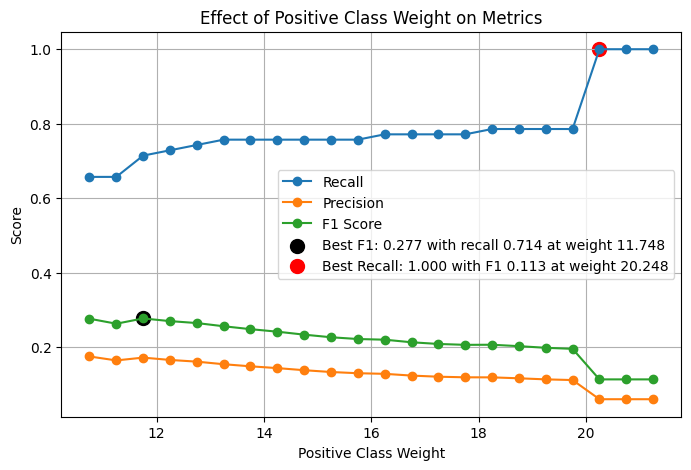

In [40]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

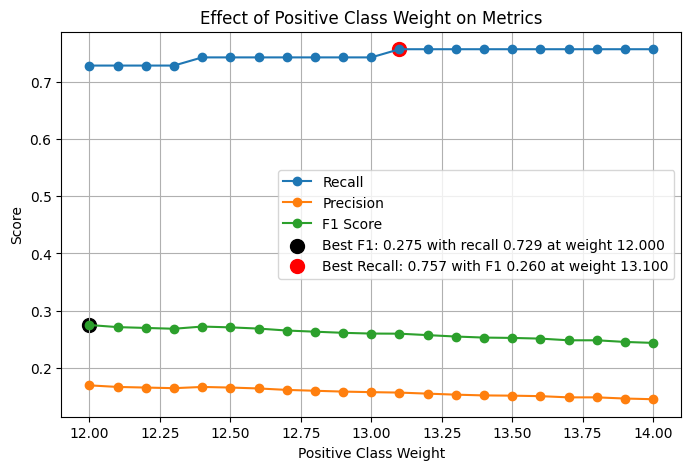

In [220]:
weights_to_test = np.arange(12, 14 + 0.1, 0.1)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

In [41]:
optimized_ratio = 13.1

Pas besoin de changer le learning rate pour l'instant

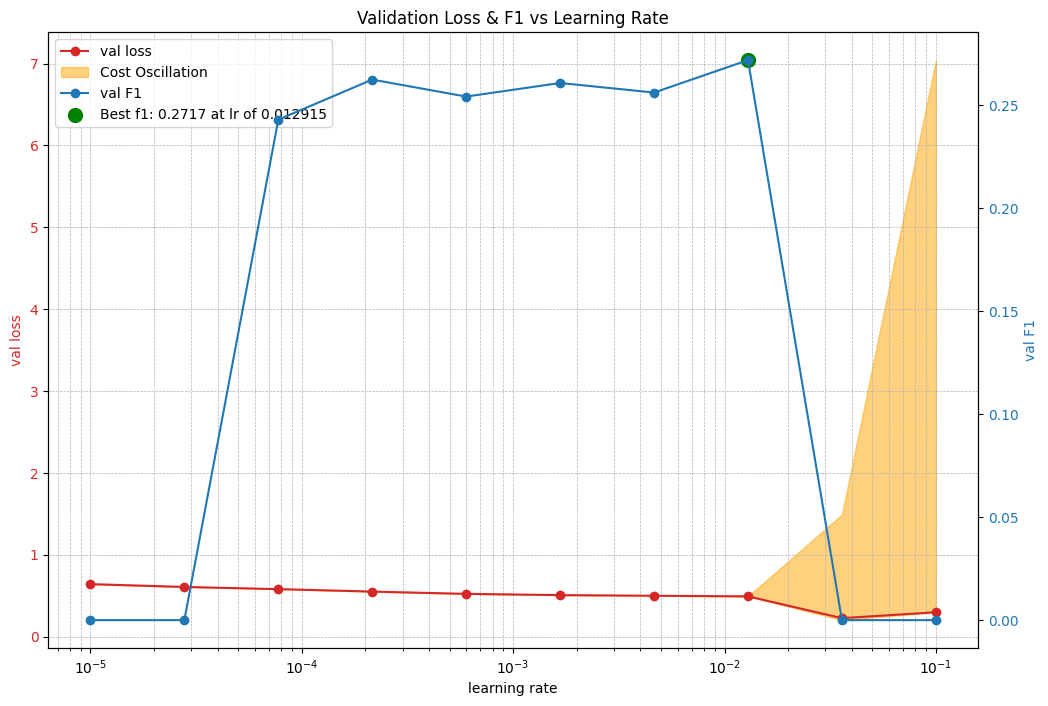

In [229]:
lrs = np.logspace(start=-5, stop=-1, num=10)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, plotF1=True, iterations=1000)

L2 Reg

In [42]:
lambdas = np.array([200, 250, 300, 350, 400, 450, 500])
lambda_const = logisticRegression.find_best_lambda(lambdas, X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=learning_rate_optimized, extra_weight=optimized_ratio, iterations=1000)

Lambda: 200.000000 | Best T: 0.680 | F1: 0.3200
Lambda: 250.000000 | Best T: 0.680 | F1: 0.3217
Lambda: 300.000000 | Best T: 0.680 | F1: 0.3239
Lambda: 350.000000 | Best T: 0.680 | F1: 0.3262
Lambda: 400.000000 | Best T: 0.670 | F1: 0.3129
Lambda: 450.000000 | Best T: 0.670 | F1: 0.3172
Lambda: 500.000000 | Best T: 0.670 | F1: 0.3099

Best lambda: 350
Best threshold: 0.680
Best F1: 0.3262


In [46]:
w, b = logisticRegression.logistic_regression(
    X_train_np, y_train_np, X_val_np, y_val_np, 
    learning_rate=learning_rate_optimized, 
    extra_weight=optimized_ratio,
    iterations=1000,
    l2_reg=True, lambda_const=lambda_const)
f1_threshold_2, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w, b)
model = Model.Model(w,b, threshold=f1_threshold_2, improvement="Added diff mid-low educ")
MODEL_V1_1_DIFF_EDUC = "ModelV1_with_diff_educ"
model_tracker.add(model, name=MODEL_V1_1_DIFF_EDUC)

logisticRegression.print_model_stats(X_val_np, y_val_np, w,b, f1_threshold_2)

Iteration 0: Train cost = 1.1939 | Val cos =  0.6931
Iteration 100: Train cost = 1.0480 | Val cos =  0.5552
Iteration 200: Train cost = 1.0329 | Val cos =  0.5521
Iteration 300: Train cost = 1.0249 | Val cos =  0.5533
Early stopping a l'iteration 396. Best Loss: 0.552088
Model ModelV1_with_diff_educ existe deja, overriding...
Model ModelV1_with_diff_educ saved

AUC         : 0.7986
Precision   : 0.3239
Recall      : 0.3286
F1          : 0.3262
Threshold   : 0.6800
[[1047   48]
 [  47   23]]


Si on compare aux variables précédentes on a [...]

In [47]:
X_old = data_tracker.get(DATA_V1)
notToRemove = []
for c in X_old.columns:
    if c not in X.columns: notToRemove.append(c)

X_train_old_np, y_train_old_np, X_val_old_np, y_val_old_np = feature_tracker.return_split_train_eval(X_old, notToRemove=notToRemove, toNpy=True)

prevModel = model_tracker.get_by_name(MODEL_V1)

print("Model V1 on old data:")
logisticRegression.print_model_stats(X_val_old_np, y_val_old_np, prevModel.w, prevModel.b, prevModel.threshold)

print("\nModel V1.1 with diff educ:")
logisticRegression.print_model_stats(X_val_np, y_val_np, model.w, model.b, model.threshold)


Model V1 on old data:
AUC         : 0.7955
Precision   : 0.2373
Recall      : 0.4000
F1          : 0.2979
Threshold   : 0.6700
[[1005   90]
 [  42   28]]

Model V1.1 with diff educ:
AUC         : 0.7986
Precision   : 0.3239
Recall      : 0.3286
F1          : 0.3262
Threshold   : 0.6800
[[1047   48]
 [  47   23]]


Comme vu précédement, le modèle est probablement en train de classifier les acheteurs selon leurs richesses. 

In [41]:
y_pred= logisticRegression.predict(X_val_np, w, b, model.threshold)

tp_indices = np.where((y_val_np == 1) & (y_pred == 1))[0]
fp_indices = np.where((y_val_np == 0) & (y_pred == 1))[0]
tn_indices = np.where((y_val_np == 0) & (y_pred == 0))[0]
fn_indices = np.where((y_val_np == 1) & (y_pred == 0))[0]
X_tp = X_val_np[tp_indices]
X_fp = X_val_np[fp_indices]
X_tn = X_val_np[tn_indices]
X_fn = X_val_np[fn_indices]
X_tp_df = pd.DataFrame(data=X_tp, columns=X_val.columns)
X_fp_df = pd.DataFrame(data=X_fp, columns=X_val.columns)
X_tn_df = pd.DataFrame(data=X_tn, columns=X_val.columns)
X_fn_df = pd.DataFrame(data=X_fn, columns=X_val.columns)

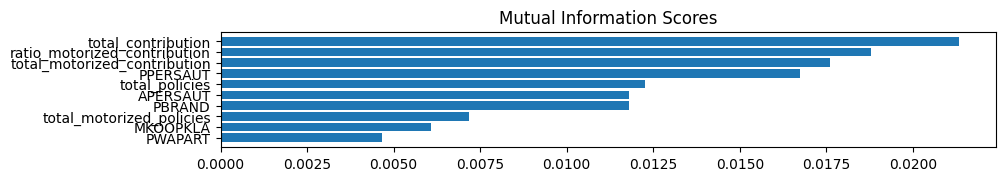

In [ ]:
discrete_features = X.drop('CARAVAN', axis=1).dtypes == int
mi = FeatureTools.make_mi_scores(X.drop('CARAVAN', axis=1), X['CARAVAN'], discrete_features)
mi = mi[mi > 0.001]
FeatureTools.plot_mi_scores(mi.head(10))

On peut voir que la grande majorité des FN et TP ont une total_contribution > 10. Aussi selon le score Mutual information, total_contribution est celui qui a scorer le plus haut. Le modèle est peut-etre biaiser pour eux.

C'est probablement un des problèmes, si on regarde le graphique ci-dessous, on voit que les FN possède une contribution plus basse en général.

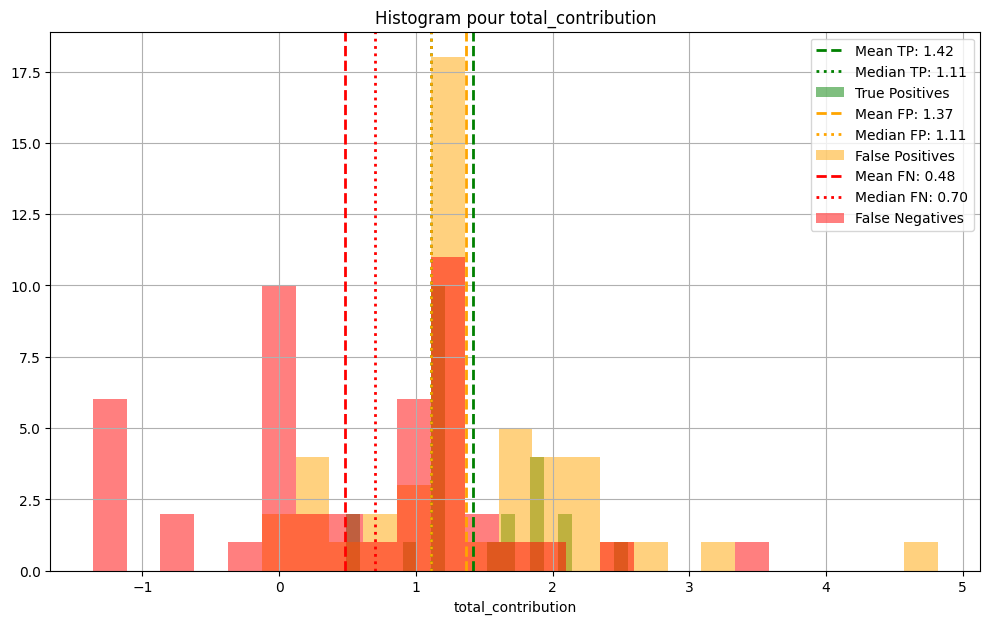

In [43]:
var_to_check = 'total_contribution'
plot_tools.plot_hist_comparison(var_to_check, X_tp_df, X_fp_df, X_fn_df)

Ce qui pourrais etre utile, est de trouver un moyen de booster les probabilités de ces personnes mais avec quelque chose qui n'est pas relier à leur aspect finance.

FP et TP : 
- total_contribution élevé
- MHKOOP élevé
- diff_educ_mid_bas élevé
- MFWEKIND élevé
- MRELGE élevé
- Majoritairement Protestant et catholique

Le modèle priorise ceux qui possède les caractéristiques au dessus.

FN : 
- En général, représente le contraire des FP et TP
- En général, les FN possède les caractéristiques des FP et TP légèrement plus haut que les TN
- MRELSA élevé
- MFGEKIND élevé
- MGODGE élevé
- MRELOV élevé

On peut voir que les FN représente un peu le contraire des FP et TP, mais possède quand mais possède quand même un plus haut taux de total_contribution, MHKOOP, diff_educ_mid_bas, MFWEKIND, MRELGE que les TN.
Donc je crois que créer une nouvelle variable qui multiplie les caractéristiques des FN devrait aider les prédictions du modèles.

<style type="text/css">
#T_f98c0_row0_col0, #T_f98c0_row1_col0, #T_f98c0_row2_col0, #T_f98c0_row3_col2, #T_f98c0_row4_col2, #T_f98c0_row5_col0, #T_f98c0_row6_col2, #T_f98c0_row7_col0, #T_f98c0_row8_col2, #T_f98c0_row9_col0, #T_f98c0_row10_col1 {
  background-color: rgba(255, 255, 204, 1.00);
  color: black;
}
#T_f98c0_row0_col1 {
  background-color: rgba(253, 172, 73, 1.00);
  color: black;
}
#T_f98c0_row0_col2 {
  background-color: rgba(141, 0, 38, 1.00);
  color: black;
}
#T_f98c0_row0_col3, #T_f98c0_row1_col2, #T_f98c0_row2_col3, #T_f98c0_row3_col0, #T_f98c0_row4_col1, #T_f98c0_row5_col2, #T_f98c0_row6_col0, #T_f98c0_row7_col2, #T_f98c0_row8_col0, #T_f98c0_row9_col2, #T_f98c0_row10_col2 {
  background-color: rgba(128, 0, 38, 1.00);
  color: black;
}
#T_f98c0_row1_col1 {
  background-color: rgba(254, 231, 149, 1.00);
  color: black;
}
#T_f98c0_row1_col3 {
  background-color: rgba(162, 0, 38, 1.00);
  color: black;
}
#T_f98c0_row2_col1 {
  background-color: rgba(254, 179, 78, 1.00);
  color: black;
}
#T_f98c0_row2_col2 {
  background-color: rgba(135, 0, 38, 1.00);
  color: black;
}
#T_f98c0_row3_col1 {
  background-color: rgba(252, 130, 56, 1.00);
  color: black;
}
#T_f98c0_row3_col3 {
  background-color: rgba(234, 41, 32, 1.00);
  color: black;
}
#T_f98c0_row4_col0 {
  background-color: rgba(252, 138, 59, 1.00);
  color: black;
}
#T_f98c0_row4_col3 {
  background-color: rgba(253, 148, 63, 1.00);
  color: black;
}
#T_f98c0_row5_col1 {
  background-color: rgba(255, 242, 172, 1.00);
  color: black;
}
#T_f98c0_row5_col3 {
  background-color: rgba(224, 24, 28, 1.00);
  color: black;
}
#T_f98c0_row6_col1 {
  background-color: rgba(156, 0, 38, 1.00);
  color: black;
}
#T_f98c0_row6_col3 {
  background-color: rgba(254, 218, 120, 1.00);
  color: black;
}
#T_f98c0_row7_col1 {
  background-color: rgba(254, 183, 82, 1.00);
  color: black;
}
#T_f98c0_row7_col3 {
  background-color: rgba(150, 0, 38, 1.00);
  color: black;
}
#T_f98c0_row8_col1 {
  background-color: rgba(246, 65, 38, 1.00);
  color: black;
}
#T_f98c0_row8_col3 {
  background-color: rgba(255, 252, 198, 1.00);
  color: black;
}
#T_f98c0_row9_col1 {
  background-color: rgba(253, 164, 70, 1.00);
  color: black;
}
#T_f98c0_row9_col3 {
  background-color: rgba(212, 16, 31, 1.00);
  color: black;
}
#T_f98c0_row10_col0 {
  background-color: rgba(255, 249, 190, 1.00);
  color: black;
}
#T_f98c0_row10_col3 {
  background-color: rgba(233, 39, 31, 1.00);
  color: black;
}
</style>
<table id="T_f98c0" style="border-collapse:collapse; width:60%;">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_f98c0_level0_col0" class="col_heading level0 col0" >TN</th>
      <th id="T_f98c0_level0_col1" class="col_heading level0 col1" >FN</th>
      <th id="T_f98c0_level0_col2" class="col_heading level0 col2" >FP</th>
      <th id="T_f98c0_level0_col3" class="col_heading level0 col3" >TP</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_f98c0_level0_row0" class="row_heading level0 row0" >total_contribution</th>
      <td id="T_f98c0_row0_col0" class="data row0 col0" >-0.117792</td>
      <td id="T_f98c0_row0_col1" class="data row0 col1" >0.483330</td>
      <td id="T_f98c0_row0_col2" class="data row0 col2" >1.368109</td>
      <td id="T_f98c0_row0_col3" class="data row0 col3" >1.415158</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row1" class="row_heading level0 row1" >MHKOOP</th>
      <td id="T_f98c0_row1_col0" class="data row1 col0" >4.586437</td>
      <td id="T_f98c0_row1_col1" class="data row1 col1" >5.106383</td>
      <td id="T_f98c0_row1_col2" class="data row1 col2" >7.895833</td>
      <td id="T_f98c0_row1_col3" class="data row1 col3" >7.652174</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row2" class="row_heading level0 row2" >diff_educ_mid_bas</th>
      <td id="T_f98c0_row2_col0" class="data row2 col0" >-0.036527</td>
      <td id="T_f98c0_row2_col1" class="data row2 col1" >0.279670</td>
      <td id="T_f98c0_row2_col2" class="data row2 col2" >0.807882</td>
      <td id="T_f98c0_row2_col3" class="data row2 col3" >0.823244</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row3" class="row_heading level0 row3" >MRELSA</th>
      <td id="T_f98c0_row3_col0" class="data row3 col0" >0.871060</td>
      <td id="T_f98c0_row3_col1" class="data row3 col1" >0.723404</td>
      <td id="T_f98c0_row3_col2" class="data row3 col2" >0.562500</td>
      <td id="T_f98c0_row3_col3" class="data row3 col3" >0.782609</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row4" class="row_heading level0 row4" >MFGEKIND</th>
      <td id="T_f98c0_row4_col0" class="data row4 col0" >3.238777</td>
      <td id="T_f98c0_row4_col1" class="data row4 col1" >3.595745</td>
      <td id="T_f98c0_row4_col2" class="data row4 col2" >2.875000</td>
      <td id="T_f98c0_row4_col3" class="data row4 col3" >3.217391</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row5" class="row_heading level0 row5" >MFWEKIND</th>
      <td id="T_f98c0_row5_col0" class="data row5 col0" >4.256925</td>
      <td id="T_f98c0_row5_col1" class="data row5 col1" >4.382979</td>
      <td id="T_f98c0_row5_col2" class="data row5 col2" >5.645833</td>
      <td id="T_f98c0_row5_col3" class="data row5 col3" >5.304348</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row6" class="row_heading level0 row6" >MGODGE</th>
      <td id="T_f98c0_row6_col0" class="data row6 col0" >3.312321</td>
      <td id="T_f98c0_row6_col1" class="data row6 col1" >3.234043</td>
      <td id="T_f98c0_row6_col2" class="data row6 col2" >1.979167</td>
      <td id="T_f98c0_row6_col3" class="data row6 col3" >2.304348</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row7" class="row_heading level0 row7" >MRELGE</th>
      <td id="T_f98c0_row7_col0" class="data row7 col0" >6.127030</td>
      <td id="T_f98c0_row7_col1" class="data row7 col1" >6.617021</td>
      <td id="T_f98c0_row7_col2" class="data row7 col2" >7.500000</td>
      <td id="T_f98c0_row7_col3" class="data row7 col3" >7.434783</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row8" class="row_heading level0 row8" >MRELOV</th>
      <td id="T_f98c0_row8_col0" class="data row8 col0" >2.368672</td>
      <td id="T_f98c0_row8_col1" class="data row8 col1" >1.914894</td>
      <td id="T_f98c0_row8_col2" class="data row8 col2" >1.062500</td>
      <td id="T_f98c0_row8_col3" class="data row8 col3" >1.086957</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row9" class="row_heading level0 row9" >MGODPR</th>
      <td id="T_f98c0_row9_col0" class="data row9 col0" >4.595989</td>
      <td id="T_f98c0_row9_col1" class="data row9 col1" >4.808511</td>
      <td id="T_f98c0_row9_col2" class="data row9 col2" >5.104167</td>
      <td id="T_f98c0_row9_col3" class="data row9 col3" >5.000000</td>
    </tr>
    <tr>
      <th id="T_f98c0_level0_row10" class="row_heading level0 row10" >MGODRK</th>
      <td id="T_f98c0_row10_col0" class="data row10 col0" >0.647564</td>
      <td id="T_f98c0_row10_col1" class="data row10 col1" >0.617021</td>
      <td id="T_f98c0_row10_col2" class="data row10 col2" >1.333333</td>
      <td id="T_f98c0_row10_col3" class="data row10 col3" >1.130435</td>
    </tr>
  </tbody>
</table>


S'il habite ensemble, ont pas d'enfants et sont non religieux. 


In [48]:
data_tracker.add(DATA_V2, X.copy())

Dataset Feature_Engineering_v2 saved.



In [49]:
DATA_V3 = "Feature_Engineering_v3"
#MRELSA x MGODGE x MFGEKIND
feature_tracker.add('FN_ensemble_noKids_notReligious', X['MRELSA'] * X['MFGEKIND'] * X['MGODGE'], toScale=True)
X = feature_tracker.flush_to_df()

data_tracker.add(DATA_V3, X.copy())

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(toNpy=True)

Dataset Feature_Engineering_v3 saved.



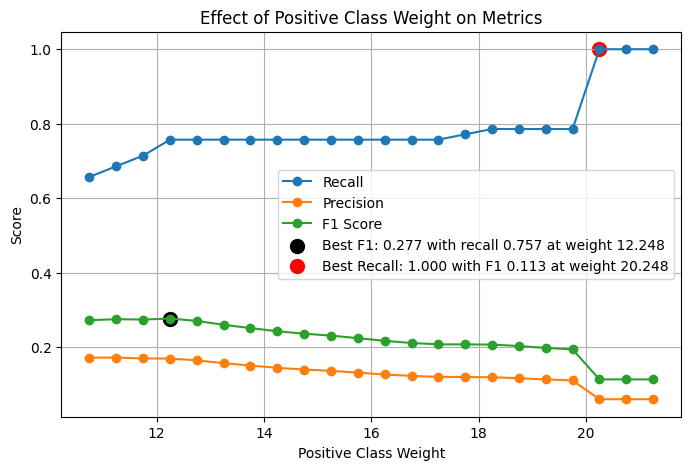

In [327]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

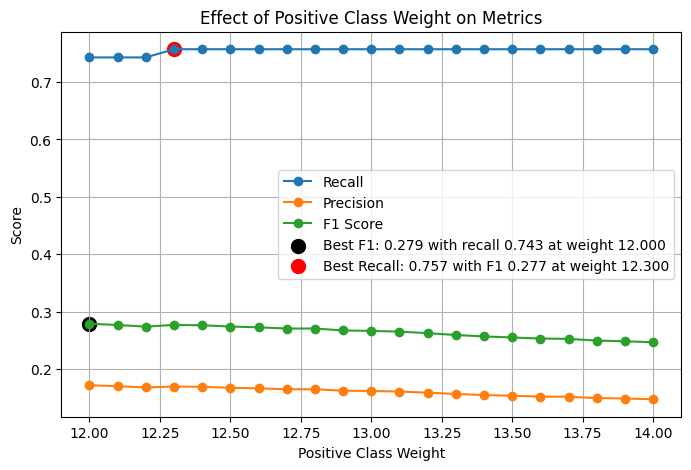

In [328]:
weights_to_test = np.arange(12, 14 + 0.1, 0.1)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

In [50]:
optimized_ratio = 12.3

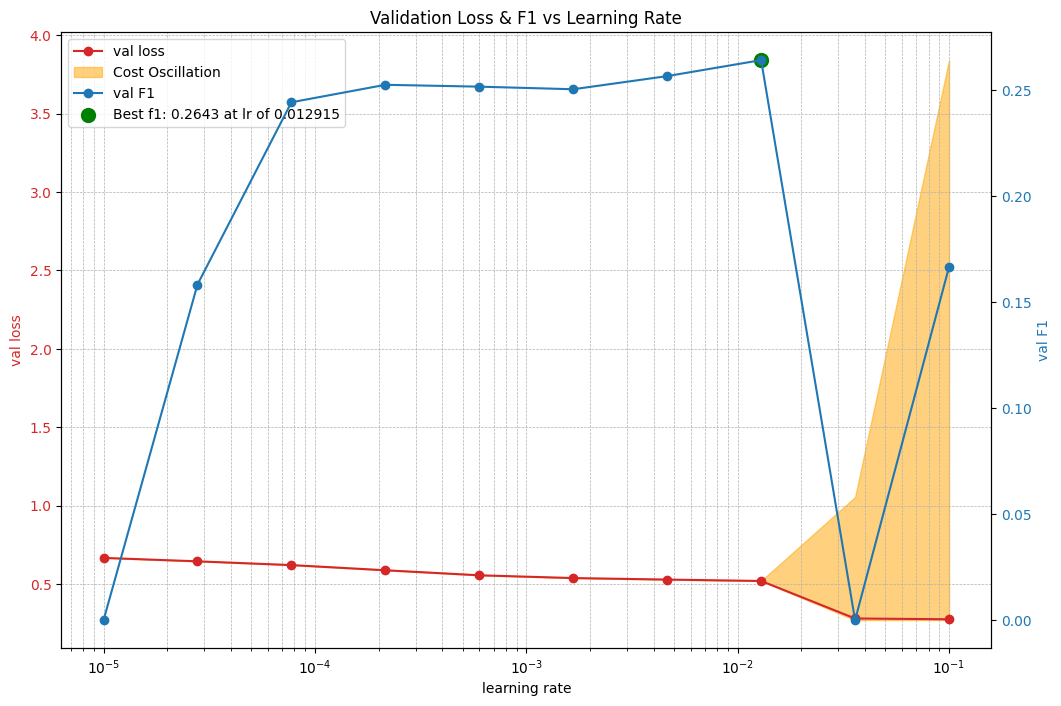

In [332]:
lrs = np.logspace(start=-5, stop=-1, num=10)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, plotF1=True, iterations=1000)

In [51]:
lambda_values = np.array([0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500, 600])
lambda_const = logisticRegression.find_best_lambda(lambda_values, X_train_np, y_train_np, X_val_np, y_val_np, extra_weight=optimized_ratio, iterations=1000)

Lambda: 0.001000 | Best T: 0.650 | F1: 0.2932
Lambda: 0.010000 | Best T: 0.650 | F1: 0.2932
Lambda: 0.100000 | Best T: 0.650 | F1: 0.2932
Lambda: 1.000000 | Best T: 0.650 | F1: 0.2932
Lambda: 10.000000 | Best T: 0.650 | F1: 0.2932
Lambda: 100.000000 | Best T: 0.680 | F1: 0.3087
Lambda: 200.000000 | Best T: 0.660 | F1: 0.3165
Lambda: 300.000000 | Best T: 0.660 | F1: 0.3200
Lambda: 400.000000 | Best T: 0.660 | F1: 0.3217
Lambda: 500.000000 | Best T: 0.650 | F1: 0.3158
Lambda: 600.000000 | Best T: 0.640 | F1: 0.3077

Best lambda: 400.0
Best threshold: 0.660
Best F1: 0.3217


In [52]:
w, b = logisticRegression.logistic_regression(
    X_train_np, y_train_np, X_val_np, y_val_np, 
    learning_rate=learning_rate_optimized, 
    l2_reg=True, lambda_const=lambda_const, 
    extra_weight=optimized_ratio, 
    iterations=1000
)
f1_score_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w, b)
model = Model.Model(w, b, f1_score_threshold, improvement="Model V1.2 with new feature")
MODEL_V1_2_NEWFEAT = "ModelV1_2_NewFeat"
model_tracker.add(model, name=MODEL_V1_2_NEWFEAT)

logisticRegression.print_model_stats(X_val_np, y_val_np, w, b, f1_score_threshold)

Iteration 0: Train cost = 1.1608 | Val cos =  0.6931
Iteration 100: Train cost = 1.0149 | Val cos =  0.5359
Iteration 200: Train cost = 1.0008 | Val cos =  0.5340
Iteration 300: Train cost = 0.9935 | Val cos =  0.5358
Early stopping a l'iteration 373. Best Loss: 0.533855
Model ModelV1_2_NewFeat saved

AUC         : 0.7983
Precision   : 0.3151
Recall      : 0.3286
F1          : 0.3217
Threshold   : 0.6600
[[1045   50]
 [  47   23]]


In [52]:
notToRemove

['MOPLMIDD', 'MOPLLAAG']

In [53]:
X_old = data_tracker.get(DATA_V2)
notToRemove = []
toNotAdd = []
for c in X_old.columns:
    if c not in X.columns: notToRemove.append(c)
X_train_old_np, y_train_old_np, X_val_old_np, y_val_old_np = feature_tracker.return_split_train_eval(X_other=X_old, notToRemove=notToRemove, toNpy=True)

In [54]:
print(MODEL_V1_1_DIFF_EDUC)
prevModel = model_tracker.get_by_name(MODEL_V1_1_DIFF_EDUC)
logisticRegression.print_model_stats(X_val_old_np, y_val_old_np, prevModel.w, prevModel.b, prevModel.threshold)

print('\n', MODEL_V1_2_NEWFEAT)
logisticRegression.print_model_stats(X_val_np, y_val_np, model.w, model.b, model.threshold)

ModelV1_with_diff_educ
AUC         : 0.7986
Precision   : 0.3239
Recall      : 0.3286
F1          : 0.3262
Threshold   : 0.6800
[[1047   48]
 [  47   23]]

 ModelV1_2_NewFeat
AUC         : 0.7983
Precision   : 0.3151
Recall      : 0.3286
F1          : 0.3217
Threshold   : 0.6600
[[1045   50]
 [  47   23]]


Les résultats sont pratiquement les mêmes, je commence a avoir l'impression que le modèle focus beaucoup trop sur ces features. Peut-etre il y en a qui sont mauvaise.

In [55]:
X = data_tracker.get(DATA_V0)
X_train_np,X_val_np, y_train_np, y_val_np = data.get_split_train_eval_data(X, toNpy=True)

In [56]:
lambda_values = np.array([0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500, 600])
lambda_const = logisticRegression.find_best_lambda(lambda_values, X_train_np, y_train_np, X_val_np, y_val_np, extra_weight=optimized_ratio, iterations=1000)

Lambda: 0.001000 | Best T: 0.720 | F1: 0.2835
Lambda: 0.010000 | Best T: 0.720 | F1: 0.2835
Lambda: 0.100000 | Best T: 0.720 | F1: 0.2835
Lambda: 1.000000 | Best T: 0.720 | F1: 0.2835
Lambda: 10.000000 | Best T: 0.720 | F1: 0.2857
Lambda: 100.000000 | Best T: 0.660 | F1: 0.3190
Lambda: 200.000000 | Best T: 0.670 | F1: 0.3243
Lambda: 300.000000 | Best T: 0.660 | F1: 0.3265
Lambda: 400.000000 | Best T: 0.650 | F1: 0.3289
Lambda: 500.000000 | Best T: 0.640 | F1: 0.3226
Lambda: 600.000000 | Best T: 0.630 | F1: 0.3067

Best lambda: 400.0
Best threshold: 0.650
Best F1: 0.3289


J'ai des résultats légèrement meilleur avec seulement one-hot coding comme feature engineering............. j'ai merder qq part ou j'ai juste rien compris

In [57]:
w,b = logisticRegression.logistic_regression(
    X_train_np, y_train_np, X_val_np, y_val_np, 
    extra_weight=optimized_ratio, learning_rate=0.01, 
    iterations=1000, 
    l2_reg=True, lambda_const=lambda_const,
    to_print=True
)
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w, b)
model = Model.Model(w, b, f1_threshold, improvement="")
logisticRegression.print_model_stats(X_val_np, y_val_np, w, b, f1_threshold)

Iteration 0: Train cost = 1.1608 | Val cos =  0.6931
Iteration 100: Train cost = 1.0088 | Val cos =  0.5286
Iteration 200: Train cost = 0.9959 | Val cos =  0.5271
Iteration 300: Train cost = 0.9901 | Val cos =  0.5288
Early stopping a l'iteration 367. Best Loss: 0.526895
AUC         : 0.7984
Precision   : 0.3049
Recall      : 0.3571
F1          : 0.3289
Threshold   : 0.6500
[[1038   57]
 [  45   25]]


In [51]:
y_pred= logisticRegression.predict(X_val_np, w, b, model.threshold)

tp_indices = np.where((y_val_np == 1) & (y_pred == 1))[0]
fp_indices = np.where((y_val_np == 0) & (y_pred == 1))[0]
tn_indices = np.where((y_val_np == 0) & (y_pred == 0))[0]
fn_indices = np.where((y_val_np == 1) & (y_pred == 0))[0]
X_tp = X_val_np[tp_indices]
X_fp = X_val_np[fp_indices]
X_tn = X_val_np[tn_indices]
X_fn = X_val_np[fn_indices]
X_tp_df = pd.DataFrame(data=X_tp, columns=X_val.columns)
X_fp_df = pd.DataFrame(data=X_fp, columns=X_val.columns)
X_tn_df = pd.DataFrame(data=X_tn, columns=X_val.columns)
X_fn_df = pd.DataFrame(data=X_fn, columns=X_val.columns)

Si on regarde le tableau ci-dessous, on peut voir que la distrubution reste la même, alors la variable additionnel n'a pas eu tellement d'effet. Le modèle est probablement encore entrain de prioriser ceux qui présente ces caractéristiques : 
- total_contribution élevé
- MHKOOP élevé
- diff_educ_mid_bas élevé
- MFWEKIND élevé
- MRELGE élevé
- Majoritairement Protestant et catholique

Mais on peut voir que les FP ont quelque caractéristiques uniques : 
- MRELSA et MFGEKIND bas

Je pourais créer une variable qui pénalise ce genre de profil. On peut voir que la médiane des FN, FP et TP de la variable MRELGE (Married) est de 7 tandis que pour les TN, elle est de 6. Alors, on peut créer cette variable

married_together_noKids = MRELGE x (MRELSA)


(Cette fois-ci je vais regarder la médiane pour éviter les extravagentes)

<style type="text/css">
#T_f022c_row0_col0, #T_f022c_row1_col0, #T_f022c_row1_col1, #T_f022c_row2_col0, #T_f022c_row3_col2, #T_f022c_row4_col0, #T_f022c_row4_col2, #T_f022c_row4_col3, #T_f022c_row5_col0, #T_f022c_row5_col1, #T_f022c_row6_col2, #T_f022c_row6_col3, #T_f022c_row7_col0, #T_f022c_row8_col2, #T_f022c_row9_col0, #T_f022c_row9_col1, #T_f022c_row9_col2, #T_f022c_row9_col3, #T_f022c_row10_col0, #T_f022c_row10_col1 {
  background-color: rgba(255, 255, 204, 1.00);
  color: black;
}
#T_f022c_row0_col1 {
  background-color: rgba(248, 70, 39, 1.00);
  color: black;
}
#T_f022c_row0_col2, #T_f022c_row0_col3, #T_f022c_row1_col2, #T_f022c_row1_col3, #T_f022c_row2_col1, #T_f022c_row2_col2, #T_f022c_row2_col3, #T_f022c_row3_col0, #T_f022c_row3_col1, #T_f022c_row3_col3, #T_f022c_row4_col1, #T_f022c_row5_col2, #T_f022c_row6_col0, #T_f022c_row6_col1, #T_f022c_row7_col1, #T_f022c_row7_col2, #T_f022c_row7_col3, #T_f022c_row8_col0, #T_f022c_row8_col1, #T_f022c_row10_col2, #T_f022c_row10_col3 {
  background-color: rgba(128, 0, 38, 1.00);
  color: black;
}
#T_f022c_row5_col3 {
  background-color: rgba(226, 25, 28, 1.00);
  color: black;
}
#T_f022c_row8_col3 {
  background-color: rgba(252, 140, 59, 1.00);
  color: black;
}
</style>
<table id="T_f022c" style="border-collapse:collapse; width:60%;">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_f022c_level0_col0" class="col_heading level0 col0" >TN</th>
      <th id="T_f022c_level0_col1" class="col_heading level0 col1" >FN</th>
      <th id="T_f022c_level0_col2" class="col_heading level0 col2" >FP</th>
      <th id="T_f022c_level0_col3" class="col_heading level0 col3" >TP</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_f022c_level0_row0" class="row_heading level0 row0" >total_contribution</th>
      <td id="T_f022c_row0_col0" class="data row0 col0" >-0.332376</td>
      <td id="T_f022c_row0_col1" class="data row0 col1" >0.595161</td>
      <td id="T_f022c_row0_col2" class="data row0 col2" >1.110460</td>
      <td id="T_f022c_row0_col3" class="data row0 col3" >1.110460</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row1" class="row_heading level0 row1" >MHKOOP</th>
      <td id="T_f022c_row1_col0" class="data row1 col0" >5.000000</td>
      <td id="T_f022c_row1_col1" class="data row1 col1" >5.000000</td>
      <td id="T_f022c_row1_col2" class="data row1 col2" >9.000000</td>
      <td id="T_f022c_row1_col3" class="data row1 col3" >9.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row2" class="row_heading level0 row2" >diff_educ_mid_bas</th>
      <td id="T_f022c_row2_col0" class="data row2 col0" >0.063158</td>
      <td id="T_f022c_row2_col1" class="data row2 col1" >0.585008</td>
      <td id="T_f022c_row2_col2" class="data row2 col2" >0.585008</td>
      <td id="T_f022c_row2_col3" class="data row2 col3" >0.585008</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row3" class="row_heading level0 row3" >MRELSA</th>
      <td id="T_f022c_row3_col0" class="data row3 col0" >1.000000</td>
      <td id="T_f022c_row3_col1" class="data row3 col1" >1.000000</td>
      <td id="T_f022c_row3_col2" class="data row3 col2" >0.000000</td>
      <td id="T_f022c_row3_col3" class="data row3 col3" >1.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row4" class="row_heading level0 row4" >MFGEKIND</th>
      <td id="T_f022c_row4_col0" class="data row4 col0" >3.000000</td>
      <td id="T_f022c_row4_col1" class="data row4 col1" >3.500000</td>
      <td id="T_f022c_row4_col2" class="data row4 col2" >3.000000</td>
      <td id="T_f022c_row4_col3" class="data row4 col3" >3.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row5" class="row_heading level0 row5" >MFWEKIND</th>
      <td id="T_f022c_row5_col0" class="data row5 col0" >4.000000</td>
      <td id="T_f022c_row5_col1" class="data row5 col1" >4.000000</td>
      <td id="T_f022c_row5_col2" class="data row5 col2" >6.000000</td>
      <td id="T_f022c_row5_col3" class="data row5 col3" >5.500000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row6" class="row_heading level0 row6" >MGODGE</th>
      <td id="T_f022c_row6_col0" class="data row6 col0" >3.000000</td>
      <td id="T_f022c_row6_col1" class="data row6 col1" >3.000000</td>
      <td id="T_f022c_row6_col2" class="data row6 col2" >2.000000</td>
      <td id="T_f022c_row6_col3" class="data row6 col3" >2.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row7" class="row_heading level0 row7" >MRELGE</th>
      <td id="T_f022c_row7_col0" class="data row7 col0" >6.000000</td>
      <td id="T_f022c_row7_col1" class="data row7 col1" >7.000000</td>
      <td id="T_f022c_row7_col2" class="data row7 col2" >7.000000</td>
      <td id="T_f022c_row7_col3" class="data row7 col3" >7.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row8" class="row_heading level0 row8" >MRELOV</th>
      <td id="T_f022c_row8_col0" class="data row8 col0" >2.000000</td>
      <td id="T_f022c_row8_col1" class="data row8 col1" >2.000000</td>
      <td id="T_f022c_row8_col2" class="data row8 col2" >0.000000</td>
      <td id="T_f022c_row8_col3" class="data row8 col3" >1.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row9" class="row_heading level0 row9" >MGODPR</th>
      <td id="T_f022c_row9_col0" class="data row9 col0" >5.000000</td>
      <td id="T_f022c_row9_col1" class="data row9 col1" >5.000000</td>
      <td id="T_f022c_row9_col2" class="data row9 col2" >5.000000</td>
      <td id="T_f022c_row9_col3" class="data row9 col3" >5.000000</td>
    </tr>
    <tr>
      <th id="T_f022c_level0_row10" class="row_heading level0 row10" >MGODRK</th>
      <td id="T_f022c_row10_col0" class="data row10 col0" >0.000000</td>
      <td id="T_f022c_row10_col1" class="data row10 col1" >0.000000</td>
      <td id="T_f022c_row10_col2" class="data row10 col2" >1.000000</td>
      <td id="T_f022c_row10_col3" class="data row10 col3" >1.000000</td>
    </tr>
  </tbody>
</table>

Par accident, j'ai oublier d'effacer les variables total_recreational_contribution et total_recreational_policies. Mais j'ai remarquer que sa augmenter les TP de 4. 

In [58]:
vars_extra_base = [
    'total_policies',
    'total_motorized_policies',
    'total_contribution',
    'total_motorized_contribution',
    'ratio_motorized_contribution',
    'avg_area_income',
    'FN_ensemble_noKids_notReligious',
    'has_recreational_vehicule_policie', 
    'total_recreational_contribution', 
    'total_recreational_policies'
]

cols_to_remove = [
    'MHHUUR',
    'MZFONDS',
    'AWAPART',
    'AWALAND',
    'AAANHANG',
    'ABROM',
    'AGEZONG',
    'ABYSTAND',
    'ratio_motorized_policies',
    'MOSTYPE_8_x_MBERBOER_0',
    'MOSTYPE_12_x_MBERBOER_0'
]

X = data_tracker.get(DATA_V0)
feature_tracker.feature_comparator(X, vars_extra_base, class_weight=13, cols_to_remove=cols_to_remove)

--------------------| Test avec les variables de base |--------------------
AUC         : 0.8003
Precision   : 0.2358
Recall      : 0.4143
F1          : 0.3005
Threshold   : 0.6600
[[1001   94]
 [  41   29]]

--------------------| Test avec interactions terms |--------------------
AUC         : 0.8022
Precision   : 0.2427
Recall      : 0.3571
F1          : 0.2890
Threshold   : 0.6800
[[1017   78]
 [  45   25]]



In [59]:
print('\n',MODEL_V1_2_NEWFEAT)
logisticRegression.print_model_stats(X_val_np, y_val_np, model.w, model.b, model.threshold)


 ModelV1_2_NewFeat
AUC         : 0.7984
Precision   : 0.3049
Recall      : 0.3571
F1          : 0.3289
Threshold   : 0.6500
[[1038   57]
 [  45   25]]


Sans les termes d'intéractions, j'obtiens 4 TP de plus et 37 FP de plus. \
Avec les termes d'intéractions, j'obtiens de résultat similaire, mais avec 20 FP de plus.

4 TP de plus représente une augmentation de $\approx$ 5.71% par rapport au nombre total de cas positifs (TP + FN).

37 FP de plus représente une augmentation de $\approx$ 3.34% par rapport au nombre total de cas négatifs (FP + TN).

Les TP ont plus d'importance que les FN et en plus l'augmentation en TP est plus grand que celui des FP. Je crois que j'avais tord de retirer ces variables et aussi d'ajouter des termes d'interactions. Je vais faire des tests addionnels.

In [60]:
X = data_tracker.get(DATA_V0)
len(X.columns)

134

In [103]:
feature_tracker.to_remove_cols

['APLEZIER',
 'AFIETS',
 'AZEILPL',
 'PPLEZIER',
 'PFIETS',
 'PZEILPL',
 'MINKM30',
 'MINK3045',
 'MINK4575',
 'MINK7512',
 'MINK123M',
 'MINKGEM',
 'MHHUUR',
 'MZFONDS',
 'AWAPART',
 'AWALAND',
 'AAANHANG',
 'ABROM',
 'AGEZONG',
 'ABYSTAND',
 'ratio_motorized_policies',
 'MOSTYPE_8_x_MBERBOER_0',
 'MOSTYPE_12_x_MBERBOER_0',
 'MOPLMIDD',
 'MOPLLAAG',
 'has_recreational_vehicule_policie',
 'diff_educ_mid_bas']

In [61]:
X = data_tracker.get(DATA_V0)
vars_to_test = ['has_recreational_vehicule_policie', 'total_recreational_contribution', 'total_recreational_policies' ]
vars_extra_base = [
    'total_policies',
    'total_motorized_policies',
    'total_contribution',
    'total_motorized_contribution',
    'ratio_motorized_contribution',
    'avg_area_income',
    'FN_ensemble_noKids_notReligious'
]
feature_tracker.feature_comparator(X, vars_extra_base, vars_to_test, class_weight=13)

--------------------| Test avec les variables de base |--------------------
AUC         : 0.7868
Precision   : 0.2385
Recall      : 0.3714
F1          : 0.2905
Threshold   : 0.6700
[[1012   83]
 [  44   26]]

----- Test avec la variable has_recreational_vehicule_policie -----
AUC         : 0.7884
Precision   : 0.2333
Recall      : 0.4000
F1          : 0.2947
Threshold   : 0.6600
[[1003   92]
 [  42   28]]

----- Test avec la variable total_recreational_contribution -----
AUC         : 0.7945
Precision   : 0.2403
Recall      : 0.4429
F1          : 0.3116
Threshold   : 0.6600
[[997  98]
 [ 39  31]]

----- Test avec la variable total_recreational_policies -----
AUC         : 0.7932
Precision   : 0.2344
Recall      : 0.4286
F1          : 0.3030
Threshold   : 0.6600
[[997  98]
 [ 40  30]]

--------------------| Test avec interactions terms |--------------------
AUC         : 0.7894
Precision   : 0.2205
Recall      : 0.4000
F1          : 0.2843
Threshold   : 0.6500
[[996  99]
 [ 42  28]]

--

| Variable testée | **Sans interactions — Conf** | **Sans interactions — Ratios** | **Avec interactions — Conf** | **Avec interactions — Ratios** | **Δ FP rate** | **Δ Recall** |
|-----------------|------------------------------|--------------------------------|-------------------------------|---------------------------------|----------------|----------------|
| **baseline (varExtra seulement)** | $\begin{bmatrix}1012 & 83 \\ 44 & 26\end{bmatrix}$ | FP rate = $0.0759$, TP rate = $0.3714$ | $\begin{bmatrix}996 & 99 \\ 42 & 28\end{bmatrix}$ | FP rate = $0.0905$, TP rate = $0.4000$ | $\Delta FP = 0.0146$ | $\Delta Recall = 0.0286$ |
| **has\_recreational\_vehicule\_policie** | $\begin{bmatrix}1003 & 92 \\ 42 & 28\end{bmatrix}$ | FP rate = $0.0840$, TP rate = $0.4000$ | $\begin{bmatrix}996 & 99 \\ 41 & 29\end{bmatrix}$ | FP rate = $0.0905$, TP rate = $0.4143$ | $\Delta FP = 0.0065$ | $\Delta Recall = 0.0143$ |
| **total\_recreational\_contribution** | $\begin{bmatrix}997 & 98 \\ 39 & 31\end{bmatrix}$ | FP rate = $0.0898$, TP rate = $0.4429$ | $\begin{bmatrix}985 & 110 \\ 38 & 32\end{bmatrix}$ | FP rate = $0.1005$, TP rate = $0.4571$ | $\Delta FP = 0.0107$ | $\Delta Recall = 0.0142$ |
| **total\_recreational\_policies** | $\begin{bmatrix}997 & 98 \\ 40 & 30\end{bmatrix}$ | FP rate = $0.0898$, TP rate = $0.4286$ | $\begin{bmatrix}993 & 102 \\ 40 & 30\end{bmatrix}$ | FP rate = $0.0932$, TP rate = $0.4286$ | $\Delta FP = 0.0035$ | $\Delta Recall = 0.0000$ |


has_recrational_vehicule_policie est une variable binaire qui remplace total_recreational_policie et total_recreational_contribution. 

##### **Sans les interactions terms:** 
- La variable **has_recreational_vehicule_policie** semble ajouter moins d'informations, on gagne 2 TP et 9 FN. 
- La variable **total_recreational_policies** semble ajouter plus d'informations que **has_recreational_policies**, avec elle on gagne 4 TP et 15 FN. 
- La variable **total_recreational_contribution** gagne 5 TP et 15 FN.
- La variable total_recreational_contribution semble etre la meilleure selon moi, son recall est le plus haut en ayant un FP rate similaire aux autres.

##### **Avec les interactions terms:** (vs baseline)
- Le baseline + interactions terms performe similaire au baseline seulement. Il a 2 TP de plus et 16 FN de plus. 
- La variable **has_recreational_vehicule_policie** +1 TP et +7 FN.
- La variable **total_recreational_contribution** le recall augmente de 1.42% et le FP rate de 1.07%.
- La variable **total_recreational_polcicies** le recall reste pareil et le FP rate augmente de 0.35%.

Le plus grands de recall provient des variables retirés + les interactions terms. Avec les interactions terms, **has_recreational_vehicule_policie** est la pire en terme de performance. Donc mon hypothèse à propos de l'utilité de **total_recreational_contribution** et **total_recreational_polcicies** était fausse. \
Aussi j'ai l'impréssion que les interactions terms ne sert pas trop à quelque chose, peut-etre qu'ils visent trop un groupe petit? 

En retirant '**has_recreational_vehicule_policie**' et '**diff_educ_mid_bas**' et en ajoutant '**total_recreational_policies**' ET '**total_recreational_contribution**', j'obtiens un recall de 0.5 qui est une géante amélioration comparer au modèle après tout le feature engineering.

In [62]:
cols_to_remove = ['has_recreational_vehicule_policie', 'diff_educ_mid_bas']
feature_tracker.remove_list(cols_to_remove)
feature_tracker.restore('total_recreational_policies', isToScale=True)
feature_tracker.restore('total_recreational_contribution', isToScale=True)

X = feature_tracker.flush_to_df(removeTargets=True)
model = feature_tracker.test_current(threshold_method='F1', set_threshold_to=None, class_weight=13)

AUC         : 0.7962
Precision   : 0.2174
Recall      : 0.5000
F1          : 0.3030
Threshold   : 0.6300
[[969 126]
 [ 35  35]]


J'ai décider de recommencer mon analyse. Maintenant que je suis plus confortable avec la matière je crois que sa serait le meilleur choix. Mon modèle précèdent semble être trop fixer sur un type de client particulier.

$$\text{logit } p = \ln \frac{p}{1-p} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n = z$$
$$ e^z = \frac{p}{1-p} \iff p = \frac{e^z}{1 + e^z} $$
$$p = P(\text{CARAVAN} = 1 | X = x)$$

$$\text{odds } = \frac{p}{1-p}$$

$$OR = e^{\beta}$$

Le odds-ratio permet de mesurer l'effet d'une variable sur la probabilité qu'un évenements se produise (CARAVAN = 1).

Il faut que je calcul l'intervalle de confiance pour assumer qu'une variable est significative selon la valeur de son $OR$.

Pour calculer un intervalle de confiance, j'ai besoin de l'écart-type des variables. Mais puisque OR dépend des rélations entres les variables, je dois utiliser une matrice de covariance, qui est l'inverse de la matrice de Fisher Information.

**Fisher Information :** 

$$\theta = \mathbb{E} \left[ \left( \frac{\partial}{\partial \theta} \log f(X; \theta) \right)^2 \right]$$

$\mathbb{E} = $  espérance de $X$ \
$f(X; \theta) = $ fonction de densité de $X$

Forme matrice : 

$$p_i = P(\text{CARAVAN} = 1 | X_i) = \sigma(X_i \cdot \beta) = \dfrac{e^{X_i \cdot \beta}}{1 + e^{X_i \cdot \beta}} \\
\ell(\beta) = \sum^n_{i=1} \log f(X_i; \theta) =  \sum_{i=1}^{n} \Big[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \Big] = - \text{cost function } \\ 
(y_i = \text{la valeur observée du target (0 ou 1))} 
$$
$$
\frac{\partial \ell}{\partial \beta} = X^T (y - p) = \text{gradient ascent} \\
\frac{\partial^2 \ell}{\partial \beta\, \partial \beta^T} = -X^T W X = \text{variation du gradient ascent}
$$

$$\text y_i \sim Bernoulli(p) \iff Var(y_i) = p_i(1 - p_i)$$

$$ W = diag(p_i(1 - p_i)) = Var(Y) =
\begin{bmatrix}
p_1(1-p_1) & 0 & \cdots & 0 \\
0 & p_2(1-p_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & p_n(1-p_n)
\end{bmatrix}$$

Sa calcul la précision de l'estimation d'un coefficient 


Pour comparer les résultats de façon équitable, je vais fixer ces variables :
- learning_rate = 0.01
- class_weight = 1
- threshold = 0.1

In [63]:
categorical_non_ordinales = ['MOSTYPE', 'MOSHOOFD']
df_encoded = pd.get_dummies(df, columns=categorical_non_ordinales, prefix=categorical_non_ordinales, dtype=int, drop_first=True)
X_base_one_hot = df_encoded.copy()
featureTester = FeatureTracker.FeatureTracker(X_base_one_hot)
X_train_np, y_train_np, X_val_np, y_val_np = featureTester.return_split_train_eval(toNpy=True)

model = featureTester.test_current()

AUC         : 0.7951
Precision   : 0.1697
Recall      : 0.5286
F1          : 0.2569
Threshold   : 0.1000
[[914 181]
 [ 33  37]]


In [64]:
coeff = model.w
bias = model.b
odds_ratio = np.exp(coeff)
confiance = 0.95

def fisher_info(X, w, b):
    z = X @ w + b
    p = logisticRegression.sigmoid(z)
    W = np.diag(p * (1-p))
    fi = X.T @ W @ X
    return fi

fi = fisher_info(X_train_np, coeff, bias)
print(np.linalg.det(fi))

4.753692681997185e-11


La matrice de covariance est proche d'être singuliaire, car $\text{det}(\text{fisher\_information}) \approx 0$, elle est presque non-inversible. \
Si je l'inverse, il y a des variances gigantesque et positive/négative.

- Si on regarde qu'elle variance $\lt$ 0, on trouve que 14 d'entres elles sont négatives (elles sont aussi gigantesques) $( Var(y) \lt -10^{14})$. \
29 sont des variables catégoriques non-ordinales à propos du type de cients et 2 sont à propos du nombre et la contribution d'assurance surfboard. \

- Si on regarde ceux qui sont géante, on trouve qu'il y en a 32 d'entres elles qui sont gigantesques.


C'est un signe que ces variables sont peut-être complètement séparer des données, donc pourait prédire constamment le même résultat, ce qui indique que leur $\beta$ tend vers $\pm \infin$.

In [65]:
cov_matrix = np.linalg.inv(fi)
#std = np.sqrt(np.diag(cov_matrix))
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'var': np.diag(cov_matrix),
})

print('négatif count in variance:               ', coef_df[coef_df['var'] < 0].shape[0])
print('négatif gigantesque count in variance:   ', coef_df[coef_df['var'] <= -10**13].shape[0])
print('Gigantesque count in variance:           ', coef_df[coef_df['var'] >= 10**(14)].shape[0])

huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

négatif count in variance:                14
négatif gigantesque count in variance:    14
Gigantesque count in variance:            32


Si on vérifie, on trouve qu'il y a quelque une variable qui prédit toujours CARAVAN = 0 et le reste sont des cas très rares.

In [66]:
huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

cols_with_zeros_targets = []
cols_with_all_targets = []
cols_with_rare_outcomes = {}

for c in inf_coef_cols:
    crossTab = pd.crosstab(X_train_inf_coef[c], y_train)

    if 1 in crossTab.index:
        #print(f'\n{c} = 1')
        not_target_count = crossTab.loc[1, 0]
        target_count = crossTab.loc[1, 1]
        #print(f"    (CARAVAN=0) : {not_target_count}")

        if target_count == 0:
            #print(f'    Prédit toujours CARAVAN=0')
            cols_with_zeros_targets.append(c)
        elif not_target_count == 0:
            #print(f'    Prédit toujours CARAVAN=1')
            cols_with_all_targets.append(c)
        else:
           #print(f"    (CARAVAN=1): {target_count}")
           cols_with_rare_outcomes[c] = np.array([target_count, not_target_count])
    else:
        print('what?')

Les variables qui prédisent tous le temps CARAVAN = 0 dans le training set sont inutiles donc je vais les retirer.

In [67]:
featureTester.remove_list(cols_with_zeros_targets)
X = featureTester.flush_to_df()

X_train_np, y_train_np, X_val_np, y_val_np = featureTester.return_split_train_eval(toNpy=True)
model = Model.create_model(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=0.01, set_threshold_to=0.1)

Les autres variables ne sont pas complètement séparer, mais peut-etre souffre de multicolinéarité, ce qui serait la cause de leur variance gigantesque.

Précédemment, j'avais utilisé une matrice de corrélation pour trouver les corrélations entre variables, mais le problème est qu'elle évalue seulement la colinéarité entre deux variables. Pour ce problème, c'est mieux d'utiliser le VIF, car il permet d'analyser l'impact de tout les autres variables sur la variance d'un coefficient, ce qui est exactement ce que j'ai besoin pour trouver la cause de la variance énorme des variables restantes. 

$$VIF = \dfrac{1}{1-R^2}$$
$$
X_i = \beta_0 + \sum_{j \neq i}(\beta_j X_j) + \varepsilon_i \\
\hat{\beta} = (X^TX)^{-1}X^Ty 
$$
$$\varepsilon_i = X_i -\hat{X_i} \iff Var(\varepsilon_i) = Var(X_i) -Var(\hat{X_i})$$
$$\sum{\varepsilon_i} = \sum{(X_i -\hat{X_i})} = 0$$
$$
R^{2}_{i} = \frac{Var(\hat{X_i})}{Var(X_i)} = \frac{ Var({X_i}) - Var(\varepsilon_i)}{Var(X_i)} 
= 1 - \frac{Var(\varepsilon_i)}{Var({X_i})}
$$

In [68]:
def ols(X, y):
    w = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return w

def regressionLineaire(X, y):
    w = ols(X, y)
    residual = y - X @ w
    return w, residual

def auxRegLin(X, eps):
    var_residual = np.sum(eps**2)
    xm = np.mean(X)
    var_X = np.sum((X - xm)**2)
    return (1 - var_residual/var_X)
    
def vif(X, cols):
    vif_res = {}
    for c in cols:
        X_i = X[c].to_numpy()
        X_hat_i = X.drop(c, axis=1).to_numpy()
        w, residu = regressionLineaire(X_hat_i, X_i)
        R2 = auxRegLin(X_i, residu)
        if R2 == 1:
            vif = 0
        else:
            vif = 1/(1 - R2)
        vif_res[c] = vif
    return pd.DataFrame.from_dict(vif_res, orient='index', columns=['VIF']).sort_values(by='VIF', ascending=False)

df_vif = vif(X.drop('CARAVAN', axis=1), cols_with_rare_outcomes)


In [69]:
index_useless = df_vif[df_vif['VIF'] == 0].index
index_mid_corr = df_vif[(df_vif['VIF'] > 1) & (df_vif['VIF'] <= 5)].index
index_high_corr = df_vif[(df_vif['VIF'] > 5) & (df_vif['VIF'] <= 10)].index
index_serious_corr = df_vif[(df_vif['VIF'] > 10)].index

Tout les variables avec un $R^2$ = 1 (colinéarité parfaite, donc parfaitement prédite par les autres variables) sont des variables de types MOSTYPE (customer sub-type) ou MOSHOOFD (customer main type). Je vais les retirer puisqu'elle n'aide pas le modèle. Les seules que je vais garder sont eux avec 1 < VIF < 5. Plus grand leur résultat VIF indique qu'ils sont hautement corrélés.

In [303]:
# df_filtered = df_vif.loc[index_mid_corr]
# prefix_level = {
#     'MOSTYPE': 'L0',
#     'MOSHOOFD': 'L2'
# }
# new_index = []
# for idx in df_filtered.index:
#     prefix = idx.split('_')[0]
#     level = prefix_level.get(prefix, None)
#     new_name = ''
#     if prefix == 'MOSHOOFD':
#         new_name += '(main type) '
#     if level is None:
#         new_index.append(idx)
#     else:
#         new_name += data.apply_Lx_to_index(idx, prefix, level)
#         new_index.append(new_name)
# df_filtered.index = new_index

# isFamily = df_filtered.index.str.contains(r'family|families|with children', case=False)
# df_filtered.sort_index()

Les métriques restent similaires à avant le retrait de ces variables, donc c'est une confirmation que le retrait n'a pas tellement affecté les prédictions du modèles.

In [70]:
featureTester.remove_list(index_useless)
featureTester.remove_list(index_high_corr)
featureTester.remove_list(index_serious_corr)

X = featureTester.flush_to_df()

model = featureTester.test_current(class_weight=1)

AUC         : 0.7944
Precision   : 0.1689
Recall      : 0.5286
F1          : 0.2561
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


Maintenant, on retourne au calcul de Fisher information pour trouver les variables les plus utiles pour prédire CARAVAN=1

In [71]:
X_train_np, y_train_np, X_val_np, y_val_np = featureTester.return_split_train_eval(toNpy=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

-1.615584458150003e+94


La matrice est négative. Je crois je devrais enlever les termes moyennements corrélés aussi.

In [72]:
featureTester.remove_list(index_mid_corr)
X = featureTester.flush_to_df()

model = featureTester.test_current(class_weight=1)

AUC         : 0.7942
Precision   : 0.1689
Recall      : 0.5286
F1          : 0.2561
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


In [73]:
import scipy.stats as st

coeff = model.w 
bias = model.b 
odds_ratio = np.exp(coeff) 
confiance = 0.95

X_train_np, y_train_np, X_val_np, y_val_np = featureTester.return_split_train_eval(toNpy=True)

fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
cov_matrix = np.linalg.inv(fi)
std = np.sqrt(np.diag(cov_matrix))

surface = 1 - (1-confiance)/2
z = st.norm.ppf(surface)

bi = coeff - z * std
bs = coeff + z * std

bi_or = np.exp(bi)
bs_or = np.exp(bs)
    
coef_df = pd.DataFrame({
    'feature': X.drop('CARAVAN', axis=1).columns,
    '$\\beta_n$': model.w,
    '$OR$': odds_ratio,
    '$bi_{OR}$': bi_or,
    '$bs_{OR}$': bs_or
})

coef_df = coef_df.round(4)

mask_signif = (coef_df['$bi_{OR}$'] > 1) | (coef_df['$bs_{OR}$'] < 1)
print(coef_df[mask_signif].to_markdown())
#print(coef_df.sort_values(by='$OR$', key=abs, ascending=False).to_markdown())

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 44 | PPERSAUT  |      0.1974 | 1.2182 |      1.1104 |      1.3365 |


$$OR > 1 \to \text{augmente les chances que CARAVAN = 1}$$
$$OR < 1 \to \text{diminue les chances que CARAVAN = 1}$$
$$OR = 1 \to \text{aucun effet sur les chances que CARAVAN = 1}$$

Il y a seulement la variable PPERSAUT qu'on peut assumer comme significative. Puisque son intervalle de confiance est [1.1104, 1.3365] avec 95% de confiance, donc puisqu'elle ne contient pas 1 et est plus grand que 1. On sait que chaque augmentation à PPERSAUT, augmente les chances que CARAVAN = 1

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 44 | PPERSAUT  |      0.1974 | 1.2182 |      1.1104 |      1.3365 |

Pour les autres variables, on peut rien conclure puisque leurs intervalles de confiances contiennent tous 1, donc pourrait avoir aucun effet sur les chances d'avoir CARAVAN=1.

Si on observe le value_counts de PPERSAUT si CARAVAN=1, on voit que la majorité des acheteurs d'assurances caravans ont un PPERSAUT = 6.

PPERSAUT = Contribution car policies


In [74]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
X_train[y_train == 1]['PPERSAUT'].value_counts().sort_index()

PPERSAUT
0     62
5     11
6    205
Name: count, dtype: int64

Présentement, voici à quoi ressemble le modèle sans aucune variable additionnel.

In [75]:
model = featureTester.test_current()

AUC         : 0.7942
Precision   : 0.1689
Recall      : 0.5286
F1          : 0.2561
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


In [76]:
DATA_V4 = 'DATA_FE2_NO_ADDED_VARS_JUST_FILTERED_BASE'
X = featureTester.flush_to_df()
data_tracker.add(DATA_V4, X)

Dataset DATA_FE2_NO_ADDED_VARS_JUST_FILTERED_BASE saved.



Maintenant, je vais ajouter tout les variables du feature engineering sauf **has_recreational_vehicule_policie**, **diff_educ_mid_bas** et **FN_ensemble_noKids_notReligious**

In [77]:
cols_to_remove = ['has_recreational_vehicule_policie', 'diff_educ_mid_bas', 'FN_ensemble_noKids_notReligious']
for c in feature_tracker.get_features_cols():
    s_to_add, is_to_scale = feature_tracker.getFeature(c)
    featureTester.add(c, s_to_add, is_to_scale)
featureTester.remove_list(cols_to_remove)

X = featureTester.flush_to_df()

Présentement, voici à quoi ressemble le modèle. Ces variables ajoutent un TP de plus.

In [78]:
model = featureTester.test_current()

AUC         : 0.8041
Precision   : 0.1751
Recall      : 0.5429
F1          : 0.2648
Threshold   : 0.1000
[[916 179]
 [ 32  38]]


Si j'essaye de calculer l'écart-type, j'obtiens des warnings  lorsque je calcule des racines carrés. La variance de certaine variable doit être négative.

In [79]:
coeff = model.w
bias = model.b
odds_ratio = np.exp(coeff)
confiance = 0.95

X_train_np, y_train_np, X_val_np, y_val_np = featureTester.return_split_train_eval(toNpy=True)

fi = FeatureTools.fisher_info(X_train_np, coeff, bias)
cov_matrix = np.linalg.inv(fi)
std = np.sqrt(np.diag(cov_matrix))

C:\Users\farou\AppData\Local\Temp\ipykernel_21672\2517338267.py:10: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov_matrix))


On voit que certaine variable on un VIF énorme dont :
- **avg_area_income** qui est probablement, car je n'ai pas retirer les variables qu'elle remplace (MINK*).
- **total_recreational_contribution** et **total_recreational_policies** qui est probablement, car la majorité des données ont 0 comme valeur pour les deux ou sinon comme avg_area_income, j'ai pas retirer les variables qu'elles remplacents.

In [80]:
import copy 
state_tracker = copy.deepcopy(featureTester)

In [88]:
featureTester = copy.deepcopy(state_tracker)

In [81]:
cols = featureTester.get_features_cols()
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()

df_vif = FeatureTools.vif(X_train, cols)
df_vif

,VIF
total_recreational_contribution,554.386494
total_recreational_policies,266.922773
ratio_motorized_contribution,1.285175
avg_area_income,0.712402
total_contribution,0.080187
total_motorized_contribution,0.079846
total_motorized_policies,0.017818
total_policies,0.017417


Retirer les variables MINK* ont baisser le VIF de avg_area_income

In [82]:
cols_mink_income = ['MINKM30','MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM']
featureTester.remove_list(cols_mink_income)
X = featureTester.flush_to_df()

X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = featureTester.get_features_cols()

df_vif = FeatureTools.vif(X_train, cols)
df_vif

,VIF
total_recreational_contribution,742.685853
total_recreational_policies,289.948860
total_policies,11.216660
total_contribution,6.698770
ratio_motorized_contribution,4.495118
total_motorized_policies,4.356265
total_motorized_contribution,2.491889
avg_area_income,2.003728


Par contre retirer les variables deriere **total_recreational_contribution** et **total_recreational_policies** augmente la VIF **total_recreational_policies** de beaucoup et baisse un peu celle de l'autre.

In [83]:
cols_recr = ['APLEZIER', 'AFIETS',  'AZEILPL', 'PPLEZIER', 'PFIETS',  'PZEILPL']
featureTester.remove_list(cols_recr)
X = featureTester.flush_to_df()

X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = featureTester.get_features_cols()

df_vif = FeatureTools.vif(X_train, cols)
df_vif

,VIF
total_recreational_policies,11011.208836
total_recreational_contribution,146.459427
total_policies,33.701482
ratio_motorized_contribution,4.624779
total_motorized_contribution,3.819525
total_motorized_policies,3.462968
total_contribution,2.009955
avg_area_income,2.003547


Retirer seulement une d'entre elle n'est pas asser pour baisser la VIF de l'autre a un niveau acceptable. J'ai essayer de retirer les deux et je me retrouve avec total_policies qui a augmenté sa VIF.

In [84]:
cols_to_remove = ['total_recreational_contribution', 'total_recreational_policies']
featureTester.remove_list(cols_to_remove)
X = featureTester.flush_to_df()

X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = featureTester.get_features_cols()

df_vif = FeatureTools.vif(X_train, cols)
df_vif

,VIF
total_policies,26.662088
total_contribution,11.005627
ratio_motorized_contribution,5.930710
avg_area_income,2.005618
total_motorized_policies,0.000000
total_motorized_contribution,0.000000


Le problème est que précédemment, j'avais trouver que '**total_recreational_contribution**' et '**total_recreational_policies**' ajoutais un nombre asser important de TP.

In [85]:
cols_recr = ['APLEZIER', 'AFIETS',  'AZEILPL', 'PPLEZIER', 'PFIETS',  'PZEILPL']
cols_to_remove = ['total_recreational_contribution', 'total_recreational_policies']

print('----- Variable recreation complete -----')
featureTester.restore_list(cols_recr)
featureTester.remove_list(cols_to_remove)
featureTester.flush_to_df(returnDf=False)
featureTester.test_current(returnModel=False)
print('----- Variable recreation en total -----')
featureTester.restore_list(cols_to_remove)
featureTester.remove_list(cols_recr)
featureTester.flush_to_df(returnDf=False)
featureTester.test_current(returnModel=False)
featureTester.remove_list(cols_to_remove)

----- Variable recreation complete -----
AUC         : 0.7988
Precision   : 0.1749
Recall      : 0.5571
F1          : 0.2662
Threshold   : 0.1000
[[911 184]
 [ 31  39]]
----- Variable recreation en total -----
AUC         : 0.8064
Precision   : 0.1806
Recall      : 0.5571
F1          : 0.2727
Threshold   : 0.1000
[[918 177]
 [ 31  39]]


Si on compare les résultats des variables total vs les variables qu'elles remplaces. Elles performent similairement et meme que les totals performent un peu mieux, donc les regrouper n'est pas un mauvais choix. 

| Variables  | Confusion Matrix |
|-------------------|-----------------|
| ['APLEZIER', 'AFIETS', 'AZEILPL', 'PPLEZIER', 'PFIETS', 'PZEILPL'] | $\begin{bmatrix} 911 & 184 \\ 31 & 39 \end{bmatrix}$ |
| ['total_recreational_contribution', 'total_recreational_policies'] | $\begin{bmatrix} 918 & 177 \\ 31 & 39 \end{bmatrix}$ |

Je crois que le problème de multicolinéarité provient probablement des autres variables qu'elles remplacent. Pareil pour les autres total. Je vais tester.

Tout les variables qui débute par A sont des variables qui indique le nombre de police d'assurance x.
Je vais essayer de les retirer pour les remplacer par des catégories plus générique

| Type d'assurance                          | Variables associées | Description complète |
|------------------------------------------|-------------------|--------------------|
| Assurance vie / accidents / santé         | ALEVEN, APERSONG, AGEZONG, AWAOREG, ABRAND, ABYSTAND | Number of life insurances, private accident insurance policies, family accidents insurance policies, disability insurance policies, fire policies, social security insurance policies |
| Third party insurance                     | AWAPART, AWABEDR, AWALAND | Private third party insurance, third party insurance (firms), third party insurance (agriculture) |
| Assurance véhicule quotidien              | APERSAUT, AMOTSCO, ABROM | Number of car policies, motorcycle/scooter policies, moped policies |
| Assurance véhicule de travail / poids lourd | AVRAAUT, ATRACTOR, AWERKT, AAANHANG, ABESAUT | Number of lorry, tractor, agricultural machines, trailer policies, delivery van policies |
| Assurance propriété                       | AINBOED           | Number of property insurance policies |
| Assurance véhicule de loisir              | APLEZIER, AFIETS, AZEILPL | Number of boat, bicycle, surfboard policies |





In [86]:
X = data_tracker.get(DATA_V4)
featureTester = FeatureTracker.FeatureTracker(X)

#Re-ajoute pcq enlever en haut
add_back = ['APLEZIER', 'AFIETS', 'AZEILPL', 'PPLEZIER', 'PFIETS', 'PZEILPL']
for c in add_back: 
    s, is_to_scale = feature_tracker.getFeature(c)
    featureTester.add(c, s, is_to_scale)
X = featureTester.flush_to_df()
print('----- Avant les regroupement -----')
prevModel = featureTester.test_current(class_weight=1)

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])

featureTester.add('total_life_health_policies', X[life_accidents_health].sum(axis=1), toScale=True)
featureTester.add('total_third_party_policies', X[third_party_insurance].sum(axis=1), toScale=True)
featureTester.add('total_daily_vehicle_policies', X[daily_vehicle].sum(axis=1), toScale=True)
featureTester.add('total_work_heavy_vehicle_policies', X[work_heavy_vehicle].sum(axis=1), toScale=True)
featureTester.add('total_property_policies', X[property_insurance].sum(axis=1), toScale=True)
featureTester.add('total_leisure_vehicle_policies', X[leisure_vehicle].sum(axis=1), toScale=True)

featureTester.remove_list(all_policies)


----- Avant les regroupement -----
AUC         : 0.7942
Precision   : 0.1689
Recall      : 0.5286
F1          : 0.2561
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


Il y a déja une asser bonne amélioration, on passe de 37 TP à 39 TP avec ce simple regroupement.

In [87]:
X = featureTester.flush_to_df()
print('----- Avec les regroupement -----')
model = featureTester.test_current(class_weight=1)

----- Avec les regroupement -----
AUC         : 0.7991
Precision   : 0.1797
Recall      : 0.5571
F1          : 0.2718
Threshold   : 0.1000
[[917 178]
 [ 31  39]]


Maintenant, si on regarde les variables avec le VIF le plus élevé, on voit ces variables. Qui sont a peu près l'opossé de l'autre.

In [88]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
df_vif.head()

,VIF
MHHUUR,1260.139299
MHKOOP,1255.419463
MZFONDS,523.362052
MZPART,521.561029
MOPLLAAG,31.409332


D'ailleurs, j'avais retirer MHHHUUR et MZFONDS dans mon premier essai. J'avais trouvé que ces variables était fortemment corrélés.

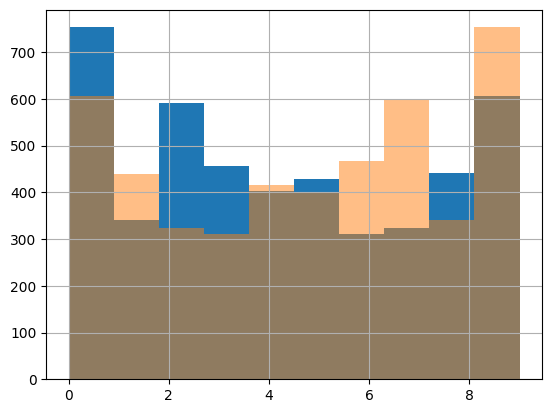

In [89]:
X_train['MHHUUR'].hist()
X_train['MHKOOP'].hist(alpha=0.5);

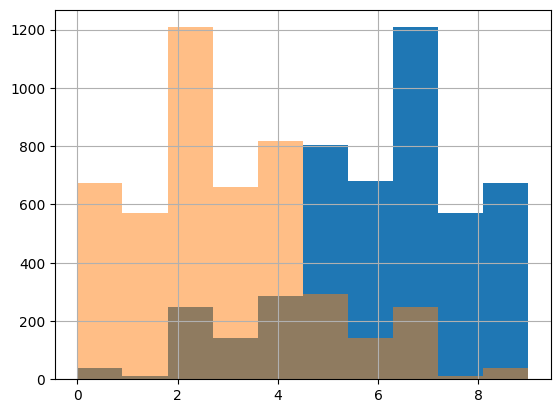

In [90]:
X_train['MZFONDS'].hist()
X_train['MZPART'].hist(alpha=0.5);

Retirer les variables MHHUUR et MZFONDS cause un gain de 1 TP et un gain de 2 FP.

In [91]:
featureTester.remove_list(['MHHUUR', 'MZFONDS'])
X = featureTester.flush_to_df()
model = featureTester.test_current(class_weight=1)

AUC         : 0.7970
Precision   : 0.1743
Recall      : 0.5429
F1          : 0.2639
Threshold   : 0.1000
[[915 180]
 [ 32  38]]


Pour l'instant je vais continuer à simplifier le modèle plus possible pour trouver qu'elle sont les variables les plus significatives. Si j'ajoute de la régularisation, les coefficients des variables seront modifé.

In [92]:
state_tracker = copy.deepcopy(featureTester)

In [93]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                   |     VIF |
|:----------------------------------|--------:|
| MOPLLAAG                          | 26.963  |
| MRELGE                            | 20.9287 |
| total_third_party_policies        | 20.5755 |
| PWAPART                           | 19.4403 |
| MFWEKIND                          | 19.2458 |
| MRELOV                            | 17.5977 |
| MOPLMIDD                          | 15.4279 |
| MFALLEEN                          | 13.6609 |
| MAUT1                             | 12.5045 |
| MAUT0                             | 12.3621 |
| MINKM30                           | 12.0987 |
| MOPLHOOG                          | 11.7341 |
| MGODPR                            | 11.1113 |
| MFGEKIND                          | 11.0453 |
| total_work_heavy_vehicle_policies | 11.0378 |
| MINK4575                          | 10.172  |


In [94]:
cols_to_remove = ['MOPLLAAG', 'MOPLMIDD']
s, is_to_scale = feature_tracker.getFeature('diff_educ_mid_bas')
featureTester.add('diff_educ_mid_bas', s, toScale=is_to_scale)
featureTester.remove_list(cols_to_remove)
X = featureTester.flush_to_df()

In [95]:
model = featureTester.test_current()

AUC         : 0.7914
Precision   : 0.1754
Recall      : 0.5286
F1          : 0.2633
Threshold   : 0.1000
[[921 174]
 [ 33  37]]


In [ ]:
# cols_to_remove_mink = ['MINKM30','MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM']
# s, is_to_scale = feature_tracker.getFeature('avg_area_income')
# featureTester.add('avg_area_income', s, toScale=is_to_scale)
# featureTester.remove_list(cols_to_remove_mink)
# X = featureTester.flush_to_df()

In [96]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                   |     VIF |
|:----------------------------------|--------:|
| MRELGE                            | 20.6278 |
| total_third_party_policies        | 20.5385 |
| PWAPART                           | 19.4035 |
| MFWEKIND                          | 18.4836 |
| MRELOV                            | 17.4601 |
| MFALLEEN                          | 12.8538 |
| MAUT1                             | 12.212  |
| MAUT0                             | 12.0936 |
| MINKM30                           | 11.6366 |
| total_work_heavy_vehicle_policies | 11.0376 |
| MGODPR                            | 10.9839 |
| MFGEKIND                          | 10.5935 |


0.95 ya aucune corr, mais 0.9 on a total_third_party_policies et PWAPART, sa fais du sens puisque PWAPART = Contribution private third party insurance, donc probablement si PWAPART plus élevé, alors total_third_party_policies aussi.

In [97]:
FeatureTools.find_correlated_cols(X, 0.9, toPlot=False)

[('PWAPART', 'total_third_party_policies')]

PINBOED $\equiv$ total_property_policies

MFALLEEN (single donc probablement prédit si enfant/marrier etc)

In [98]:
FeatureTools.find_correlated_cols(X, 0.85, toPlot=False)

[('MRELGE', 'MRELOV'),
 ('PFIETS', 'total_leisure_vehicle_policies'),
 ('PWAPART', 'total_third_party_policies'),
 ('PINBOED', 'total_property_policies')]

In [99]:
cols_to_remove = ['total_third_party_policies', 'total_property_policies', 'PFIETS', 'MFALLEEN', 'MRELGE']
featureTester.remove_list(cols_to_remove)

X = featureTester.flush_to_df()

X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                   |     VIF |
|:----------------------------------|--------:|
| MINKM30                           | 11.0267 |
| total_work_heavy_vehicle_policies | 10.9804 |
| MAUT0                             | 10.6388 |
| MAUT1                             | 10.3427 |


ok good

In [100]:
model = featureTester.test_current()

AUC         : 0.7871
Precision   : 0.1714
Recall      : 0.5143
F1          : 0.2571
Threshold   : 0.1000
[[921 174]
 [ 34  36]]


NICE, une variable significative de plus!

In [102]:
X = featureTester.flush_to_df()
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature                        |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-------------------------------|------------:|-------:|------------:|------------:|
| 38 | PPERSAUT                       |      0.1842 | 1.2022 |      1.1008 |      1.313  |
| 59 | total_leisure_vehicle_policies |      0.1207 | 1.1282 |      1.0262 |      1.2404 |

La prochaine étape selon moi serait de faire la même chose avec les variables P* donc les regrouper par catégorie, mais je viens d'y penser que si je fais sa peut-être je vais diluer l'effet de PPERSAUT. Peut-être que APERSAUT est peut-être significative comme PPERSAUT et la regrouper avec d'autre variable était pas une bonne idée? Je vais vérifier, peut-etre que maintenant que le modèle est plus simple, sont intervalle de confiance sera différents.

In [103]:
featureTester.restore('APERSAUT')
X = featureTester.flush_to_df()

X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].head().to_markdown())

|                                   |     VIF |
|:----------------------------------|--------:|
| total_daily_vehicle_policies      | 59.9635 |
| APERSAUT                          | 56.6633 |
| MINKM30                           | 11.0675 |
| total_work_heavy_vehicle_policies | 10.9824 |
| MAUT0                             | 10.952  |


Les deux variables avec une VIF la plus haute sont **APERSAUT** et **total_daily_vehicle_policies**

|                                   |     VIF |
|:----------------------------------|--------:|
| total_daily_vehicle_policies      | 59.9635 |
| APERSAUT                          | 56.6633 |
| MINKM30                           | 11.0675 |
| total_work_heavy_vehicle_policies | 10.9824 |
| MAUT0                             | 10.952  |

In [104]:
featureTester.restore_list(['APERSAUT', 'AMOTSCO', 'ABROM'])
X = featureTester.flush_to_df()
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
subset = X_train[y_train == 1][['APERSAUT', 'AMOTSCO', 'ABROM']]

all_values = sorted(set().union(*[subset[col].unique() for col in subset.columns]))

counts_df = pd.DataFrame({'Value': all_values})
for col in subset.columns:
    counts = subset[col].value_counts()
    counts_df[col] = counts_df['Value'].map(counts).fillna(0).astype(int)

print(counts_df.to_markdown(index=False))


|   Value |   APERSAUT |   AMOTSCO |   ABROM |
|--------:|-----------:|----------:|--------:|
|       0 |         62 |       264 |     270 |
|       1 |        190 |        13 |       8 |
|       2 |         26 |         1 |       0 |


Je crois que c'est a cause de sa que leur VIF est élevé et semblable.
APERSAUT à la majorité des CARAVAN = 1, $\dfrac{216}{238} \approx 0.91$

| Value tel que CARAVAN = 1 | APERSAUT | AMOTSCO | ABROM |
| ----- | -------- | ------- | ----- |
| 0     | 62       | 264     | 270   |
| 1     | 190      | 13      | 8     |
| 2     | 26       | 1       | 0     |
| TOTAL (value > 0)| 216      | 14      | 8     |

Alors, je crois que c'est mieux de séparer la catégorie total_daily_vehicle_policies en deux. APERSAUT et total_motorized_two_wheels_vehicules (AMOTSCO + ABROM). 

In [105]:
cols_to_remove = ['total_daily_vehicle_policies', 'APERSAUT', 'AMOTSCO', 'ABROM']
featureTester.remove_list(cols_to_remove)

two_wheels_motorized_vehicules = ['AMOTSCO', 'ABROM']

featureTester.restore('APERSAUT')
featureTester.add('total_motorized_two_wheels_vehicules', df[two_wheels_motorized_vehicules].sum(axis=1), toScale=True)

X = featureTester.flush_to_df()
model = featureTester.test_current()

AUC         : 0.7879
Precision   : 0.1818
Recall      : 0.5429
F1          : 0.2724
Threshold   : 0.1000
[[924 171]
 [ 32  38]]


| Variables  | Confusion Matrix |
|-------------------|-----------------|
| total_daily_vehicle_policies | $\begin{bmatrix} 921 & 174 \\ 34 & 36 \end{bmatrix}$ |
| ['APERSAUT', 'total_motorized_two_wheels_vehicules'] | $\begin{bmatrix} 924 & 171 \\ 32 & 38 \end{bmatrix}$ |

Je vais vérifier dans les autres variables que j'ai groupé s'il n'y pas une qui domine, si oui je vais la séparer comme j'ai fais avec APERSAUT, puisque séparer APERSAUT ma redonner 2 TP et en baissant le nombre de FP. En plus, on peut voir qu'elle ne fait plus partie des variables avec haute multicolinéarité.

In [106]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                      |     VIF |
|:-------------------------------------|--------:|
| total_motorized_two_wheels_vehicules | 16.7035 |
| PBROM                                | 11.4576 |
| MINKM30                              | 11.0243 |
| total_work_heavy_vehicle_policies    | 10.9825 |
| MAUT0                                | 10.6273 |
| MAUT1                                | 10.3399 |


In [ ]:
feature_groups = {
    'total_life_health_policies': ['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'],
    'total_third_party_policies': ['AWAPART','AWABEDR','AWALAND'],
    #'total_daily_vehicle_policies': ['APERSAUT','AMOTSCO','ABROM'],
    'total_work_heavy_vehicle_policies': ['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'],
    #'total_property_policies': ['AINBOED'],
    'total_leisure_vehicle_policies': ['APLEZIER','AFIETS','AZEILPL']
}

for new_feat, cols in feature_groups.items():
    featureTester.restore_list(cols)
X = featureTester.flush_to_df()
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()

for new_feat, cols in feature_groups.items():
    subset = X_train[y_train == 1][cols]
    all_values = sorted(set().union(*[subset[col].unique() for col in subset.columns]))

    counts_df = pd.DataFrame({'Value': all_values})
    for col in subset.columns:
        counts = subset[col].value_counts()
        counts_df[col] = counts_df['Value'].map(counts).fillna(0).astype(int)

    total_row = {'Value': 'Total (value > 0)'}
    for col in subset.columns:
        total_row[col] = subset[subset[col] > 0][col].count()
    counts_df = pd.concat([counts_df, pd.DataFrame([total_row])], ignore_index=True)

    total_values = [total_row[col] for col in cols]
    highest = max(total_values)
    total_sum = sum(total_values)
    proportion = round(highest / total_sum, 4) if total_sum > 0 else 0
    
    print(f'$\\dfrac{{{highest}}}{{{total_sum}}} \\approx {proportion}$')
    print(counts_df.to_markdown(index=False))
    featureTester.remove_list(cols)
    print()

X = featureTester.flush_to_df()

ABRAND (Number of fire policies) domine clairement. $\dfrac{187}{224} \approx 0.8348$
- Je vais retirer ABRAND de total_life_health_policies et créer total_other_life_health_policies.

| Value             |   ALEVEN |   APERSONG |   AGEZONG |   AWAOREG |   ABRAND |   ABYSTAND |
|:------------------|---------:|-----------:|----------:|----------:|---------:|-----------:|
| 0                 |      261 |        277 |       275 |       274 |       91 |        266 |
| 1                 |        4 |          1 |         3 |         4 |      180 |         12 |
| 2                 |        8 |          0 |         0 |         0 |        7 |          0 |
| 3                 |        2 |          0 |         0 |         0 |        0 |          0 |
| 4                 |        3 |          0 |         0 |         0 |        0 |          0 |
| Total (value > 0) |       17 |          1 |         3 |         4 |      187 |         12 |


AWAPART (Number of private third party insurance) domine clairement. $\dfrac{158}{162} \approx 0.9753$
- Je vais retirer AWAPART de total_third_party_policies et créer une variable total_other_third_party_policies

| Value             |   AWAPART |   AWABEDR |   AWALAND |
|:------------------|----------:|----------:|----------:|
| 0                 |       120 |       276 |       276 |
| 1                 |       158 |         2 |         2 |
| Total (value > 0) |       158 |         2 |         2 |


Rien de spécial pour lui.

| Value             |   AVRAAUT |   ATRACTOR |   AWERKT |   AAANHANG |   ABESAUT |
|:------------------|----------:|-----------:|---------:|-----------:|----------:|
| 0                 |       278 |        276 |      278 |        272 |       276 |
| 1                 |         0 |          2 |        0 |          6 |         2 |
| Total (value > 0) |         0 |          2 |        0 |          6 |         2 |

 
Içi, APLEZIER et AFIETS sont proche, donc je vais pas toucher à lui.
| Value             |   APLEZIER |   AFIETS |   AZEILPL |
|:------------------|-----------:|---------:|----------:|
| 0                 |        266 |      267 |       277 |
| 1                 |         11 |        7 |         1 |
| 2                 |          1 |        3 |         0 |
| 3                 |          0 |        1 |         0 |
| Total (value > 0) |         12 |       11 |         1 |


In [108]:
to_restore_cols = ['ABRAND', 'AWAPART']
featureTester.restore_list(to_restore_cols)

to_remove_cols = ['total_life_health_policies', 'total_third_party_policies']
featureTester.remove_list(to_remove_cols)

total_other_life_health_policies = ['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABYSTAND']
total_other_third_party_policies = ['AWABEDR','AWALAND']

featureTester.add('total_other_life_health_policies', df[total_other_life_health_policies].sum(axis=1), toScale=True)
featureTester.add('total_other_third_party_policies', df[total_other_third_party_policies].sum(axis=1), toScale=True)

X = featureTester.flush_to_df()

In [109]:
model = featureTester.test_current()

AUC         : 0.7849
Precision   : 0.1827
Recall      : 0.5429
F1          : 0.2734
Threshold   : 0.1000
[[925 170]
 [ 32  38]]


Aucun changement dramatique, le modèle prédit un FP de moins.

Maintenant, si on regarde le tableau de VIF, on voit : 
- AWAPART et PWAPART avec presque le meme VIF, donc sont probablement fortement corrélés?
- total_motorized_two_vehicules et PBROM (contribution moped policies) sont présentes et sa m'étonnerais pas qu'elle soit corrélés, mais je vais rien faire pour l'instant jusqu'à temps que je regroupe les variables P* ensembles.

In [110]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                      |     VIF |
|:-------------------------------------|--------:|
| AWAPART                              | 27.6755 |
| PWAPART                              | 27.5583 |
| total_motorized_two_wheels_vehicules | 16.7235 |
| PBROM                                | 11.4607 |
| total_work_heavy_vehicle_policies    | 11.1514 |
| MINKM30                              | 11.0237 |
| MAUT0                                | 10.6368 |
| total_other_third_party_policies     | 10.5098 |
| MAUT1                                | 10.3376 |


Et oui, PWAPART et AWAPART sont des paires corrélés à 95%. 

Je vais retirer AWAPART (number of third party insurance), car j'ai des ranges pour les valeurs de PWAPART (contribution to third party insurance). Je me dit que savoir combien un client dépense sur ces assurances tierces serait plus utile que savoir combien d'assurance tierce un client a.

In [111]:
cols_to_drop_too_correlated_1 = FeatureTools.find_correlated_cols(X_train, toPlot=False)
cols_to_drop_too_correlated_1

[('PWAPART', 'AWAPART')]

In [112]:
featureTester.remove('AWAPART')
X = featureTester.flush_to_df()

In [113]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                      |     VIF |
|:-------------------------------------|--------:|
| total_motorized_two_wheels_vehicules | 16.7214 |
| PBROM                                | 11.4606 |
| total_work_heavy_vehicle_policies    | 11.1514 |
| MINKM30                              | 11.0203 |
| MAUT0                                | 10.6341 |
| total_other_third_party_policies     | 10.5082 |
| MAUT1                                | 10.3376 |


Maintenant, je vais regrouper les variables P de la même facons. Les mêmes variables domines sur les autres.

In [114]:
to_restore_cols = ['PBRAND', 'PWAPART']
featureTester.restore_list(to_restore_cols)

total_other_life_health_contribution = ['PLEVEN','PPERSONG','PGEZONG','PWAOREG','PBYSTAND']
total_other_third_party_contribution = ['PWABEDR','PWALAND']
total_two_wheels_motorized_contribution = ['PMOTSCO','PBROM']
total_work_heavy_vehicle_contribution = ['PVRAAUT','PTRACTOR','PWERKT','PAANHANG','PBESAUT']
total_leisure_vehicle_contribution = ['PPLEZIER','PFIETS','PZEILPL']

all_total_contribution_to_remove = (
    total_other_life_health_contribution
    + total_other_third_party_contribution
    + total_two_wheels_motorized_contribution
    + total_work_heavy_vehicle_contribution
    + total_leisure_vehicle_contribution
)

featureTester.add('total_other_life_health_contribution', df[total_other_life_health_contribution].sum(axis=1), toScale=True)
featureTester.add('total_other_third_party_contribution', df[total_other_third_party_contribution].sum(axis=1), toScale=True)
featureTester.add('total_two_wheels_motorized_contribution', df[total_two_wheels_motorized_contribution].sum(axis=1), toScale=True)
featureTester.add('total_work_heavy_vehicle_contribution', df[total_work_heavy_vehicle_contribution].sum(axis=1), toScale=True)
featureTester.add('total_leisure_vehicle_contribution', df[total_leisure_vehicle_contribution].sum(axis=1), toScale=True)

featureTester.remove_list(all_total_contribution_to_remove)

X = featureTester.flush_to_df()

In [115]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                         |     VIF |
|:----------------------------------------|--------:|
| total_motorized_two_wheels_vehicules    | 11.5793 |
| total_two_wheels_motorized_contribution | 11.4544 |
| MINKM30                                 | 11.0009 |
| MAUT0                                   | 10.5787 |
| total_other_third_party_contribution    | 10.388  |
| MAUT1                                   | 10.2853 |


On voit que les paires 'total_motorized_two_wheels_vehicules' et 'total_two_wheels_motorized_contribution' sont corrélés $\geq$ 95%, donc je vais retirer une des deux au choix.

In [116]:
cols_to_drop_too_correlated_1 = FeatureTools.find_correlated_cols(X_train, toPlot=False)
cols_to_drop_too_correlated_1

[('total_motorized_two_wheels_vehicules',
  'total_two_wheels_motorized_contribution')]

In [117]:
featureTester.remove('total_motorized_two_wheels_vehicules')
X = featureTester.flush_to_df()

Pour le reste des variables, une analyse plus profonde est nécessaire parce que je n'ai pas d'idée.

In [118]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

|                                      |     VIF |
|:-------------------------------------|--------:|
| MINKM30                              | 11.0007 |
| MAUT0                                | 10.5764 |
| total_other_third_party_contribution | 10.3865 |
| MAUT1                                | 10.2823 |


Je vais analyser les coefficients des variables voir lesquels influences le plus.

On voit que c'est les autres variables MINK* qui ont la plus grande valeur absolue dans leur coefficients.

C'est aussi pareil avec tout les autres variables MINK*, les coefficients les plus élevés sont tous des variables MINK*. Donc la variable avg_area_income était probablement un bon choix pour simplifier le modèle.

In [119]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols, return_coef=True)
df_vif[df_vif['Target'] == 'MINKM30'].sort_values(by='coef', key=abs, ascending=False).head()

,Target,Variable,coef
1540,MINKM30,MINK3045,-0.863626
1541,MINKM30,MINK4575,-0.835939
1542,MINKM30,MINK7512,-0.623258
1543,MINKM30,MINK123M,-0.484302
1536,MINKM30,MAUT1,0.310882


In [120]:
cols_mink_income = ['MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM']
s_to_add, is_to_scale = feature_tracker.getFeature('avg_area_income')
featureTester.remove_list(cols_mink_income)
featureTester.add('avg_area_income', s_to_add, toScale=is_to_scale)
X = featureTester.flush_to_df()
model = featureTester.test_current()

AUC         : 0.7885
Precision   : 0.1806
Recall      : 0.5571
F1          : 0.2727
Threshold   : 0.1000
[[918 177]
 [ 31  39]]


In [121]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 8].to_markdown())

|                                      |      VIF |
|:-------------------------------------|---------:|
| total_other_third_party_contribution | 10.3709  |
| MAUT0                                |  9.99364 |
| MAUT1                                |  9.51733 |
| total_other_third_party_policies     |  9.411   |
| MGODPR                               |  9.32281 |
| MSKC                                 |  8.51335 |


les variables total_other_third_party_* sont pratiquement les mêmes, donc je vais retirer une au choix.

In [122]:
X = featureTester.flush_to_df()
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
subset = X_train[y_train == 1][['total_other_third_party_contribution', 'total_other_third_party_policies']]

all_values = sorted(set().union(*[subset[col].unique() for col in subset.columns]))

counts_df = pd.DataFrame({'Value': all_values})
for col in subset.columns:
    counts = subset[col].value_counts()
    counts_df[col] = counts_df['Value'].map(counts).fillna(0).astype(int)

HTML(counts_df.to_html(index=False))


Value,total_other_third_party_contribution,total_other_third_party_policies
-0.182647,274,0
-0.180521,0,274
4.541819,4,0
4.734705,0,4


In [123]:
# featureTester.remove('total_other_third_party_policies')
featureTester.remove('total_other_third_party_contribution')
X = featureTester.flush_to_df()
model = featureTester.test_current()

AUC         : 0.7903
Precision   : 0.1831
Recall      : 0.5571
F1          : 0.2756
Threshold   : 0.1000
[[921 174]
 [ 31  39]]


Aucune variable a une VIF en haut de 10 maintenant.

In [124]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 10].to_markdown())

| VIF   |
|-------|


Mais si on regarde les paires fortement corrélés, on trouve ces paires avec une corrélation de 90%.
- Je crois que finalement sa serait mieux de remettre la variable total_daily_vehicle_policies au lieu de la séparer pour eviter ce problème. Mais, peut-etre que plus tard sa serait mieux de la séparer parce que la séparer m'avais ajouter 2 TP de plus tantot.

In [125]:
cols_to_drop_too_correlated_1 = FeatureTools.find_correlated_cols(X_train, threshold=0.9, toPlot=False)
cols_to_drop_too_correlated_1

[('PPERSAUT', 'APERSAUT'),
 ('total_work_heavy_vehicle_policies',
  'total_work_heavy_vehicle_contribution')]

Je vais garder total_work_heavy_vehicle_policies, elle contient moins de variable isoler.

In [126]:
X = featureTester.flush_to_df()
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
subset = X_train[y_train == 1][['total_work_heavy_vehicle_policies', 'total_work_heavy_vehicle_contribution']]

all_values = sorted(set().union(*[subset[col].unique() for col in subset.columns]))

counts_df = pd.DataFrame({'Value': all_values})
for col in subset.columns:
    counts = subset[col].value_counts()
    counts_df[col] = counts_df['Value'].map(counts).fillna(0).astype(int)

HTML(counts_df.to_html(index=False))

Value,total_work_heavy_vehicle_policies,total_work_heavy_vehicle_contribution
-0.171947,0,269
-0.163545,269,0
0.771026,0,1
1.713998,0,4
2.324908,8,0
2.656970,0,1
4.542914,0,1
4.813362,1,0
5.485886,0,1
7.371830,0,1


In [127]:
featureTester.remove('total_work_heavy_vehicle_contribution')
featureTester.remove('APERSAUT')
featureTester.restore('total_daily_vehicle_policies')
X = featureTester.flush_to_df()
model = featureTester.test_current()

AUC         : 0.7911
Precision   : 0.1845
Recall      : 0.5429
F1          : 0.2754
Threshold   : 0.1000
[[927 168]
 [ 32  38]]


In [128]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                              |      VIF |
|:-----------------------------|---------:|
| MAUT0                        | 10.0093  |
| MAUT1                        |  9.5372  |
| MGODPR                       |  9.32632 |
| MSKC                         |  8.50924 |
| MSKA                         |  7.83457 |
| MGODGE                       |  7.44757 |
| MBERHOOG                     |  7.10348 |
| MBERMIDD                     |  6.94005 |
| total_daily_vehicle_policies |  6.92575 |
| MBERARBG                     |  6.19038 |
| MFWEKIND                     |  6.11449 |
| MBERARBO                     |  5.91716 |
| PPERSAUT                     |  5.72528 |
| MAUT2                        |  5.15893 |


MSKC, MAUT0, MGODGE seront des classes de référence pour leur catégorie

In [129]:
featureTester.remove_list(['MAUT0', 'MSKC', 'MGODGE'])
X = featureTester.flush_to_df()
model = featureTester.test_current()

AUC         : 0.7816
Precision   : 0.2000
Recall      : 0.5571
F1          : 0.2943
Threshold   : 0.1000
[[939 156]
 [ 31  39]]


In [130]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                              |     VIF |
|:-----------------------------|--------:|
| total_daily_vehicle_policies | 6.87378 |
| MFWEKIND                     | 5.83199 |
| MBERHOOG                     | 5.75973 |
| PPERSAUT                     | 5.66711 |
| MSKA                         | 5.35741 |


In [131]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols, return_coef=True)
df_vif[df_vif['Target'] == 'PPERSAUT'].sort_values(by='coef', key=abs, ascending=False).head()

,Target,Variable,coef
1231,PPERSAUT,total_daily_vehicle_policies,2.890237
1228,PPERSAUT,total_two_wheels_motorized_contribution,-1.487950
1219,PPERSAUT,MOSTYPE_4,0.215492
1216,PPERSAUT,PINBOED,-0.191094
1225,PPERSAUT,ABRAND,-0.188201


In [132]:
featureTester.remove('total_daily_vehicle_policies')
X = featureTester.flush_to_df()

In [133]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

|          |     VIF |
|:---------|--------:|
| MFWEKIND | 5.83035 |
| MBERHOOG | 5.72664 |
| MSKA     | 5.35607 |


MGEMOMV = avg size household donc surement prédit MFWEKIND (household with children)
- Si area avec un avg size household petit, alors fort probable qu'il y a moins d'enfants puisque la majorité des enfants habite avec 2 adultes.

In [134]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols, return_coef=True)
df_vif[df_vif['Target'] == 'MFWEKIND'].sort_values(by='coef', key=abs, ascending=False).head()

,Target,Variable,coef
388,MFWEKIND,MGEMOMV,1.321751
395,MFWEKIND,MFGEKIND,-0.540836
402,MFWEKIND,MBERARBO,0.313782
416,MFWEKIND,MOSTYPE_2,-0.312889
401,MFWEKIND,MBERARBG,0.274247


In [135]:
featureTester.remove('MFWEKIND')
X = featureTester.flush_to_df()

Un environnement avec un MBERHOOG (High status) élevé doit probablement avoir un MSKA (Social class A) élevé, car les personnes de haut status font partie de la haute classe en général.

In [136]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

|          |     VIF |
|:---------|--------:|
| MBERHOOG | 5.56217 |
| MSKA     | 5.35401 |


In [137]:
featureTester.remove('MBERHOOG')
X = featureTester.flush_to_df()

In [138]:
X_train, y_train, X_val, y_val = featureTester.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|


Cool, maintenant, aucune variable a une VIF $\geq$ 5.

In [139]:
model = featureTester.test_current()

AUC         : 0.7762
Precision   : 0.1888
Recall      : 0.5286
F1          : 0.2782
Threshold   : 0.1000
[[936 159]
 [ 33  37]]


In [140]:
cols_to_drop_too_correlated_1 = FeatureTools.find_correlated_cols(X_train, threshold=0.85, toPlot=False)
cols_to_drop_too_correlated_1

[('PBRAND', 'ABRAND'),
 ('total_other_life_health_policies', 'total_other_life_health_contribution')]

Après le regroupement et la suppression de certaines variables, aucune variable ne présente un VIF supérieur à 5. L’absence de multicolinéarité problématique garantit la stabilité des coefficients estimés, ce qui permet d’identifier et d’interpréter de manière fiable les variables statistiquement significatives.

In [141]:
X = featureTester.flush_to_df()
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 25 | PPERSAUT                           |      0.1819 | 1.1995 |      1.1425 |      1.2593 |
| 40 | total_leisure_vehicle_contribution |      0.1311 | 1.1401 |      1.0368 |      1.2537 |
|  8 | MFGEKIND                           |     -0.0985 | 0.9062 |      0.8275 |      0.9923 |
| 20 | MAUT1                              |     -0.1143 | 0.892  |      0.8024 |      0.9915 |
| 14 | MBERARBO                           |     -0.1314 | 0.8769 |      0.7877 |      0.9762 |
| 13 | MBERARBG                           |     -0.1579 | 0.8539 |      0.7718 |      0.9448 |
|  7 | MRELOV                             |     -0.1613 | 0.851  |      0.7683 |      0.9427 |

**Variable $OR > 1$** : 
- PPERSAUT (Contribution car policies), +1 contribution police auto $\to$ +20% odds
- total_leisure_vehicle_contribution, +1 contribution vehicule recreationel $\to$ +14% odds

**Variable $OR < 1$** : 
- MFGEKIND (Household without children), plus un quartier a moins de maison avec enfants $\to$ -10% odds
- MAUT1 (1 car), plus un quartier a de '1 voiture' $\to$ -11% odds
- MBERARBO (unskilled laborer), plus un quartier à de travailleur non-skilled $\to$ -13% odds
- MBERARBG (skilled laborer), plus un quartier à de travailleur skilled $\to$ -15% odds
- MRELOV (other relation), plus un quartier à de autre relation $\to$ -15%

Maintenant, si j'entraine le modèle seulement avec les variables significatives. Il trouve 26 TP, ce qui est beaucoup plus bas que avec tout les variables, mais correct en vrai. 

In [266]:
features_significatifs = [
    "PPERSAUT",
    "total_leisure_vehicle_contribution",
    "MFGEKIND",
    "MAUT1",
    "MBERARBO",
    "MBERARBG",
    "MRELOV"
]

X_train_sel = X_train[features_significatifs]
X_val_sel = X_val[features_significatifs]

print('|----- Avec tout les variables (VIF < 5) -----|')
model = featureTester.test_current()
print()

print('|----- Seulement les variables significatives -----|')
model = Model.create_model(X_train_sel, y_train, X_val_sel, y_val, learning_rate=0.01, set_threshold_to=0.1)
model.print_stats(X_val_sel, y_val)

|----- Avec tout les variables (VIF < 5) -----|
AUC         : 0.7762
Precision   : 0.1888
Recall      : 0.5286
F1          : 0.2782
Threshold   : 0.1000
[[936 159]
 [ 33  37]]

|----- Seulement les variables significatives -----|
AUC         : 0.7040
Precision   : 0.1244
Recall      : 0.3714
F1          : 0.1864
Threshold   : 0.1000
[[912 183]
 [ 44  26]]


In [267]:
X_val_sel_old = X_val_sel.copy()
X_train_sel_old = X_train_sel.copy()

Dans le set d'évaluation, il y a un total de 70 CARAVAN = 1. 

57 ont un PPERSAUT de 6! Mais le modèle prédit seulement 23 de ces 57 comme TP.

Je crois que PPERSAUT = 6 à besoin de condition complémentaire pour aider le modèle.  

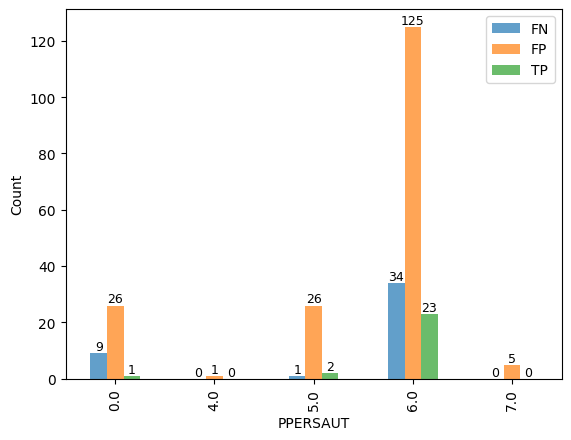

In [248]:
df_profiles = FeatureTools.get_df_val_analysis(X_val_sel, y_val, model.w, model.b, threshold=0.1, raw=True)
df_plot = (
    df_profiles[df_profiles["Group"].isin(["FP", "FN", "TP"])]
    .groupby(["PPERSAUT", "Group"])
    .size()
    .unstack(fill_value=0)
)
ax = df_plot.plot(kind="bar", alpha=0.7)
for container in ax.containers:ax.bar_label(container, label_type="edge", fontsize=9)

plt.legend()
plt.xlabel("PPERSAUT")
plt.ylabel("Count");

À PPERSAUT = 6, ce qui décide probablement si c'est un FN ou TP est probablement MBERARBO (Unskilled labourers) et MRELOV (Other relation). Précédemment, on avait trouver que chaque augmentation de ces variables réduit les odds de 13% et 15% respectivement.
75% des FP et TP ont MBERARBO $\leq 2$ 

In [249]:
subset = df_profiles[
    (df_profiles["PPERSAUT"] == 6) &
    (df_profiles["Group"].isin(["TP", "FN", "FP"]))
]

Markdown(subset.groupby("Group").quantile(.75).to_markdown())

| Group   |   PPERSAUT |   total_leisure_vehicle_contribution |   MFGEKIND |   MAUT1 |   MBERARBO |   MBERARBG |   MRELOV |
|:--------|-----------:|-------------------------------------:|-----------:|--------:|-----------:|-----------:|---------:|
| FN      |          6 |                            -0.139075 |          5 |       7 |        3   |          3 |        3 |
| FP      |          6 |                            -0.139075 |          4 |       7 |        2   |          3 |        2 |
| TP      |          6 |                            -0.139075 |          4 |       7 |        1.5 |          2 |        2 |

22 sur 34 des FN ont un MBERARBO $\leq 2$. Je crois que sa serait utile de changer la variable MBERARBO a une variable binaire.

In [250]:
len(df_profiles[
    (df_profiles["PPERSAUT"] == 6) &
    (df_profiles["Group"] == "FN") &
    (df_profiles["MBERARBO"] <= 2)
]["MBERARBO"])


22

In [264]:
X_train_sel = X_train_sel_old.copy()
X_val_sel = X_val_sel_old.copy()

In [265]:
print('|----- Avant la variable binaire -----|')
model.print_stats(X_val_sel, y_val)
print()

X_train_sel = X_train_sel.copy()
X_train_sel["MBERARBO_low"] = (X_train_sel["MBERARBO"] <= 3).astype(int)
X_val_sel = X_val_sel.copy()
X_val_sel["MBERARBO_low"] = (X_val_sel["MBERARBO"] <= 3).astype(int)

X_train_sel = X_train_sel.drop(columns=["MBERARBO"])
X_val_sel = X_val_sel.drop(columns=["MBERARBO"])

print('|----- Avec la variable binaire -----|')
model = Model.create_model(X_train_sel, y_train, X_val_sel, y_val, learning_rate=0.01, set_threshold_to=0.1)
model.print_stats(X_val_sel, y_val)

|----- Avant la variable binaire -----|
AUC         : 0.6553
Precision   : 0.1105
Recall      : 0.3000
F1          : 0.1615
Threshold   : 0.1000
[[926 169]
 [ 49  21]]

|----- Avec la variable binaire -----|
AUC         : 0.6762
Precision   : 0.1111
Recall      : 0.3286
F1          : 0.1661
Threshold   : 0.1000
[[911 184]
 [ 47  23]]


In [ ]:
for c in featureTester.get_features_cols():
    data = X_train[c]
    mean_val = data.mean()
    median_val = data.median()
    
    x1 = min(X_train[c])
    xn = max(X_train[c])
    q1 = X_train[c].quantile(0.25)
    q3 = X_train[c].quantile(0.75)
    iqr = q3 - q1

    li = max(x1, q1 - 1.5 * iqr)
    ls = min(xn, q3 + 1.5 * iqr)

    outliers = []
    caravan_outliers = 0
    for idx, x in enumerate(data):
        if x < li or x > ls:
            outliers.append(x)
            if y_train.iloc[idx] == 1:
                caravan_outliers += 1
    
    print(f'{c}')
    print(f'    Mean = {mean_val:.2f}, Median = {median_val:.2f}')
    print(f'    IQR = {iqr:.2f}, Li = {li:.2f}, ls = {ls:.2f}')
    print(f'    Number of outliers = {len(outliers)}')
    print(f'    Number of CARAVAN=1 among outliers = {caravan_outliers}')
    print(f'    Example outliers: {outliers[:5]}') 
    print('---------------------------------------------')

In [355]:
fi = FeatureTools.fisher_info(X_train, model.w, model.b)
df_fi = pd.DataFrame({
    'feature': X.drop('CARAVAN', axis=1).columns,
    'FI': np.diag(fi)
}).sort_values(by='FI', ascending=False)

top_n = 20
df_fi.head(top_n).plot.barh(x='feature', y='FI', figsize=(10,6), color='skyblue')
plt.gca().invert_yaxis()  # la plus importante en haut
plt.xlabel('Fisher Information')
plt.title('Top features for predicting CARAVAN=1')
plt.show()

ValueError: Dot product shape mismatch, (4656, 81) vs (93,)

$OR = 1$ -> aucun effet \
$OR > 1$ -> augmente les odds \
$OR < 1$ -> diminue les odds \
chaque unité de $X$ multiplie les odds par OR

|    | feature   |   $\beta_n$ |   $OR$ |   $b_{i_{OR}}$ |   $b_{s_{OR}}$ |
|---:|:----------|------------:|-------:|---------------:|---------------:|
| 44 | PPERSAUT  |      0.1973 | 1.2181 |         1.1096 |         1.3372 |
| 56 | PBRAND    |      0.0948 | 1.0994 |         0.9405 |         1.2852 |
| 41 | PWAPART   |      0.0793 | 1.0825 |         0.5399 |         2.1703 |
| 58 | PPLEZIER  |      0.0637 | 1.0658 |         0.3952 |         2.8741 |
| 62 | AWAPART   |      0.0344 | 1.035  |         0.2611 |         4.103  |
| 19 | MBERMIDD  |      0.0338 | 1.0344 |         0.8451 |         1.2661 |
| 61 | PBYSTAND  |      0.0332 | 1.0338 |         0.4398 |         2.4301 |
| 37 | MINK7512  |      0.0332 | 1.0337 |         0.8325 |         1.2835 |
| 55 | PWAOREG   |      0.0325 | 1.033  |         0.412  |         2.5904 |
| 65 | APERSAUT  |      0.0323 | 1.0328 |         0.6849 |         1.5573 |

In [ ]:
profile_tp = X_tp_df.describe()
profile_fp = X_fp_df.describe()
profile_tn = X_tn_df.describe()
profile_fn = X_fn_df.describe()

var_to_check = ['FN_ensemble_noKids_notReligious','total_contribution', 'MHKOOP', 'diff_educ_mid_bas', 'MRELSA', 'MFGEKIND' ,'MFWEKIND', 'MGODGE', 'MRELGE', 'MRELOV', 'MGODPR', 'MGODRK'] 

tp_html = profile_tp[var_to_check].to_html()
fp_html = profile_fp[var_to_check].to_html()
tn_html = profile_tn[var_to_check].to_html()
fn_html = profile_fn[var_to_check].to_html()

html = (f"""
<div style="display:flex; gap:20px; flex-wrap:wrap">
    <div>
        <h3 style="text-align:center;">True Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tn_df)}</p>
        {tn_html}
    </div>
    <div>
        <h3 style="text-align:center;">False Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fn_df)}</p>
        {fn_html}
    </div>
    <div>
        <h3 style="text-align:center;">False Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fp_df)}</p>
        {fp_html}
    </div>
    <div>
        <h3 style="text-align:center;">True Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tp_df)}</p>
        {tp_html}
    </div>
</div>
""")

print(html)

In [ ]:
from IPython.display import HTML
import pandas as pd
import matplotlib

profile_tp = X_tp_df.median()
profile_fp = X_fp_df.median()
profile_tn = X_tn_df.median()
profile_fn = X_fn_df.median()

#var_to_check = ['total_contribution', 'MHKOOP', 'diff_educ_mid_bas', 'MRELSA', 'MFGEKIND' ,'MFWEKIND', 'MGODGE', 'MRELGE', 'MRELOV', 'MGODPR'] 
var_to_check = ['total_contribution', 'MHKOOP', 'diff_educ_mid_bas', 'MRELSA', 'MFGEKIND' ,'MFWEKIND', 'MGODGE', 'MRELGE', 'MRELOV', 'MGODPR', 'MGODRK'] 

# Build DataFrame
df_profiles = pd.DataFrame({
    'TN': profile_tn[var_to_check],
    'FN': profile_fn[var_to_check],
    'FP': profile_fp[var_to_check],
    'TP': profile_tp[var_to_check]
})
df_profiles.index.name = 'Variable'

# Function to color by row
def colorize_row(row):
    row_min = row.min()
    row_max = row.max()
    norm = matplotlib.colors.Normalize(vmin=row_min, vmax=row_max)
    cmap = matplotlib.colormaps["YlOrRd"]
    return [f'background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]:.2f}); color: black;'
            for val in row for rgba in [cmap(norm(val))]]

# Apply row-wise coloring
styler = df_profiles.style.apply(colorize_row, axis=1)
styler.set_table_attributes('style="border-collapse:collapse; width:60%;"')

# Display HTML
html = styler.to_html()
print(html)


In [ ]:
plot_tools.train_val_accuracy_plot(X_train_np, y_train_np, X_val_np, y_val_np, epochs_max=1000, learning_rate=learning_rate_optimized, l2_reg=True, lambda_const=lambda_const, extra_weight=12.4)

In [ ]:
from IPython.display import HTML
import pandas as pd
import matplotlib

profile_tp = X_tp_df.mean()
profile_fp = X_fp_df.mean()
profile_tn = X_tn_df.mean()
profile_fn = X_fn_df.mean()

#var_to_check = ['total_contribution', 'MHKOOP', 'diff_educ_mid_bas', 'MRELSA', 'MFGEKIND' ,'MFWEKIND', 'MGODGE', 'MRELGE', 'MRELOV', 'MGODPR'] 
var_to_check = ['total_contribution', 'MHKOOP', 'diff_educ_mid_bas', 'MRELSA', 'MFGEKIND' ,'MFWEKIND', 'MGODGE', 'MRELGE', 'MRELOV', 'MGODPR', 'MGODRK'] 

# Build DataFrame
df_profiles = pd.DataFrame({
    'TN': profile_tn[var_to_check],
    'FN': profile_fn[var_to_check],
    'FP': profile_fp[var_to_check],
    'TP': profile_tp[var_to_check]
})
df_profiles.index.name = 'Variable'

# Function to color by row
def colorize_row(row):
    row_min = row.min()
    row_max = row.max()
    norm = matplotlib.colors.Normalize(vmin=row_min, vmax=row_max)
    cmap = matplotlib.colormaps["YlOrRd"]
    return [f'background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]:.2f}); color: black;'
            for val in row for rgba in [cmap(norm(val))]]

# Apply row-wise coloring
styler = df_profiles.style.apply(colorize_row, axis=1)
styler.set_table_attributes('style="border-collapse:collapse; width:60%;"')

# Display HTML
html = styler.to_html()
print(html)


In [ ]:
L0 = data.get_dict("L0")

# Replace codes with labels for both groups
mostype_1 = df[df['CARAVAN'] == 1]['MOSTYPE'].map(L0).value_counts()
mostype_0 = df[df['CARAVAN'] == 0]['MOSTYPE'].map(L0).value_counts()

# Combine into one DataFrame
side_by_side = pd.DataFrame({
    "CARAVAN = 1": mostype_1,
    "CARAVAN = 0": mostype_0
}).fillna(0).astype(int)

side_by_side.sort_values(by="CARAVAN = 1", ascending=False)

In [ ]:
profiles = [ profile_fn]
#profiles = [profile_tp, profile_fp, profile_tn, profile_fn]
profile_names = [ 'False Negatives (FN)']
#profile_names = ['True Positives (TP)', 'False Positives (FP)', 'True Negatives (TN)', 'False Negatives (FN)']
import re

for i, profile in enumerate(profiles):

    # --- 0. Apply MOSTYPE renaming before filtering ---
    profile.index = [
        data.apply_Lx_to_index(idx, name="MOSTYPE", level='L0')
        for idx in profile.index
    ]

    # --- 1. Now detect rows that START with a MOSTYPE label ---
    # We look for any renamed index that used to be MOSTYPE
    mostype_index = [
        idx for idx in profile.index
        if not idx.startswith("MOSTYPE")  
        and any(char.isalpha() for char in idx)  # renamed labels are words
    ]

    # If you want a safer version:
    # mostype_index = [idx for idx in profile.index if "MOSTYPE" not in idx]

    mostype_data = profile.loc[mostype_index]

    # --- Print results ---
    print(f"\n### Profil : {profile_names[i]} ###")
    print(mostype_data.to_markdown())
    print("-" * 70)
    

In [ ]:
profile_tp = X_tp_df.mean().sort_values(ascending=False)
profile_fp = X_fp_df.mean().sort_values(ascending=False)
profile_tn = X_tn_df.mean().sort_values(ascending=False)
profile_fn = X_fn_df.mean().sort_values(ascending=False)

tp_html = profile_tp.head(30).to_frame().to_html()
fp_html = profile_fp.head(30).to_frame().to_html()
tn_html = profile_tn.head(30).to_frame().to_html()
fn_html = profile_fn.head(30).to_frame().to_html()

HTML(f"""
<div style="display:flex; gap:20px; flex-wrap:wrap">

    <div>
        <h3 style="text-align:center;">True Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tn_df)}</p>
        {tn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fn_df)}</p>
        {fn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fp_df)}</p>
        {fp_html}
    </div>

    <div>
        <h3 style="text-align:center;">True Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tp_df)}</p>
        {tp_html}
    </div>

</div>
""")

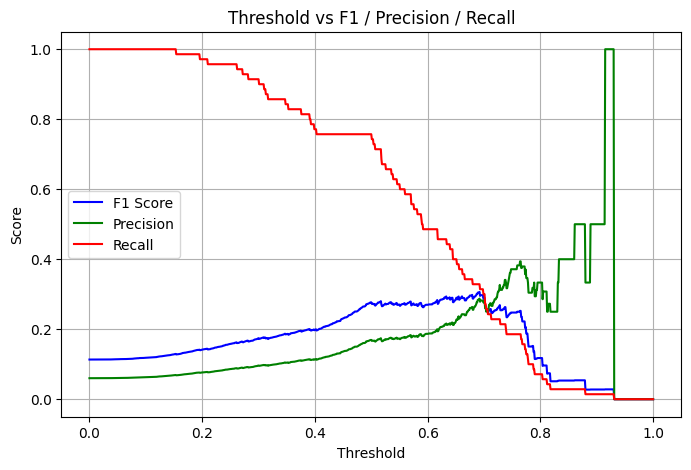

In [ ]:
plot_tools.plot_threshold_metrics(model, X_val_np, y_val_np, step=0.001)

In [ ]:
profile_tp = X_tp_df.mean().sort_values(ascending=False)
profile_fp = X_fp_df.mean().sort_values(ascending=False)
profile_tn = X_tn_df.mean().sort_values(ascending=False)
profile_fn = X_fn_df.mean().sort_values(ascending=False)

display(X_tp_df.describe())

display(X_fp_df.describe())

In [ ]:
import matplotlib
from IPython.display import HTML
import pandas as pd

# Colonnes d'intérêt
cols = ['MOPLLAAG', 'MOPLMIDD', 'MOPLHOOG']

df_profiles = pd.DataFrame({
    'Category': ['TN', 'FN', 'FP', 'TP'],
})

# Ajouter chaque colonne
for col in cols:
    df_profiles[col] = [
        profile_tn[col],
        profile_fn[col],
        profile_fp[col],
        profile_tp[col]
    ]

# Ajouter les colonnes Moyennes
df_profiles['Moyenne'] = df_profiles[cols].mean(axis=1)
df_profiles['Moyenne_2'] = df_profiles[['MOPLLAAG', 'MOPLMIDD']].mean(axis=1)
df_profiles['Diff_MID_LLAAG'] = df_profiles['MOPLMIDD'] - df_profiles['MOPLLAAG']  # nouvelle colonne

# Fonction pour coloriser par ligne (row-wise)
def colorize_row(row):
    row_min = row.min()
    row_max = row.max()
    norm = matplotlib.colors.Normalize(vmin=row_min, vmax=row_max)
    
    def f(val):
        cmap = matplotlib.colormaps["YlOrRd"]
        rgba = cmap(norm(val))
        return f'background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]}); color: black;'
    
    return [f(val) for val in row]

# Colonnes numériques pour la heatmap
numeric_cols = cols + ['Moyenne', 'Moyenne_2', 'Diff_MID_LLAAG']

# Appliquer le style
styler = df_profiles.style.apply(colorize_row, axis=1, subset=numeric_cols) \
                          .set_table_attributes('style="border-collapse:collapse; width:80%;"')

# Générer le code HTML
html_code = styler.to_html()
print(html_code)


In [ ]:
import matplotlib
from IPython.display import HTML
import pandas as pd

# New columns to include
cols = ['MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD']

# Create a new DataFrame for the profiles
df_profiles = pd.DataFrame({
    'Category': ['TN', 'FN', 'FP', 'TP'],
})

# Add each column from cols
for col in cols:
    df_profiles[col] = [
        profile_tn[col],
        profile_fn[col],
        profile_fp[col],
        profile_tp[col]
    ]

# Add the new average columns
df_profiles['Moyenne'] = df_profiles[cols].mean(axis=1)
df_profiles['Moyenne_B1B2C'] = df_profiles[['MSKB1', 'MSKB2', 'MSKC']].mean(axis=1)
df_profiles['Moyenne_B1B2'] = df_profiles[['MSKB1', 'MSKB2']].mean(axis=1)

# Function to colorize row-wise
def colorize_row(row):
    row_min = row.min()
    row_max = row.max()
    norm = matplotlib.colors.Normalize(vmin=row_min, vmax=row_max)
    
    def f(val):
        cmap = matplotlib.colormaps["YlOrRd"]
        rgba = cmap(norm(val))
        return f'background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]}); color: black;'
    
    return [f(val) for val in row]

# Apply the style to all numeric columns
numeric_cols = cols + ['Moyenne', 'Moyenne_B1B2C', 'Moyenne_B1B2']
styler = df_profiles.style.apply(colorize_row, axis=1, subset=numeric_cols) \
                          .set_table_attributes('style="border-collapse:collapse; width:90%;"')

# Generate HTML
html_code = styler.to_html()
print(html_code)


Je vais commencer par ajouter une nouvelle variable, car elle semble prometeuse. \
diff_edu_mid_bas

In [ ]:
model = Model.Model(w,b,f1_threshold, improvement="Model V1")
MODEL_V1 = "modelV1"
model_tracker.add(model, name=MODEL_V1)
model_tracker.set_preferred(MODEL_V1)

Model modelV1 existe deja, overriding...
Model modelV1 saved

Model modelV1 is now preferred.


J'ai l'impression que le modèle a atteint sa limite.

In [ ]:
sklearn_model = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=10000, class_weight='balanced', random_state=42)
sklearn_model.fit(X_train_np, y_train_np)
w_sklearn = sklearn_model.coef_[0]
b_sklearn = sklearn_model.intercept_[0]

f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w_sklearn, b_sklearn )

y_pred_proba_sk = sklearn_model.predict_proba(X_val_np)[:, 1]
y_pred_optimal_val = (y_pred_proba_sk >= f1_threshold).astype(int)


# Affichage des métriques finales (avec le seuil optimal)
from sklearn.metrics import confusion_matrix
print("\n--- Métriques SKLearn avec Seuil Optimal ---")
print(f"F1-thres : {f1_threshold:.4f}")
print(f"Matrice de Confusion:\n{confusion_matrix(y_val_np, y_pred_optimal_val)}")
#print(f"AUC: {roc_auc_score(y_val_np, y_pred_proba_sk):.4f}")
print(f"F1-Score: {f1_score(y_val_np, y_pred_optimal_val):.4f}")


--- Métriques SKLearn avec Seuil Optimal ---
F1-thres : 0.8200
Matrice de Confusion:
[[1031   64]
 [  49   21]]
F1-Score: 0.2710


Je vais re-évaluer les class weights pour affiner le modèle, puisque maintenant que j'ai optimisé les poids 

Maintenant nombre iter optimal

In [ ]:
categorical_vars, discrete_vars = data.get_var_by_types(df)
discrete_vars.remove('CARAVAN')

df_encoded = pd.get_dummies(df, columns=categorical_vars, prefix=categorical_vars, dtype=int)
print(df_encoded.dtypes)


MAANTHUI       int64
MGEMOMV        int64
MGEMLEEF       int64
MGODRK         int64
MGODPR         int64
               ...  
MOSHOOFD_6     int64
MOSHOOFD_7     int64
MOSHOOFD_8     int64
MOSHOOFD_9     int64
MOSHOOFD_10    int64
Length: 134, dtype: object


(2025-11-12)
J'ai oublier de one-hot code les variables MOSHOOFD et MOSTYPE. Elles sont categorique, mais pas ordinale. Mes résultats sont pas mal différents maintenant.

In [ ]:
X = df_encoded.drop('CARAVAN', axis=1) 
y = df_encoded['CARAVAN']  #targets

X_train, X_val, y_train, y_val = data.get_split_train_eval_data(df_encoded)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()

In [ ]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np)

Iteration 0: Cost = 0.6931471805599452
Iteration 100: Cost = 0.2153636686007336
Iteration 200: Cost = 0.21049395901189405
Iteration 300: Cost = 0.2080377100140786
Iteration 400: Cost = 0.20659973578995863
Iteration 500: Cost = 0.2056581102317727
Iteration 600: Cost = 0.20498405318644572
Iteration 700: Cost = 0.20446697987594464
Iteration 800: Cost = 0.20404888252915485
Iteration 900: Cost = 0.20369711341448316


In [ ]:
threshold = 0.1 #trop bas
model = Model.Model(w, b, threshold)
model_tracker.add(model)
model.print_stats(X_val_np, y_val_np)

Model v1 saved

Threshold:  0.1
Accuracy:  0.8171673819742489
[[915 180]
 [ 33  37]]
AUC:  0.7950554468362687


Présentement le modèle est vraiment pas bon. Même avec un threshold de 0.1, il prédit seulement 37 qui ont besoin d'une assurance caravan en plus avec un threshold de seulement 0.1

In [ ]:
print(np.bincount(y_train_np))

[4378  278]


La classe est imbalanced.

Vu que la majoriter est "pas besoin d'assurance caravan", le modèle apprend probablement plutot a prédire: qui n'a pas besoin d'assurance caravan.

Donc je vais ajuster les weights pour que lorsque le modèle prédit incorrectement que quelqu'un a pas besoin d'assurance Caravan et qu'il ai tord, il sera pénaliser x fois plus. Comme ça, il va faire plus attention à eux que ceux qui n'ont pas besoin d'assurance caravan.

In [ ]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=ratio)

Iteration 0: Cost = 1.3035216307952924
Iteration 100: Cost = 1.1388425304646177
Iteration 200: Cost = 1.121400976538757
Iteration 300: Cost = 1.1121657182285678
Iteration 400: Cost = 1.1055838711931845
Iteration 500: Cost = 1.1003761326917096
Iteration 600: Cost = 1.0960261871506227
Iteration 700: Cost = 1.0922736028266518
Iteration 800: Cost = 1.0889671847594784
Iteration 900: Cost = 1.086010076352683


In [ ]:
print(ratio)

15.748201438848922


Pour choisir le poid additionnel, je vais choisir le multiple qui donne le plus haut recall mais sans trop baisser le F1 score. J'aimerais maximiser le nombre de client potentiel, donc un recall élevé avec un F1 score/précision légèrement plus bas est préférable.

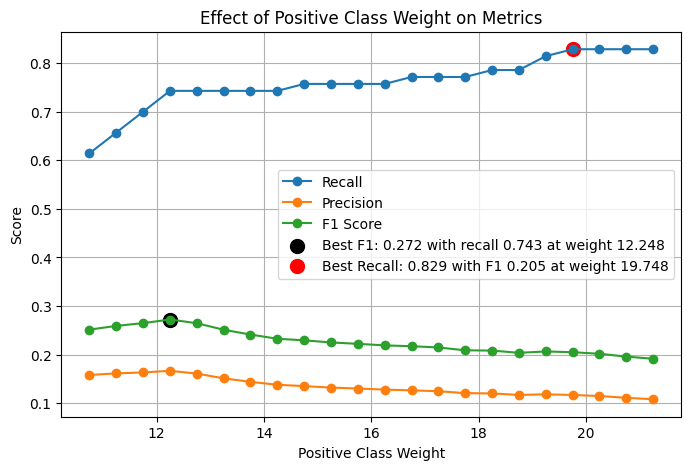

In [ ]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test, learning_rate=0.01)

Pour l'instant je vais garder le poid additionnel

<s>Le cout augmente, donc peut-être le learning rate est trop grand. Je vais l'ajuster.</s>

Pour trouver le learning rate optimal, je peux check quel learning rate donne la meilleure balance entre un bon F1 score et un cost function bas. C'est pas forcément celui où la loss est la plus basse ou le F1 est le plus haut, mais celui ou il y a une bonne balance entre les deux.

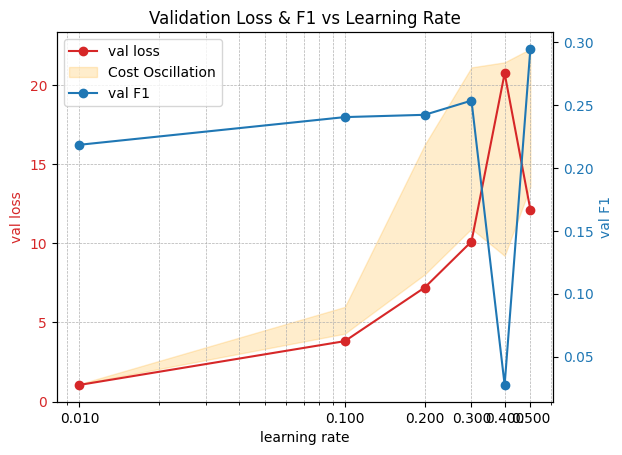

In [ ]:
lrs = np.array([0.01,0.1, 0.2, 0.3, 0.4, 0.5])
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, toPlot=True, iterations=500, extra_weight=ratio)

In [ ]:
print(val_losses)

[np.float64(20.753900159947033), np.float64(10.117057651472667), np.float64(7.210948584760829)]


Après avoir fix l'erreur du sigmoid qui overflow (dans exp(z)), j'obtiens des résultats complètements différents...

On peut voir que la meilleure balance offerte est clairement autour d'un learning rate de 0.3. 
- Avant 0.3, le score F1 est bas, avec un coût bas. 
- Après 0.3, le modèle devient instable, le coût varie et F1 chute.

Aussi le cout plus bas en 0.3 et 0.2 est normal. Le cout ne varie pas linéairement. Un learning rate trop petit peut coincer le modèle lors de son entrainement, car il n'arrive pas a surmonter un minimum local et donc sa peut causer une augmentation du cout puisqu'il reste coincer plus haut. Un learning rate optimale stabilise la descente vers un minimum global.

In [ ]:
print(val_f1s)

[0.0, 0.0, 0.07792207792207792, 0.0, 0.0]


0.3 est un le sweet spot.

In [ ]:
learning_rate = 0.3

Maintenant, je vais trouver le nombre d'itérations optimal.

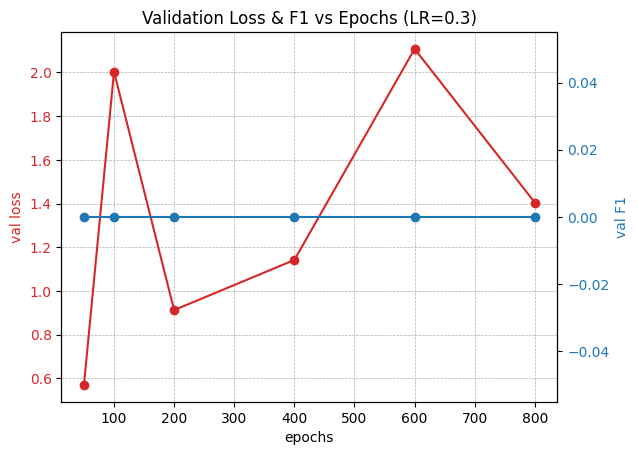

In [ ]:
epochs_list = [50, 100, 200, 400, 600, 800]
val_losses, f1_scores = plot_tools.epochs_grid_search(
    X_train_np, y_train_np, X_val_np, y_val_np,
    epochs_list, learning_rate=learning_rate
)

In [ ]:
print(f1_scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

learning_rate=learning_rate

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, iterations=1000, extra_weight=ratio, learning_rate=0.3)

Iteration 0: Cost = 1.3035216307952924
Iteration 100: Cost = 11.025588656409333
Iteration 200: Cost = 11.669417821625473
Iteration 300: Cost = 10.97425346667837
Iteration 400: Cost = 11.991234643853907
Iteration 500: Cost = 11.14037589059247
Iteration 600: Cost = 14.121543536487126
Iteration 700: Cost = 12.549552464806338
Iteration 800: Cost = 11.26285324721419
Iteration 900: Cost = 12.982785073132654


In [ ]:
threshold = 0.5 #trop bas
model = Model.Model(w, b, threshold, improvement="adjusted weights")
model_tracker.add(model)

model.print_stats(X_val_np, y_val_np)

Model v4 saved

adjusted weights

Threshold:  0.5
Accuracy:  0.9072961373390558
[[1037   58]
 [  50   20]]
AUC:  0.7760078277886497


C'est déja mieux, mais le threshold est trop bas. Je vais essayer 0.5

In [ ]:
threshold = 0.5
model = Model.Model(w, b, threshold, improvement="adjusted weights")
model_tracker.add(model)

model.print_stats(X_val_np, y_val_np)

Model v12 saved

adjusted weights

Threshold:  0.5
Accuracy:  0.6815450643776824
[[741 354]
 [ 17  53]]
AUC:  0.7884148727984346


Beaucoup mieux, en plus avec un threshold de 0.5. Donc je croit, le modèle est asser précis maintenant. Je vais chercher le meilleur threshold.

In [ ]:
threshold = logisticRegression.get_youden_threshold(X_val_np, y_val_np, w, b)
model = Model.Model(w, b, threshold, improvement="Youden index threshold")

YOUDEN_MODEL = "YoudenModel"
model_tracker.add(model, name=YOUDEN_MODEL, set_preferred=True)
model.print_stats(X_val_np, y_val_np)

Model YoudenModel existe deja, overriding...
Model YoudenModel saved

Youden index threshold

Threshold:  0.5638292284742521
Accuracy:  0.7570815450643776
[[832 263]
 [ 20  50]]
AUC:  0.7844618395303327


Au faite non, il n'est pas asser précis. Il a 313 False positive, donc il prédit 313 personnes comme ayant besoin d'assurance caravan en faite que non, ils ont pas besoin. En plus, il manque pas mal de personne (17) qui ont actually besoin d'une assurance caravan. 

In [ ]:
data.top_index_and_values(15 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799
High level education                               MOPLHOOG   - 0.0782
1 car                                              MAUT1      - 0.0734
Income 45-75.000                                   MINK4575   - 0.0699
Number of fire policies                            ABRAND     - 0.0695
Number

On voit que PPERSAUT & APERSAUT sont les variables qui corrèles le plus avec CARAVAN, ce qui fais du sens puisque pour utiliser une Caravan, il faut au minimum une voiture pour la remorquer. 
- Donc, je pourrais indiquer à mon modèle qui si la personne a aucune voiture, alors c'est un "pas besoin d'assurance caravan" ou tout simplement les retirer du dataset. (C'est mieux de pas retirer, car sinon il pourrait miss des patterns et mal classifiés des personnes plus tard)

De plus, APLEZIER, PPLEZIER et PBRAND nous dit que les personnes qui ont des caravans sont des personnes avec un bon income, c'est surtout des clients disposant d’un pouvoir d’achat élevé.
- Donc, s'il y a moyen, peut-etre d'indiquer au modèle de faire plus attention a eux?

Je peux ajouter des "interaction terms". Pour PPERSAUT et APERSAUT c'est parfait puisque l'effet de PPERSAUT sur la probabilité d'avoir besoin d'une assurance caravan, dépend de APERSAUT (ou en d'autre mots dépend du nombre de car policies).

In [ ]:
vars_to_test = [
    'PPERSAUT',   # Contribution car policies
    'APERSAUT',   # Number of car policies
    'APLEZIER',   # Number of boat policies
    'PPLEZIER',   # Contribution boat policies
    'PBRAND',     # Contribution fire policies
    'MINKGEM',    # Average income
    'PWAPART',    # Contribution private third party insurance see L4 
    'MKOOPKLA',   # Purchasing power class
    'AWAPART',    # Number of private third party insurance 1 - 12 
    'MHKOOP'      # Home owners
]

logisticRegression.interactions_terms_tester(X_train, y_train_np, w, b, vars_to_test=vars_to_test, learning_rate=0.005, ratio=ratio)

Interaction PPERSAUT_x_APERSAUT : AUC = 0.7559 (gain = +0.0010)
Interaction PPERSAUT_x_APLEZIER : AUC = 0.7606 (gain = +0.0057)
Interaction PPERSAUT_x_PPLEZIER : AUC = 0.7604 (gain = +0.0055)
Interaction PPERSAUT_x_PBRAND : AUC = 0.7599 (gain = +0.0050)
Interaction PPERSAUT_x_MINKGEM : AUC = 0.7551 (gain = +0.0002)
Interaction PPERSAUT_x_PWAPART : AUC = 0.7568 (gain = +0.0020)
Interaction PPERSAUT_x_MKOOPKLA : AUC = 0.7550 (gain = +0.0001)
Interaction PPERSAUT_x_AWAPART : AUC = 0.7560 (gain = +0.0011)
Interaction PPERSAUT_x_MHKOOP : AUC = 0.7562 (gain = +0.0013)
Interaction APERSAUT_x_APLEZIER : AUC = 0.7552 (gain = +0.0003)
Interaction APERSAUT_x_PPLEZIER : AUC = 0.7562 (gain = +0.0014)
Interaction APERSAUT_x_PBRAND : AUC = 0.7593 (gain = +0.0044)
Interaction APERSAUT_x_MINKGEM : AUC = 0.7553 (gain = +0.0004)
Interaction APERSAUT_x_PWAPART : AUC = 0.7568 (gain = +0.0019)
Interaction APERSAUT_x_MKOOPKLA : AUC = 0.7550 (gain = +0.0001)
Interaction APERSAUT_x_AWAPART : AUC = 0.7555 (gain

Je vais commencer par ajouter tout les interactions qui ont au minimum +0.003 de gain. 
Donc, PPERSAUT_x_APLEZIER, PPERSAUT_x_PPLEZIER, PPERSAUT_x_PBRAND, APERSAUT_x_PBRAND, PPLEZIER_x_MINKGEM, PPLEZIER_x_MKOOPKLA, PPLEZIER_x_MHKOOP.

In [ ]:
interactions_to_add_1 = [
    ("PPERSAUT", "APLEZIER"),
    ("PPERSAUT", "PPLEZIER"),
    ("PPERSAUT", "PBRAND"),
    ("APERSAUT", "PBRAND"),
    ("APLEZIER", "MINKGEM"),
    ("APLEZIER", "MHKOOP"),
    ("PPLEZIER", "MINKGEM"),
    ("PPLEZIER", "MKOOPKLA"),
    ("PPLEZIER", "MHKOOP"),
]

X_train_final = data.add_interactions_terms(X_train, interactions_to_add_1)
X_val_final = data.add_interactions_terms(X_val, interactions_to_add_1)

X_train_final_np = X_train_final.to_numpy()
X_val_final_np = X_val_final.to_numpy()

prev_model = model_tracker.get_by_name(YOUDEN_MODEL)

model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, improvement="Added interactions terms with auc gain > 0.003", extra_weight=ratio, learning_rate=learning_rate, threshold_method="Youden")
print("With training set :")
logisticRegression.compare_auc_score(X_train_np, y_train_np, X_train_final_np, prev_model, model)

With training set :
New X : AUC = 0.7863 (gain = +0.0111)
